In [1]:
import warnings ; warnings.filterwarnings('ignore')

In [2]:
import ray
import os
import numpy as np
from ray.tune.registry import register_env
from rldm.utils import football_tools as ft
from rldm.utils import system_tools as st
from ray import tune
from ray.rllib.policy.policy import PolicySpec
from ray.rllib.utils import merge_dicts

In [3]:
n_cpus, n_gpus = st.get_cpu_gpu_count()

# Ray Initialization

In [4]:
ray.init(num_cpus=n_cpus, num_gpus=n_gpus)

{'node_ip_address': '172.17.0.2',
 'raylet_ip_address': '172.17.0.2',
 'redis_address': '172.17.0.2:10934',
 'object_store_address': '/tmp/ray/session_2022-07-22_13-00-13_060519_202/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2022-07-22_13-00-13_060519_202/sockets/raylet',
 'webui_url': None,
 'session_dir': '/tmp/ray/session_2022-07-22_13-00-13_060519_202',
 'metrics_export_port': 64389,
 'node_id': '01fce9cfb8de8fe79ec38be9be85e7eb2b3cf3dc261a5566d89938e4'}

# Environment

In [5]:
env_name = ft.n_players_to_env_name(n_players=3, auto_GK=True)
env_name

'3_vs_3_auto_GK'

In [6]:
register_env(env_name, lambda _: ft.RllibGFootball(env_name=env_name))

In [7]:
obs_space, act_space = ft.get_obs_act_space(env_name)

In [8]:
def gen_policy(idx):
    return (None, obs_space[f'player_{idx}'], act_space[f'player_{idx}'], {})


n_policies = len(obs_space)
policies = {
    'agent_{}'.format(idx): gen_policy(idx) for idx in range(n_policies)
}
policy_ids = list(policies.keys())
policy_mapping_fn = lambda agent_id, episode, **kwargs: \
    policy_ids[0 if len(policy_ids) == 1 else int(agent_id.split('_')[1])]
default_multiagent = {
    'policies': policies,
    'policy_mapping_fn': policy_mapping_fn,
}
config = {
    'env': env_name,
    'framework': 'torch',
    'lr': 0.00022602718266055705,
    'gamma': 0.9936809332376452,
    'lambda': 0.9517171675473532,
    'kl_target': 0.010117093480119358,
    'kl_coeff': 1.0,
    'clip_param': 0.20425701146213993,
    'vf_loss_coeff': 0.3503035138680095,
    'vf_clip_param': 1.4862186106326711,
    'entropy_coeff': 0.0004158966184268587,
    'num_sgd_iter': 16,
    'train_batch_size': 2_800,
    'rollout_fragment_length': 100,
    'sgd_minibatch_size': 128,
    'num_workers': 1,  # one goes to the trainer
    'num_envs_per_worker': 1,
    'num_gpus': n_gpus,
    'batch_mode': 'truncate_episodes',
    'observation_filter': 'NoFilter',
    'log_level': 'INFO',
    'ignore_worker_failures': False,
    'horizon': 500,
    'model': {
        'vf_share_layers': "true",
        'use_lstm': "true",
        'max_seq_len': 13,
        'fcnet_hiddens': [256, 256],
        'fcnet_activation': "tanh",
        'lstm_cell_size': 256,
        'lstm_use_prev_action': "true",
        'lstm_use_prev_reward': "true",
    },
    'multiagent': default_multiagent,
}

stop = {
    "timesteps_total": 1000_000,
}

policy_type = "independent"
config_type = "fixed"

a = tune.run(
    'PPO',
    name="PPO",
    reuse_actors=False,
    raise_on_failed_trial=True,
    fail_fast=True,
    max_failures=0,
    stop=stop,
    #         checkpoint_freq=100,
    checkpoint_at_end=True,
    local_dir="../../logs",
    config=config,
#     verbose=3
)
checkpoint_path = a.get_best_checkpoint(a.get_best_trial(
    "episode_reward_mean", "max"), "episode_reward_mean", "max")
print('Best checkpoint found:', checkpoint_path)

Trial name,status,loc
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,


(pid=321) 2022-07-22 13:01:48,103	INFO ppo.py:159 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
(pid=323) 2022-07-22 13:01:50,606	INFO torch_policy.py:148 -- TorchPolicy (worker=1) running on CPU.
(pid=321) 2022-07-22 13:01:50,815	INFO torch_policy.py:170 -- TorchPolicy (worker=local) running on 1 GPU(s).
(pid=323) 2022-07-22 13:01:50,746	INFO torch_policy.py:148 -- TorchPolicy (worker=1) running on CPU.
(pid=321) 2022-07-22 13:01:58,066	INFO torch_policy.py:170 -- TorchPolicy (worker=local) running on 1 GPU(s).
(pid=321) 2022-07-22 13:01:58,105	INFO rollout_worker.py:1379 -- Built policy map: {}
(pid=321) 2022-07-22 13:01:58,105	INFO rollout_worker.py:1380 -- Built preprocessor map: {'agent_0': <ray.rllib.models.preprocessors.NoPreprocessor object at 0x7f7aa58cca50>, 'agent_1': <ray.rllib.models.preprocessors.NoPreprocessor object at 0x7f7aa2a642d0>}
(pid=321) 2022-07-22 

(pid=321) 2022-07-22 13:02:11,861	INFO rnn_sequencing.py:140 -- Padded input for RNN/Attn.Nets/MA:
(pid=321) 
(pid=321) { 'features': [ np.ndarray((2977, 43), dtype=float32, min=-1.314, max=10.796, mean=0.056),
(pid=321)                 np.ndarray((2977, 43), dtype=float32, min=-1.314, max=10.796, mean=0.056),
(pid=321)                 np.ndarray((2977,), dtype=int64, min=0.0, max=18.0, mean=8.594),
(pid=321)                 np.ndarray((2977,), dtype=int64, min=0.0, max=18.0, mean=8.549),
(pid=321)                 np.ndarray((2977,), dtype=float32, min=-1.0, max=0.1, mean=-0.001),
(pid=321)                 np.ndarray((2977,), dtype=float32, min=0.0, max=0.1, mean=0.0),
(pid=321)                 np.ndarray((2977,), dtype=float32, min=0.0, max=1.0, mean=0.003),
(pid=321)                 np.ndarray((2977,), dtype=int64, min=0.0, max=1.0, mean=0.941),
(pid=321)                 np.ndarray((2977,), dtype=float32, min=-0.293, max=0.098, mean=-0.179),
(pid=321)                 np.ndarray((2977

Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 5600
  custom_metrics: {}
  date: 2022-07-22_13-02-16
  done: false
  episode_len_mean: 236.2
  episode_media: {}
  episode_reward_max: 0.0
  episode_reward_mean: -0.5899999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 10
  episodes_total: 10
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.929771138798623
          entropy_coeff: 0.0004158966184268587
          kl: 0.004435248793507975
          policy_loss: -0.021723774261772633
          total_loss: -0.015210162426921584
          vf_explained_var: -0.5804483294487
          vf_loss: 0.009411394315369156
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.930734703228587
          entropy_coeff: 0.000415896

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,1,17.911,2800,-0.59,0,-2,236.2


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 11200
  custom_metrics: {}
  date: 2022-07-22_13-02-35
  done: false
  episode_len_mean: 250.77272727272728
  episode_media: {}
  episode_reward_max: 0.0
  episode_reward_mean: -0.6318181817504492
  episode_reward_min: -2.0
  episodes_this_iter: 12
  episodes_total: 22
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.5
          cur_lr: 0.00022602718266055705
          entropy: 2.9273503848484586
          entropy_coeff: 0.0004158966184268587
          kl: 0.009113372598797742
          policy_loss: -0.014785041693574471
          total_loss: -0.00705299639542188
          vf_explained_var: -0.08877194672822952
          vf_loss: 0.012540086189195184
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.9241206780785607
          entropy

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,2,36.8482,5600,-0.631818,0,-2,250.773


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 16800
  custom_metrics: {}
  date: 2022-07-22_13-02-53
  done: false
  episode_len_mean: 230.38888888888889
  episode_media: {}
  episode_reward_max: 0.0
  episode_reward_mean: -0.49444444436166024
  episode_reward_min: -2.0
  episodes_this_iter: 14
  episodes_total: 36
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.5
          cur_lr: 0.00022602718266055705
          entropy: 2.9181897044181824
          entropy_coeff: 0.0004158966184268587
          kl: 0.008115647946657001
          policy_loss: -0.004942833503654194
          total_loss: 6.882163801319188e-05
          vf_explained_var: -0.2972274720668793
          vf_loss: 0.006187483558928112
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.9190131965137662
          entrop

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,3,55.304,8400,-0.494444,0,-2,230.389


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 22400
  custom_metrics: {}
  date: 2022-07-22_13-03-11
  done: false
  episode_len_mean: 233.125
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.44791666651144624
  episode_reward_min: -2.0
  episodes_this_iter: 12
  episodes_total: 48
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.5
          cur_lr: 0.00022602718266055705
          entropy: 2.908589502175649
          entropy_coeff: 0.0004158966184268587
          kl: 0.008129848223021943
          policy_loss: -0.03079861557732026
          total_loss: -0.026365828814007165
          vf_explained_var: -0.1211400255560875
          vf_loss: 0.004503341241182906
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.908071063813709
          entr

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,4,73.694,11200,-0.447917,0.2,-2,233.125


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 28000
  custom_metrics: {}
  date: 2022-07-22_13-03-30
  done: false
  episode_len_mean: 228.63934426229508
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.45081967200900686
  episode_reward_min: -2.0
  episodes_this_iter: 13
  episodes_total: 61
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.5
          cur_lr: 0.00022602718266055705
          entropy: 2.8885347296794257
          entropy_coeff: 0.0004158966184268587
          kl: 0.009662150763911035
          policy_loss: -0.03598702148156008
          total_loss: -0.029854975994523903
          vf_explained_var: -0.05582302063703537
          vf_loss: 0.007143245311843722
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.895065025914283
 

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,5,92.4705,14000,-0.45082,0.2,-2,228.639


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 33600
  custom_metrics: {}
  date: 2022-07-22_13-03-49
  done: false
  episode_len_mean: 241.95652173913044
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.45507246363854065
  episode_reward_min: -2.0
  episodes_this_iter: 8
  episodes_total: 69
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.5
          cur_lr: 0.00022602718266055705
          entropy: 2.8594742254132317
          entropy_coeff: 0.0004158966184268587
          kl: 0.01117707111622733
          policy_loss: -0.027636764231525984
          total_loss: -0.020810780436607144
          vf_explained_var: 0.12507519125938416
          vf_loss: 0.006927407993706376
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.857532860977309
   

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,6,111.069,16800,-0.455072,0.2,-2,241.957


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 39200
  custom_metrics: {}
  date: 2022-07-22_13-04-07
  done: false
  episode_len_mean: 233.4578313253012
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.473493975777942
  episode_reward_min: -2.0
  episodes_this_iter: 14
  episodes_total: 83
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.5
          cur_lr: 0.00022602718266055705
          entropy: 2.8674230511699403
          entropy_coeff: 0.0004158966184268587
          kl: 0.010476256660864006
          policy_loss: -0.031965212271426846
          total_loss: -0.025152675555888425
          vf_explained_var: -0.18024694919586182
          vf_loss: 0.007898743379363233
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.8873510225897743
  

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,7,129.463,19600,-0.473494,0.2,-2,233.458


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 44800
  custom_metrics: {}
  date: 2022-07-22_13-04-26
  done: false
  episode_len_mean: 226.24742268041237
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5072164947224647
  episode_reward_min: -2.0
  episodes_this_iter: 14
  episodes_total: 97
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.5
          cur_lr: 0.00022602718266055705
          entropy: 2.847076659401258
          entropy_coeff: 0.0004158966184268587
          kl: 0.011779278781368816
          policy_loss: -0.08831112781522929
          total_loss: -0.07945612417201378
          vf_explained_var: -0.0588018037378788
          vf_loss: 0.01184530889059672
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.8770229816436768
     

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,8,148.181,22400,-0.507216,0.2,-2,226.247


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 50400
  custom_metrics: {}
  date: 2022-07-22_13-04-45
  done: false
  episode_len_mean: 233.06
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5109999998658895
  episode_reward_min: -2.0
  episodes_this_iter: 10
  episodes_total: 107
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.5
          cur_lr: 0.00022602718266055705
          entropy: 2.8426998477606547
          entropy_coeff: 0.0004158966184268587
          kl: 0.011118542326161253
          policy_loss: -0.05235042505730581
          total_loss: -0.04561122776820931
          vf_explained_var: 0.13808174431324005
          vf_loss: 0.00674328914040719
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.855142437985965
          entrop

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,9,166.783,25200,-0.511,0.2,-2,233.06


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 56000
  custom_metrics: {}
  date: 2022-07-22_13-05-03
  done: false
  episode_len_mean: 236.98
  episode_media: {}
  episode_reward_max: 0.30000001192092896
  episode_reward_mean: -0.5059999997168779
  episode_reward_min: -2.0
  episodes_this_iter: 10
  episodes_total: 117
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.5
          cur_lr: 0.00022602718266055705
          entropy: 2.787471198609897
          entropy_coeff: 0.0004158966184268587
          kl: 0.015948089949155815
          policy_loss: -0.06242829187024091
          total_loss: -0.05321923785266422
          vf_explained_var: 0.1716715395450592
          vf_loss: 0.006834959218308324
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.852558609275591
          entropy

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,10,185.436,28000,-0.506,0.3,-2,236.98


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 61600
  custom_metrics: {}
  date: 2022-07-22_13-05-22
  done: false
  episode_len_mean: 234.77
  episode_media: {}
  episode_reward_max: 0.30000001192092896
  episode_reward_mean: -0.5239999996870757
  episode_reward_min: -2.0
  episodes_this_iter: 10
  episodes_total: 127
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.5
          cur_lr: 0.00022602718266055705
          entropy: 2.795101460246813
          entropy_coeff: 0.0004158966184268587
          kl: 0.012286398743353879
          policy_loss: -0.05202851009865602
          total_loss: -0.044658723331633066
          vf_explained_var: -0.07446881383657455
          vf_loss: 0.006819964764222927
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.8495974292357764
          ent

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,11,204.007,30800,-0.524,0.3,-2,234.77


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 67200
  custom_metrics: {}
  date: 2022-07-22_13-05-40
  done: false
  episode_len_mean: 249.58
  episode_media: {}
  episode_reward_max: 0.30000001192092896
  episode_reward_mean: -0.46499999970197675
  episode_reward_min: -2.0
  episodes_this_iter: 10
  episodes_total: 137
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.5
          cur_lr: 0.00022602718266055705
          entropy: 2.761435012022654
          entropy_coeff: 0.0004158966184268587
          kl: 0.016378314658005887
          policy_loss: -0.06436470445069495
          total_loss: -0.055634431652877195
          vf_explained_var: 0.2635875940322876
          vf_loss: 0.004823209644763708
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.8367904793648493
          entr

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,12,222.513,33600,-0.465,0.3,-2,249.58


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 72800
  custom_metrics: {}
  date: 2022-07-22_13-05-59
  done: false
  episode_len_mean: 251.55
  episode_media: {}
  episode_reward_max: 0.30000001192092896
  episode_reward_mean: -0.4459999997168779
  episode_reward_min: -2.0
  episodes_this_iter: 11
  episodes_total: 148
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.5
          cur_lr: 0.00022602718266055705
          entropy: 2.7729182768435705
          entropy_coeff: 0.0004158966184268587
          kl: 0.017048518346345326
          policy_loss: -0.06714072203405001
          total_loss: -0.05873596184201666
          vf_explained_var: 0.09606347978115082
          vf_loss: 0.002951004745184383
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.8389965139684223
          entr

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,13,240.995,36400,-0.446,0.3,-2,251.55


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 78400
  custom_metrics: {}
  date: 2022-07-22_13-06-18
  done: false
  episode_len_mean: 251.23
  episode_media: {}
  episode_reward_max: 0.30000001192092896
  episode_reward_mean: -0.42399999968707563
  episode_reward_min: -2.0
  episodes_this_iter: 13
  episodes_total: 161
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.5
          cur_lr: 0.00022602718266055705
          entropy: 2.740273731805029
          entropy_coeff: 0.0004158966184268587
          kl: 0.014580337117602466
          policy_loss: -0.058714831907612584
          total_loss: -0.05029856329201721
          vf_explained_var: -0.05157607048749924
          vf_loss: 0.006468029076564736
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.83763833911646
          entr

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,14,259.635,39200,-0.424,0.3,-2,251.23


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 84000
  custom_metrics: {}
  date: 2022-07-22_13-06-36
  done: false
  episode_len_mean: 249.67
  episode_media: {}
  episode_reward_max: 0.30000001192092896
  episode_reward_mean: -0.4039999996870756
  episode_reward_min: -2.0
  episodes_this_iter: 10
  episodes_total: 171
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.5
          cur_lr: 0.00022602718266055705
          entropy: 2.701237680656569
          entropy_coeff: 0.0004158966184268587
          kl: 0.016596325211390768
          policy_loss: -0.06607803708123226
          total_loss: -0.056464329158188775
          vf_explained_var: -0.1311293989419937
          vf_loss: 0.006962476947852078
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.8059035440286
          entropy

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,15,278.289,42000,-0.404,0.3,-2,249.67


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 89600
  custom_metrics: {}
  date: 2022-07-22_13-06-55
  done: false
  episode_len_mean: 244.36
  episode_media: {}
  episode_reward_max: 0.30000001192092896
  episode_reward_mean: -0.4019999996572733
  episode_reward_min: -2.0
  episodes_this_iter: 15
  episodes_total: 186
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.5
          cur_lr: 0.00022602718266055705
          entropy: 2.726239196601368
          entropy_coeff: 0.0004158966184268587
          kl: 0.015575609898263147
          policy_loss: -0.06662421201478234
          total_loss: -0.0565053795948881
          vf_explained_var: -0.13603349030017853
          vf_loss: 0.009891025450737547
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.8149308498416628
          entro

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,16,296.918,44800,-0.402,0.3,-2,244.36


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 95200
  custom_metrics: {}
  date: 2022-07-22_13-07-14
  done: false
  episode_len_mean: 242.77
  episode_media: {}
  episode_reward_max: 0.30000001192092896
  episode_reward_mean: -0.3609999996423721
  episode_reward_min: -2.0
  episodes_this_iter: 14
  episodes_total: 200
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.5
          cur_lr: 0.00022602718266055705
          entropy: 2.6974660477467944
          entropy_coeff: 0.0004158966184268587
          kl: 0.019359186665941365
          policy_loss: -0.06767363507450293
          total_loss: -0.056449015678178206
          vf_explained_var: 0.2126660794019699
          vf_loss: 0.007613089712928438
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.798106844226519
          entro

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,17,315.637,47600,-0.361,0.3,-2,242.77


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 100800
  custom_metrics: {}
  date: 2022-07-22_13-07-32
  done: false
  episode_len_mean: 245.87
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.3619999997317791
  episode_reward_min: -2.0
  episodes_this_iter: 10
  episodes_total: 210
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.5
          cur_lr: 0.00022602718266055705
          entropy: 2.7049558340083983
          entropy_coeff: 0.0004158966184268587
          kl: 0.01624389121021034
          policy_loss: -0.06524182841531001
          total_loss: -0.05510209367050612
          vf_explained_var: -0.04185109958052635
          vf_loss: 0.008971564865402928
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.799417409868467
          entr

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,18,334.302,50400,-0.362,0.1,-2,245.87


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 106400
  custom_metrics: {}
  date: 2022-07-22_13-07-51
  done: false
  episode_len_mean: 230.06
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.4049999997764826
  episode_reward_min: -2.0
  episodes_this_iter: 16
  episodes_total: 226
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.5
          cur_lr: 0.00022602718266055705
          entropy: 2.694143139180683
          entropy_coeff: 0.0004158966184268587
          kl: 0.014987886487131882
          policy_loss: -0.06509348391236494
          total_loss: -0.05492830322847502
          vf_explained_var: 0.08173184096813202
          vf_loss: 0.010824108516750303
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.805671798331397
          entro

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,19,352.98,53200,-0.405,0.1,-2,230.06


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 112000
  custom_metrics: {}
  date: 2022-07-22_13-08-10
  done: false
  episode_len_mean: 216.3
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.4239999997615814
  episode_reward_min: -2.0
  episodes_this_iter: 14
  episodes_total: 240
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.5
          cur_lr: 0.00022602718266055705
          entropy: 2.672430906267393
          entropy_coeff: 0.0004158966184268587
          kl: 0.017203447378133226
          policy_loss: -0.05222217739910342
          total_loss: -0.043001247137518864
          vf_explained_var: -0.09072025865316391
          vf_loss: 0.004940464446138192
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.8060602453492938
          ent

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,20,371.725,56000,-0.424,0.1,-2,216.3


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 117600
  custom_metrics: {}
  date: 2022-07-22_13-08-29
  done: false
  episode_len_mean: 216.31
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5039999997615814
  episode_reward_min: -2.0
  episodes_this_iter: 12
  episodes_total: 252
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.5
          cur_lr: 0.00022602718266055705
          entropy: 2.6588120070241748
          entropy_coeff: 0.0004158966184268587
          kl: 0.013903334791062724
          policy_loss: -0.0608640379907142
          total_loss: -0.052797716339617703
          vf_explained_var: -0.27215686440467834
          vf_loss: 0.006338625804606376
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.810074115083331
          ent

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,21,390.59,58800,-0.504,0.1,-2,216.31


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 123200
  custom_metrics: {}
  date: 2022-07-22_13-08-48
  done: false
  episode_len_mean: 218.98
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5239999997615814
  episode_reward_min: -2.0
  episodes_this_iter: 10
  episodes_total: 262
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.5
          cur_lr: 0.00022602718266055705
          entropy: 2.6618598827293942
          entropy_coeff: 0.0004158966184268587
          kl: 0.0160256173422982
          policy_loss: -0.04735753886351241
          total_loss: -0.03851708044073478
          vf_explained_var: 0.12486032396554947
          vf_loss: 0.005522944439213634
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.7671008833817075
          entro

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,22,409.282,61600,-0.524,0.1,-2,218.98


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 128800
  custom_metrics: {}
  date: 2022-07-22_13-09-06
  done: false
  episode_len_mean: 218.12
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5229999997466802
  episode_reward_min: -2.0
  episodes_this_iter: 14
  episodes_total: 276
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.5
          cur_lr: 0.00022602718266055705
          entropy: 2.6494862834612527
          entropy_coeff: 0.0004158966184268587
          kl: 0.016594173642793475
          policy_loss: -0.12077929475509293
          total_loss: -0.11181505461007916
          vf_explained_var: 0.005220929626375437
          vf_loss: 0.005050092848943591
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.7732538148051216
          en

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,23,428.19,64400,-0.523,0.1,-2,218.12


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 134400
  custom_metrics: {}
  date: 2022-07-22_13-09-25
  done: false
  episode_len_mean: 227.59
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.4649999997764826
  episode_reward_min: -2.0
  episodes_this_iter: 10
  episodes_total: 286
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.5
          cur_lr: 0.00022602718266055705
          entropy: 2.6499138055812743
          entropy_coeff: 0.0004158966184268587
          kl: 0.016827860801355055
          policy_loss: -0.1396757485345006
          total_loss: -0.13121524705101842
          vf_explained_var: -0.13648110628128052
          vf_loss: 0.0032790474806028043
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.758085798649561
          ent

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,24,447.1,67200,-0.465,0.1,-2,227.59


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 140000
  custom_metrics: {}
  date: 2022-07-22_13-09-44
  done: false
  episode_len_mean: 228.7
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.4649999997764826
  episode_reward_min: -2.0
  episodes_this_iter: 11
  episodes_total: 297
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.5
          cur_lr: 0.00022602718266055705
          entropy: 2.6546784412293207
          entropy_coeff: 0.0004158966184268587
          kl: 0.015671445105402956
          policy_loss: -0.06950696947318474
          total_loss: -0.06085405331534622
          vf_explained_var: -0.16215577721595764
          vf_loss: 0.005484571104413287
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.728767509971346
          entr

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,25,465.944,70000,-0.465,0.1,-2,228.7


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 145600
  custom_metrics: {}
  date: 2022-07-22_13-10-03
  done: false
  episode_len_mean: 234.34
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.44399999976158144
  episode_reward_min: -2.0
  episodes_this_iter: 10
  episodes_total: 307
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.5
          cur_lr: 0.00022602718266055705
          entropy: 2.6584222799255732
          entropy_coeff: 0.0004158966184268587
          kl: 0.017161087348841236
          policy_loss: -0.08632071796914499
          total_loss: -0.07691592561726186
          vf_explained_var: -0.2883186936378479
          vf_loss: 0.005509157799938943
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.7204626160008565
          en

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,26,484.698,72800,-0.444,0.1,-2,234.34


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 151200
  custom_metrics: {}
  date: 2022-07-22_13-10-22
  done: false
  episode_len_mean: 237.61
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.4039999997615814
  episode_reward_min: -2.0
  episodes_this_iter: 8
  episodes_total: 315
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.5
          cur_lr: 0.00022602718266055705
          entropy: 2.6188585545335497
          entropy_coeff: 0.0004158966184268587
          kl: 0.016997170127222246
          policy_loss: -0.08125027488018705
          total_loss: -0.07201079516060072
          vf_explained_var: -0.20331910252571106
          vf_loss: 0.005224236939760712
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.717887195093291
          entr

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,27,503.373,75600,-0.404,0.1,-2,237.61


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 156800
  custom_metrics: {}
  date: 2022-07-22_13-10-41
  done: false
  episode_len_mean: 251.64
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.3429999997466803
  episode_reward_min: -2.0
  episodes_this_iter: 11
  episodes_total: 326
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.5
          cur_lr: 0.00022602718266055705
          entropy: 2.6064666282562983
          entropy_coeff: 0.0004158966184268587
          kl: 0.017107807157097584
          policy_loss: -0.07098511594016427
          total_loss: -0.061262580886510216
          vf_explained_var: -0.2338351011276245
          vf_loss: 0.006430573972379318
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.712306193652607
          ent

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,28,522.169,78400,-0.343,0.1,-2,251.64


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 162400
  custom_metrics: {}
  date: 2022-07-22_13-10-59
  done: false
  episode_len_mean: 259.17
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.36099999971687796
  episode_reward_min: -2.0
  episodes_this_iter: 9
  episodes_total: 335
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.5
          cur_lr: 0.00022602718266055705
          entropy: 2.5650897409234727
          entropy_coeff: 0.0004158966184268587
          kl: 0.019514164364475044
          policy_loss: -0.07586705979580681
          total_loss: -0.06549244523159273
          vf_explained_var: -0.11498187482357025
          vf_loss: 0.0048082473487219045
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.724324901898702
          en

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,29,540.643,81200,-0.361,0.1,-2,259.17


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 168000
  custom_metrics: {}
  date: 2022-07-22_13-11-18
  done: false
  episode_len_mean: 265.67
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.3989999996870756
  episode_reward_min: -2.0
  episodes_this_iter: 12
  episodes_total: 347
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.5
          cur_lr: 0.00022602718266055705
          entropy: 2.5693922291199365
          entropy_coeff: 0.0004158966184268587
          kl: 0.014085141005019336
          policy_loss: -0.10213280880738498
          total_loss: -0.09404573146024459
          vf_explained_var: -0.2279123067855835
          vf_loss: 0.006032220937153657
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.724022621200198
          entr

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,30,559.26,84000,-0.399,0.1,-2,265.67


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 173600
  custom_metrics: {}
  date: 2022-07-22_13-11-37
  done: false
  episode_len_mean: 268.91
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.35899999968707563
  episode_reward_min: -2.0
  episodes_this_iter: 10
  episodes_total: 357
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.5
          cur_lr: 0.00022602718266055705
          entropy: 2.5746873226903735
          entropy_coeff: 0.0004158966184268587
          kl: 0.0179493925419144
          policy_loss: -0.07294340592177052
          total_loss: -0.06212310748482456
          vf_explained_var: 0.0281378086656332
          vf_loss: 0.008325369085339065
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.7013879872503734
          entro

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,31,577.98,86800,-0.359,0.1,-2,268.91


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 179200
  custom_metrics: {}
  date: 2022-07-22_13-11-55
  done: false
  episode_len_mean: 263.72
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.39599999964237215
  episode_reward_min: -2.0
  episodes_this_iter: 14
  episodes_total: 371
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.5
          cur_lr: 0.00022602718266055705
          entropy: 2.558931073262578
          entropy_coeff: 0.0004158966184268587
          kl: 0.017643119402871214
          policy_loss: -0.08156819855052856
          total_loss: -0.07106506086988486
          vf_explained_var: -0.1210523247718811
          vf_loss: 0.007838423952004328
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.7023586751449677
          ent

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,32,596.866,89600,-0.396,0.2,-2,263.72


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 184800
  custom_metrics: {}
  date: 2022-07-22_13-12-14
  done: false
  episode_len_mean: 258.03
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.39599999964237215
  episode_reward_min: -2.0
  episodes_this_iter: 11
  episodes_total: 382
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.5
          cur_lr: 0.00022602718266055705
          entropy: 2.559173184491339
          entropy_coeff: 0.0004158966184268587
          kl: 0.01791442465031558
          policy_loss: -0.0582026739298488
          total_loss: -0.048249729273395915
          vf_explained_var: 0.14417465031147003
          vf_loss: 0.005880847292982729
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.706104177094641
          entro

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,33,615.788,92400,-0.396,0.2,-2,258.03


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 190400
  custom_metrics: {}
  date: 2022-07-22_13-12-33
  done: false
  episode_len_mean: 258.31
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.354999999627471
  episode_reward_min: -2.0
  episodes_this_iter: 13
  episodes_total: 395
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.5
          cur_lr: 0.00022602718266055705
          entropy: 2.5169475915886106
          entropy_coeff: 0.0004158966184268587
          kl: 0.020100642261974843
          policy_loss: -0.08484527047368742
          total_loss: -0.07401422115175851
          vf_explained_var: 0.0316477008163929
          vf_loss: 0.005216950419708155
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.698287110953104
          entrop

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,34,634.529,95200,-0.355,0.2,-2,258.31


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 196000
  custom_metrics: {}
  date: 2022-07-22_13-12-52
  done: false
  episode_len_mean: 256.42
  episode_media: {}
  episode_reward_max: 0.5000000074505806
  episode_reward_mean: -0.36999999955296514
  episode_reward_min: -2.0
  episodes_this_iter: 11
  episodes_total: 406
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.5
          cur_lr: 0.00022602718266055705
          entropy: 2.5442846977994558
          entropy_coeff: 0.0004158966184268587
          kl: 0.020034096011001385
          policy_loss: -0.046280792647762393
          total_loss: -0.03503892106735813
          vf_explained_var: 0.007872899062931538
          vf_loss: 0.006517153195870508
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.679442116192409
          en

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,35,653.084,98000,-0.37,0.5,-2,256.42


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 201600
  custom_metrics: {}
  date: 2022-07-22_13-13-10
  done: false
  episode_len_mean: 246.68
  episode_media: {}
  episode_reward_max: 0.5000000074505806
  episode_reward_mean: -0.328999999538064
  episode_reward_min: -2.0
  episodes_this_iter: 11
  episodes_total: 417
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.5
          cur_lr: 0.00022602718266055705
          entropy: 2.490496815670104
          entropy_coeff: 0.0004158966184268587
          kl: 0.017002431124330118
          policy_loss: -0.12944666207199806
          total_loss: -0.1206999073086384
          vf_explained_var: -0.21182221174240112
          vf_loss: 0.0036577651024431576
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.6634966901370456
          entro

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,36,671.66,100800,-0.329,0.5,-2,246.68


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 207200
  custom_metrics: {}
  date: 2022-07-22_13-13-29
  done: false
  episode_len_mean: 248.53
  episode_media: {}
  episode_reward_max: 0.5000000074505806
  episode_reward_mean: -0.3259999994933605
  episode_reward_min: -2.0
  episodes_this_iter: 9
  episodes_total: 426
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.5
          cur_lr: 0.00022602718266055705
          entropy: 2.5419940870432627
          entropy_coeff: 0.0004158966184268587
          kl: 0.01760605788320291
          policy_loss: -0.10576676992890757
          total_loss: -0.09653868121014446
          vf_explained_var: -0.16778893768787384
          vf_loss: 0.004231375541470091
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.656922127519335
          entrop

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,37,690.246,103600,-0.326,0.5,-2,248.53


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 212800
  custom_metrics: {}
  date: 2022-07-22_13-13-48
  done: false
  episode_len_mean: 247.2
  episode_media: {}
  episode_reward_max: 0.5000000074505806
  episode_reward_mean: -0.3079999995231628
  episode_reward_min: -2.0
  episodes_this_iter: 10
  episodes_total: 436
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.5
          cur_lr: 0.00022602718266055705
          entropy: 2.5430538405974707
          entropy_coeff: 0.0004158966184268587
          kl: 0.01802498277875636
          policy_loss: -0.08349325844236384
          total_loss: -0.0735669409559705
          vf_explained_var: -0.1615581214427948
          vf_loss: 0.005627900416411215
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.6639491582200643
          entropy

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,38,708.82,106400,-0.308,0.5,-2,247.2


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 218400
  custom_metrics: {}
  date: 2022-07-22_13-14-06
  done: false
  episode_len_mean: 247.57
  episode_media: {}
  episode_reward_max: 0.5000000074505806
  episode_reward_mean: -0.22799999952316286
  episode_reward_min: -2.0
  episodes_this_iter: 12
  episodes_total: 448
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.5
          cur_lr: 0.00022602718266055705
          entropy: 2.552229491727693
          entropy_coeff: 0.0004158966184268587
          kl: 0.017525495816559527
          policy_loss: -0.07725257123456686
          total_loss: -0.06779534253707555
          vf_explained_var: -0.3147861361503601
          vf_loss: 0.005012634263732166
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.6638199403172447
          entr

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,39,727.305,109200,-0.228,0.5,-2,247.57


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 224000
  custom_metrics: {}
  date: 2022-07-22_13-14-24
  done: false
  episode_len_mean: 249.59
  episode_media: {}
  episode_reward_max: 0.5000000074505806
  episode_reward_mean: -0.24499999947845935
  episode_reward_min: -2.0
  episodes_this_iter: 11
  episodes_total: 459
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.5
          cur_lr: 0.00022602718266055705
          entropy: 2.5202439916985377
          entropy_coeff: 0.0004158966184268587
          kl: 0.014422379820131765
          policy_loss: -0.06374443485895297
          total_loss: -0.0549803993032713
          vf_explained_var: -0.018866093829274178
          vf_loss: 0.007424995918275575
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.640703967639378
          ent

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,40,745.581,112000,-0.245,0.5,-2,249.59


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 229600
  custom_metrics: {}
  date: 2022-07-22_13-14-43
  done: false
  episode_len_mean: 262.74
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.25999999947845936
  episode_reward_min: -2.0
  episodes_this_iter: 8
  episodes_total: 467
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.5
          cur_lr: 0.00022602718266055705
          entropy: 2.5172340174516044
          entropy_coeff: 0.0004158966184268587
          kl: 0.0175433557489981
          policy_loss: -0.0740895742835294
          total_loss: -0.06452307791083253
          vf_explained_var: -0.04463737830519676
          vf_loss: 0.005257516311584844
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.6482223130407787
          entrop

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,41,763.869,114800,-0.26,0.6,-2,262.74


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 235200
  custom_metrics: {}
  date: 2022-07-22_13-15-01
  done: false
  episode_len_mean: 254.03
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.2569999994337559
  episode_reward_min: -2.0
  episodes_this_iter: 15
  episodes_total: 482
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.5
          cur_lr: 0.00022602718266055705
          entropy: 2.5766247574772154
          entropy_coeff: 0.0004158966184268587
          kl: 0.016309220499407435
          policy_loss: -0.06953729184498939
          total_loss: -0.05962187754526634
          vf_explained_var: -0.07978679984807968
          vf_loss: 0.00808560434511275
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.6216694762309394
          entr

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,42,782.042,117600,-0.257,0.6,-2,254.03


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 240800
  custom_metrics: {}
  date: 2022-07-22_13-15-19
  done: false
  episode_len_mean: 255.08
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.3539999993890524
  episode_reward_min: -2.0
  episodes_this_iter: 11
  episodes_total: 493
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.5
          cur_lr: 0.00022602718266055705
          entropy: 2.560613671938578
          entropy_coeff: 0.0004158966184268587
          kl: 0.018929982585693495
          policy_loss: -0.04315542191865721
          total_loss: -0.031991560494394174
          vf_explained_var: 0.2709145247936249
          vf_loss: 0.007889793907885351
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.6225763154881343
          entro

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,43,800.496,120400,-0.354,0.6,-2,255.08


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 246400
  custom_metrics: {}
  date: 2022-07-22_13-15-38
  done: false
  episode_len_mean: 264.78
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.3709999992698431
  episode_reward_min: -2.0
  episodes_this_iter: 9
  episodes_total: 502
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.5
          cur_lr: 0.00022602718266055705
          entropy: 2.562326506489799
          entropy_coeff: 0.0004158966184268587
          kl: 0.01741083831581433
          policy_loss: -0.07975081937980749
          total_loss: -0.07033950384495602
          vf_explained_var: 0.03813742473721504
          vf_loss: 0.005057213604102019
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.6305474511214664
          entropy

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,44,818.677,123200,-0.371,0.6,-2,264.78


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 252000
  custom_metrics: {}
  date: 2022-07-22_13-15-56
  done: false
  episode_len_mean: 257.33
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.39199999928474427
  episode_reward_min: -2.0
  episodes_this_iter: 11
  episodes_total: 513
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.5
          cur_lr: 0.00022602718266055705
          entropy: 2.541603785895166
          entropy_coeff: 0.0004158966184268587
          kl: 0.0198965465197885
          policy_loss: -0.09048553773027379
          total_loss: -0.07985551491756701
          vf_explained_var: 0.11580798774957657
          vf_loss: 0.004963677507995661
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.635182357969738
          entropy

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,45,837.271,126000,-0.392,0.6,-2,257.33


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 257600
  custom_metrics: {}
  date: 2022-07-22_13-16-15
  done: false
  episode_len_mean: 258.37
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.4559999993443489
  episode_reward_min: -2.0
  episodes_this_iter: 11
  episodes_total: 524
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.5
          cur_lr: 0.00022602718266055705
          entropy: 2.5526060362656913
          entropy_coeff: 0.0004158966184268587
          kl: 0.016006814088793557
          policy_loss: -0.12056829695661907
          total_loss: -0.11121510773470315
          vf_explained_var: 0.004399345256388187
          vf_loss: 0.0068837549363143765
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.651449585954348
          ent

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,46,856.105,128800,-0.456,0.6,-2,258.37


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 263200
  custom_metrics: {}
  date: 2022-07-22_13-16-33
  done: false
  episode_len_mean: 250.48
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.4509999992698431
  episode_reward_min: -2.0
  episodes_this_iter: 13
  episodes_total: 537
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.5
          cur_lr: 0.00022602718266055705
          entropy: 2.5535265845911845
          entropy_coeff: 0.0004158966184268587
          kl: 0.019876670367274557
          policy_loss: -0.09883898741307869
          total_loss: -0.08830260675503745
          vf_explained_var: 0.025027384981513023
          vf_loss: 0.004738895129516355
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.655436505873998
          entr

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,47,874.36,131600,-0.451,0.6,-2,250.48


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 268800
  custom_metrics: {}
  date: 2022-07-22_13-16-52
  done: false
  episode_len_mean: 247.23
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.4709999992698431
  episode_reward_min: -2.0
  episodes_this_iter: 13
  episodes_total: 550
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.5
          cur_lr: 0.00022602718266055705
          entropy: 2.578293881246022
          entropy_coeff: 0.0004158966184268587
          kl: 0.01659970144929443
          policy_loss: -0.06197898907772642
          total_loss: -0.05235112090535733
          vf_explained_var: -0.021040689200162888
          vf_loss: 0.006852122239555077
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.64960186680158
          entrop

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,48,892.74,134400,-0.471,0.6,-2,247.23


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 274400
  custom_metrics: {}
  date: 2022-07-22_13-17-10
  done: false
  episode_len_mean: 228.62
  episode_media: {}
  episode_reward_max: 0.4000000134110451
  episode_reward_mean: -0.43699999928474426
  episode_reward_min: -2.0
  episodes_this_iter: 16
  episodes_total: 566
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.5
          cur_lr: 0.00022602718266055705
          entropy: 2.495536576424326
          entropy_coeff: 0.0004158966184268587
          kl: 0.016704642253541593
          policy_loss: -0.06521626107427264
          total_loss: -0.055263521534514096
          vf_explained_var: -0.05802230164408684
          vf_loss: 0.007531483897071753
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.6002391690299627
          en

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,49,911.121,137200,-0.437,0.4,-2,228.62


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 280000
  custom_metrics: {}
  date: 2022-07-22_13-17-28
  done: false
  episode_len_mean: 227.43
  episode_media: {}
  episode_reward_max: 0.4000000134110451
  episode_reward_mean: -0.40099999934434893
  episode_reward_min: -2.0
  episodes_this_iter: 14
  episodes_total: 580
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.5
          cur_lr: 0.00022602718266055705
          entropy: 2.5116587636016665
          entropy_coeff: 0.0004158966184268587
          kl: 0.018944668415526483
          policy_loss: -0.09157087119057819
          total_loss: -0.08148162234777244
          vf_explained_var: -0.1142626479268074
          vf_loss: 0.004743049067959267
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.617443018016361
          entr

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,50,929.362,140000,-0.401,0.4,-2,227.43


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 285600
  custom_metrics: {}
  date: 2022-07-22_13-17-47
  done: false
  episode_len_mean: 231.06
  episode_media: {}
  episode_reward_max: 0.4000000134110451
  episode_reward_mean: -0.31699999928474426
  episode_reward_min: -2.0
  episodes_this_iter: 10
  episodes_total: 590
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.5
          cur_lr: 0.00022602718266055705
          entropy: 2.509705444176992
          entropy_coeff: 0.0004158966184268587
          kl: 0.023407865945702173
          policy_loss: -0.09760923273322641
          total_loss: -0.08607538752091516
          vf_explained_var: 0.07454434782266617
          vf_loss: 0.002494102700265579
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.614916295522735
          entro

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,51,947.606,142800,-0.317,0.4,-2,231.06


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 291200
  custom_metrics: {}
  date: 2022-07-22_13-18-05
  done: false
  episode_len_mean: 219.77
  episode_media: {}
  episode_reward_max: 0.30000000447034836
  episode_reward_mean: -0.33999999940395353
  episode_reward_min: -2.0
  episodes_this_iter: 14
  episodes_total: 604
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.5277910246735527
          entropy_coeff: 0.0004158966184268587
          kl: 0.011837177982883721
          policy_loss: -0.05327598651915434
          total_loss: -0.042612234474204126
          vf_explained_var: -0.21591199934482574
          vf_loss: 0.008099167413612511
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.63115124688262
          e

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,52,965.817,145600,-0.34,0.3,-2,219.77


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 296800
  custom_metrics: {}
  date: 2022-07-22_13-18-23
  done: false
  episode_len_mean: 224.39
  episode_media: {}
  episode_reward_max: 0.30000000447034836
  episode_reward_mean: -0.362999999448657
  episode_reward_min: -2.0
  episodes_this_iter: 9
  episodes_total: 613
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.5379851843629564
          entropy_coeff: 0.0004158966184268587
          kl: 0.015556075209240976
          policy_loss: -0.09100630459752643
          total_loss: -0.0784347188448356
          vf_explained_var: 0.05519115924835205
          vf_loss: 0.005595355433407738
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.60904399341061
          entropy

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,53,984.1,148400,-0.363,0.3,-2,224.39


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 302400
  custom_metrics: {}
  date: 2022-07-22_13-18-42
  done: false
  episode_len_mean: 216.38
  episode_media: {}
  episode_reward_max: 0.30000000447034836
  episode_reward_mean: -0.32299999944865704
  episode_reward_min: -2.0
  episodes_this_iter: 14
  episodes_total: 627
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.5428472530274164
          entropy_coeff: 0.0004158966184268587
          kl: 0.013428545299898629
          policy_loss: -0.07034363011119976
          total_loss: -0.05885202194414368
          vf_explained_var: 0.07395371794700623
          vf_loss: 0.00707318489540263
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.629515331415903
          ent

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,54,1002.45,151200,-0.323,0.3,-2,216.38


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 308000
  custom_metrics: {}
  date: 2022-07-22_13-19-00
  done: false
  episode_len_mean: 223.67
  episode_media: {}
  episode_reward_max: 0.30000000447034836
  episode_reward_mean: -0.3619999994337559
  episode_reward_min: -2.0
  episodes_this_iter: 9
  episodes_total: 636
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.5539936196236384
          entropy_coeff: 0.0004158966184268587
          kl: 0.014055950207674407
          policy_loss: -0.09758686506271867
          total_loss: -0.08657887803879237
          vf_explained_var: 0.08548411726951599
          vf_loss: 0.004362562791703524
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.6532514414616992
          ent

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,55,1020.57,154000,-0.362,0.3,-2,223.67


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 313600
  custom_metrics: {}
  date: 2022-07-22_13-19-18
  done: false
  episode_len_mean: 228.11
  episode_media: {}
  episode_reward_max: 0.30000000447034836
  episode_reward_mean: -0.3979999992996454
  episode_reward_min: -2.0
  episodes_this_iter: 13
  episodes_total: 649
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.527798640586081
          entropy_coeff: 0.0004158966184268587
          kl: 0.015667195585000144
          policy_loss: -0.05035991903087918
          total_loss: -0.037750616077090626
          vf_explained_var: 0.12830474972724915
          vf_loss: 0.005453013128273943
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.634853409159751
          ent

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,56,1038.8,156800,-0.398,0.3,-2,228.11


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 319200
  custom_metrics: {}
  date: 2022-07-22_13-19-36
  done: false
  episode_len_mean: 230.87
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.3559999992698431
  episode_reward_min: -2.0
  episodes_this_iter: 13
  episodes_total: 662
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.5046677532650174
          entropy_coeff: 0.0004158966184268587
          kl: 0.016846531777569854
          policy_loss: -0.13336157057936016
          total_loss: -0.12071075406068606
          vf_explained_var: 0.0536140538752079
          vf_loss: 0.003019093617608416
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.59605058885756
          entro

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,57,1057.13,159600,-0.356,0.2,-2,230.87


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 324800
  custom_metrics: {}
  date: 2022-07-22_13-19-55
  done: false
  episode_len_mean: 238.68
  episode_media: {}
  episode_reward_max: 0.30000000447034836
  episode_reward_mean: -0.32899999916553496
  episode_reward_min: -2.0
  episodes_this_iter: 10
  episodes_total: 672
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.4549226941806928
          entropy_coeff: 0.0004158966184268587
          kl: 0.01724171587507622
          policy_loss: -0.06568216440427932
          total_loss: -0.052209000594476015
          vf_explained_var: -0.08389094471931458
          vf_loss: 0.004461471418748954
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.590999965866407
          e

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,58,1075.44,162400,-0.329,0.3,-2,238.68


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 330400
  custom_metrics: {}
  date: 2022-07-22_13-20-13
  done: false
  episode_len_mean: 241.94
  episode_media: {}
  episode_reward_max: 0.30000000447034836
  episode_reward_mean: -0.3849999991059303
  episode_reward_min: -2.0
  episodes_this_iter: 11
  episodes_total: 683
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.501080869209199
          entropy_coeff: 0.0004158966184268587
          kl: 0.014163828448057362
          policy_loss: -0.07648701627303603
          total_loss: -0.06446392624634643
          vf_explained_var: 0.013321950100362301
          vf_loss: 0.00696656001534956
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.5863827644359496
          ent

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,59,1093.8,165200,-0.385,0.3,-2,241.94


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 336000
  custom_metrics: {}
  date: 2022-07-22_13-20-32
  done: false
  episode_len_mean: 250.87
  episode_media: {}
  episode_reward_max: 0.30000000447034836
  episode_reward_mean: -0.3849999991059303
  episode_reward_min: -2.0
  episodes_this_iter: 8
  episodes_total: 691
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.472183715019907
          entropy_coeff: 0.0004158966184268587
          kl: 0.017316980109950454
          policy_loss: -0.06126305621139528
          total_loss: -0.04856268184569975
          vf_explained_var: -0.11866450309753418
          vf_loss: 0.002114770241557077
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.580037241890317
          entr

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,60,1112.42,168000,-0.385,0.3,-2,250.87


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 341600
  custom_metrics: {}
  date: 2022-07-22_13-20-51
  done: false
  episode_len_mean: 254.03
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.3619999990612268
  episode_reward_min: -2.0
  episodes_this_iter: 13
  episodes_total: 704
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.5250976582368216
          entropy_coeff: 0.0004158966184268587
          kl: 0.013344346150107541
          policy_loss: -0.09534750092175923
          total_loss: -0.08465715481205345
          vf_explained_var: -0.14217694103717804
          vf_loss: 0.004945042288714571
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.611591415036292
          ent

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,61,1131.3,170800,-0.362,0.4,-2,254.03


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 347200
  custom_metrics: {}
  date: 2022-07-22_13-21-09
  done: false
  episode_len_mean: 248.8
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.2949999989569187
  episode_reward_min: -2.0
  episodes_this_iter: 10
  episodes_total: 714
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.539495966973759
          entropy_coeff: 0.0004158966184268587
          kl: 0.016447834071367032
          policy_loss: -0.09119692539319485
          total_loss: -0.07865093679876216
          vf_explained_var: -0.14632312953472137
          vf_loss: 0.003614809212671216
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.598345094493457
          entro

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,62,1149.96,173600,-0.295,0.4,-2,248.8


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 352800
  custom_metrics: {}
  date: 2022-07-22_13-21-28
  done: false
  episode_len_mean: 253.53
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.31199999891221525
  episode_reward_min: -2.0
  episodes_this_iter: 12
  episodes_total: 726
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.5159235575369427
          entropy_coeff: 0.0004158966184268587
          kl: 0.011974426566059135
          policy_loss: -0.10173942335781508
          total_loss: -0.09197854777613386
          vf_explained_var: -0.29501649737358093
          vf_loss: 0.005213816704088545
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.611345356418973
          en

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,63,1168.62,176400,-0.312,0.4,-2,253.53


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 358400
  custom_metrics: {}
  date: 2022-07-22_13-21-47
  done: false
  episode_len_mean: 241.54
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.2719999989122152
  episode_reward_min: -2.0
  episodes_this_iter: 15
  episodes_total: 741
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.4998341287885393
          entropy_coeff: 0.0004158966184268587
          kl: 0.015004512344308631
          policy_loss: -0.1313681442497043
          total_loss: -0.11999679731421306
          vf_explained_var: -0.42077040672302246
          vf_loss: 0.0033046624810681565
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.608210985149656
          ent

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,64,1187.39,179200,-0.272,0.4,-2,241.54


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 364000
  custom_metrics: {}
  date: 2022-07-22_13-22-06
  done: false
  episode_len_mean: 249.5
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.2899999988824129
  episode_reward_min: -2.0
  episodes_this_iter: 9
  episodes_total: 750
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.555158026871227
          entropy_coeff: 0.0004158966184268587
          kl: 0.01189848473099571
          policy_loss: -0.0702672064113098
          total_loss: -0.06114414894476622
          vf_explained_var: -0.046882908791303635
          vf_loss: 0.0036022276478130757
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.609489592767897
          entrop

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,65,1206.09,182000,-0.29,0.4,-2,249.5


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 369600
  custom_metrics: {}
  date: 2022-07-22_13-22-24
  done: false
  episode_len_mean: 254.29
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.3309999988973141
  episode_reward_min: -2.0
  episodes_this_iter: 11
  episodes_total: 761
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.5234366548912868
          entropy_coeff: 0.0004158966184268587
          kl: 0.015184392684680128
          policy_loss: -0.06195224448345557
          total_loss: -0.05012297768206779
          vf_explained_var: -0.13108770549297333
          vf_loss: 0.004254775396475452
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.6078275584039234
          en

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,66,1224.7,184800,-0.331,0.4,-2,254.29


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 375200
  custom_metrics: {}
  date: 2022-07-22_13-22-43
  done: false
  episode_len_mean: 243.95
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.35199999891221523
  episode_reward_min: -2.0
  episodes_this_iter: 14
  episodes_total: 775
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.4502314974864325
          entropy_coeff: 0.0004158966184268587
          kl: 0.013590110537993416
          policy_loss: -0.05489961622706254
          total_loss: -0.04387041003376778
          vf_explained_var: -0.019635405391454697
          vf_loss: 0.0052973122985263
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.552120581269264
          ent

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,67,1243.45,187600,-0.352,0.4,-2,243.95


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 380800
  custom_metrics: {}
  date: 2022-07-22_13-23-02
  done: false
  episode_len_mean: 248.47
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.29199999891221523
  episode_reward_min: -2.0
  episodes_this_iter: 9
  episodes_total: 784
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.495018408412025
          entropy_coeff: 0.0004158966184268587
          kl: 0.01599488072886072
          policy_loss: -0.08274827508579446
          total_loss: -0.07071766746996998
          vf_explained_var: 0.05002939701080322
          vf_loss: 0.003060532450988484
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.586869383142108
          entrop

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,68,1261.89,190400,-0.292,0.4,-2,248.47


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 386400
  custom_metrics: {}
  date: 2022-07-22_13-23-20
  done: false
  episode_len_mean: 241.48
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.2709999988973141
  episode_reward_min: -2.0
  episodes_this_iter: 12
  episodes_total: 796
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.475428982149987
          entropy_coeff: 0.0004158966184268587
          kl: 0.01894469342501392
          policy_loss: -0.08394922389925341
          total_loss: -0.07009326603344691
          vf_explained_var: -0.046874068677425385
          vf_loss: 0.001932491939312188
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.527384726064546
          entr

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,69,1280.5,193200,-0.271,0.4,-2,241.48


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 392000
  custom_metrics: {}
  date: 2022-07-22_13-23-39
  done: false
  episode_len_mean: 242.34
  episode_media: {}
  episode_reward_max: 0.30000001192092896
  episode_reward_mean: -0.2549999989569187
  episode_reward_min: -2.0
  episodes_this_iter: 12
  episodes_total: 808
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.503230799521719
          entropy_coeff: 0.0004158966184268587
          kl: 0.012874128858025065
          policy_loss: -0.06624584515174363
          total_loss: -0.05629141563016068
          vf_explained_var: -0.22925713658332825
          vf_loss: 0.0038250243683034483
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.5623557439872195
          e

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,70,1299.28,196000,-0.255,0.3,-2,242.34


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 397600
  custom_metrics: {}
  date: 2022-07-22_13-23-58
  done: false
  episode_len_mean: 242.76
  episode_media: {}
  episode_reward_max: 0.30000001192092896
  episode_reward_mean: -0.25699999898672105
  episode_reward_min: -2.0
  episodes_this_iter: 10
  episodes_total: 818
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.497096912491889
          entropy_coeff: 0.0004158966184268587
          kl: 0.012455179358534473
          policy_loss: -0.07020506888234411
          total_loss: -0.06065107339444304
          vf_explained_var: -0.2612075209617615
          vf_loss: 0.003571595778859254
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.5952550165709996
          en

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,71,1317.95,198800,-0.257,0.3,-2,242.76


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 403200
  custom_metrics: {}
  date: 2022-07-22_13-24-16
  done: false
  episode_len_mean: 244.58
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.3009999991208315
  episode_reward_min: -2.0
  episodes_this_iter: 12
  episodes_total: 830
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.4715289885089513
          entropy_coeff: 0.0004158966184268587
          kl: 0.013318390480361758
          policy_loss: -0.06567326805142264
          total_loss: -0.05438059027697558
          vf_explained_var: -0.24787071347236633
          vf_loss: 0.00665646401986513
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.579787646021162
          ent

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,72,1336.68,201600,-0.301,0.2,-2,244.58


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 408800
  custom_metrics: {}
  date: 2022-07-22_13-24-35
  done: false
  episode_len_mean: 242.48
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.32399999916553496
  episode_reward_min: -2.0
  episodes_this_iter: 15
  episodes_total: 845
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.4309028827008747
          entropy_coeff: 0.0004158966184268587
          kl: 0.014226615537694007
          policy_loss: -0.07034142709259565
          total_loss: -0.05796348330442838
          vf_explained_var: -0.27214041352272034
          vf_loss: 0.007761797223100162
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.566998923108691
          e

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,73,1355.23,204400,-0.324,0.2,-2,242.48


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 414400
  custom_metrics: {}
  date: 2022-07-22_13-24-53
  done: false
  episode_len_mean: 228.51
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.2669999992102385
  episode_reward_min: -2.0
  episodes_this_iter: 13
  episodes_total: 858
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.4202680630343303
          entropy_coeff: 0.0004158966184268587
          kl: 0.016908499343029567
          policy_loss: -0.10692070879269436
          total_loss: -0.093994566233873
          vf_explained_var: -0.00914869736880064
          vf_loss: 0.0035721859099534675
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.574558988213539
          ent

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,74,1373.59,207200,-0.267,0.2,-2,228.51


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 420000
  custom_metrics: {}
  date: 2022-07-22_13-25-12
  done: false
  episode_len_mean: 232.83
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.2309999992698431
  episode_reward_min: -2.0
  episodes_this_iter: 12
  episodes_total: 870
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.4196380220708393
          entropy_coeff: 0.0004158966184268587
          kl: 0.016308466288203077
          policy_loss: -0.08176157713097339
          total_loss: -0.06989248633553438
          vf_explained_var: -0.08581551164388657
          vf_loss: 0.0018385852795940341
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.55715578297774
          en

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,75,1391.93,210000,-0.231,0.2,-2,232.83


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 425600
  custom_metrics: {}
  date: 2022-07-22_13-25-30
  done: false
  episode_len_mean: 244.8
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.23199999928474427
  episode_reward_min: -2.0
  episodes_this_iter: 8
  episodes_total: 878
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.421853599448999
          entropy_coeff: 0.0004158966184268587
          kl: 0.0169643816393427
          policy_loss: -0.06279769848763922
          total_loss: -0.05017783221930066
          vf_explained_var: 0.13996250927448273
          vf_loss: 0.0025801044990831066
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.5810130210149858
          entro

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,76,1410.18,212800,-0.232,0.2,-2,244.8


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 431200
  custom_metrics: {}
  date: 2022-07-22_13-25-48
  done: false
  episode_len_mean: 245.96
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.21299999929964542
  episode_reward_min: -2.0
  episodes_this_iter: 7
  episodes_total: 885
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.464175975038892
          entropy_coeff: 0.0004158966184268587
          kl: 0.01754584726036741
          policy_loss: -0.09601300888295684
          total_loss: -0.08350887618629106
          vf_explained_var: 0.24732926487922668
          vf_loss: 0.0010550532220544742
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.6062625447909036
          ent

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,77,1428.42,215600,-0.213,0.2,-2,245.96


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 436800
  custom_metrics: {}
  date: 2022-07-22_13-26-07
  done: false
  episode_len_mean: 249.85
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.2719999992847443
  episode_reward_min: -2.0
  episodes_this_iter: 12
  episodes_total: 897
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.4311419413203286
          entropy_coeff: 0.0004158966184268587
          kl: 0.01172589153029097
          policy_loss: -0.03788661282201896
          total_loss: -0.02838740655958342
          vf_explained_var: -0.033285368233919144
          vf_loss: 0.004898295428574784
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.497996042172114
          ent

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,78,1446.8,218400,-0.272,0.4,-2,249.85


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 442400
  custom_metrics: {}
  date: 2022-07-22_13-26-25
  done: false
  episode_len_mean: 252.86
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.24999999925494193
  episode_reward_min: -2.0
  episodes_this_iter: 10
  episodes_total: 907
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.4317064781983695
          entropy_coeff: 0.0004158966184268587
          kl: 0.012808299292991982
          policy_loss: -0.04383038451175837
          total_loss: -0.03458313111245627
          vf_explained_var: -0.019341083243489265
          vf_loss: 0.0018622934221422752
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.5442209797246114
         

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,79,1465.32,221200,-0.25,0.4,-2,252.86


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 448000
  custom_metrics: {}
  date: 2022-07-22_13-26-44
  done: false
  episode_len_mean: 248.32
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.25299999929964545
  episode_reward_min: -2.0
  episodes_this_iter: 11
  episodes_total: 918
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.4030161606413976
          entropy_coeff: 0.0004158966184268587
          kl: 0.014672290955484587
          policy_loss: -0.09009748038979956
          total_loss: -0.07918921789219201
          vf_explained_var: 0.03826260566711426
          vf_loss: 0.002579040860187628
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.5274572258903865
          en

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,80,1483.75,224000,-0.253,0.4,-2,248.32


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 453600
  custom_metrics: {}
  date: 2022-07-22_13-27-02
  done: false
  episode_len_mean: 251.58
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.2719999992847443
  episode_reward_min: -2.0
  episodes_this_iter: 13
  episodes_total: 931
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.4324494309368587
          entropy_coeff: 0.0004158966184268587
          kl: 0.012578197318171008
          policy_loss: -0.10021350016939409
          total_loss: -0.0897140506034096
          vf_explained_var: 0.22646404802799225
          vf_loss: 0.005930428263820345
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.5291464704842794
          entr

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,81,1502.23,226800,-0.272,0.4,-2,251.58


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 459200
  custom_metrics: {}
  date: 2022-07-22_13-27-21
  done: false
  episode_len_mean: 260.59
  episode_media: {}
  episode_reward_max: 0.5000000074505806
  episode_reward_mean: -0.2849999991804361
  episode_reward_min: -2.0
  episodes_this_iter: 7
  episodes_total: 938
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.4187372717119398
          entropy_coeff: 0.0004158966184268587
          kl: 0.017900793070380002
          policy_loss: -0.09227972108294039
          total_loss: -0.0788565357704231
          vf_explained_var: -0.02260340377688408
          vf_loss: 0.002864761242660409
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.540679774114064
          entro

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,82,1520.62,229600,-0.285,0.5,-2,260.59


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 464800
  custom_metrics: {}
  date: 2022-07-22_13-27-39
  done: false
  episode_len_mean: 269.26
  episode_media: {}
  episode_reward_max: 0.5000000074505806
  episode_reward_mean: -0.283999999165535
  episode_reward_min: -2.0
  episodes_this_iter: 13
  episodes_total: 951
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.3709550645379793
          entropy_coeff: 0.0004158966184268587
          kl: 0.014295243577648623
          policy_loss: -0.05636176428392251
          total_loss: -0.04442662510020801
          vf_explained_var: -0.13405822217464447
          vf_loss: 0.006279640057549668
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.490926689335278
          entr

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,83,1538.97,232400,-0.284,0.5,-2,269.26


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 470400
  custom_metrics: {}
  date: 2022-07-22_13-27-57
  done: false
  episode_len_mean: 275.9
  episode_media: {}
  episode_reward_max: 0.5000000074505806
  episode_reward_mean: -0.32399999916553496
  episode_reward_min: -2.0
  episodes_this_iter: 10
  episodes_total: 961
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.400373719277836
          entropy_coeff: 0.0004158966184268587
          kl: 0.01296850845430031
          policy_loss: -0.08883195994037253
          total_loss: -0.07858115287672263
          vf_explained_var: -0.15191949903964996
          vf_loss: 0.004346907532938833
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.5459682501497722
          entr

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,84,1557.11,235200,-0.324,0.5,-2,275.9


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 476000
  custom_metrics: {}
  date: 2022-07-22_13-28-16
  done: false
  episode_len_mean: 271.61
  episode_media: {}
  episode_reward_max: 0.5000000074505806
  episode_reward_mean: -0.42199999913573266
  episode_reward_min: -2.0
  episodes_this_iter: 10
  episodes_total: 971
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.3666069273437773
          entropy_coeff: 0.0004158966184268587
          kl: 0.012973463828201208
          policy_loss: -0.054309499847780295
          total_loss: -0.043327115200684475
          vf_explained_var: 0.03722235560417175
          vf_loss: 0.006384614757258706
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.524669185990379
          e

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,85,1575.35,238000,-0.422,0.5,-2,271.61


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 481600
  custom_metrics: {}
  date: 2022-07-22_13-28-34
  done: false
  episode_len_mean: 259.07
  episode_media: {}
  episode_reward_max: 0.5000000074505806
  episode_reward_mean: -0.41999999910593033
  episode_reward_min: -2.0
  episodes_this_iter: 12
  episodes_total: 983
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.38830565625713
          entropy_coeff: 0.0004158966184268587
          kl: 0.016421557448316564
          policy_loss: -0.06709938317986339
          total_loss: -0.05487334206450863
          vf_explained_var: 0.03860878944396973
          vf_loss: 0.0025782183882776216
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.4958643863598504
          ent

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,86,1593.55,240800,-0.42,0.5,-2,259.07


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 487200
  custom_metrics: {}
  date: 2022-07-22_13-28-52
  done: false
  episode_len_mean: 263.61
  episode_media: {}
  episode_reward_max: 0.5000000074505806
  episode_reward_mean: -0.43999999910593035
  episode_reward_min: -2.0
  episodes_this_iter: 10
  episodes_total: 993
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.43857080524876
          entropy_coeff: 0.0004158966184268587
          kl: 0.013761130857177768
          policy_loss: -0.052524983772205554
          total_loss: -0.041909906254399436
          vf_explained_var: 0.09046171605587006
          vf_loss: 0.0037351061718514495
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.565912520601636
          en

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,87,1611.89,243600,-0.44,0.5,-2,263.61


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 492800
  custom_metrics: {}
  date: 2022-07-22_13-29-11
  done: false
  episode_len_mean: 258.53
  episode_media: {}
  episode_reward_max: 0.5000000074505806
  episode_reward_mean: -0.3999999991059303
  episode_reward_min: -2.0
  episodes_this_iter: 11
  episodes_total: 1004
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.440415444828215
          entropy_coeff: 0.0004158966184268587
          kl: 0.018456901407037464
          policy_loss: -0.11248582218481065
          total_loss: -0.0992134332853831
          vf_explained_var: -0.004307758063077927
          vf_loss: 0.001269392982760023
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.5226328003974188
          en

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,88,1630.48,246400,-0.4,0.5,-2,258.53


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 498400
  custom_metrics: {}
  date: 2022-07-22_13-29-29
  done: false
  episode_len_mean: 250.79
  episode_media: {}
  episode_reward_max: 0.5000000074505806
  episode_reward_mean: -0.37699999906122683
  episode_reward_min: -2.0
  episodes_this_iter: 15
  episodes_total: 1019
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.4516920965342295
          entropy_coeff: 0.0004158966184268587
          kl: 0.010980525316526268
          policy_loss: -0.05510525569219941
          total_loss: -0.0469829797683425
          vf_explained_var: 0.036186352372169495
          vf_loss: 0.002587842729792014
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.4889406256732487
          e

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,89,1648.94,249200,-0.377,0.5,-2,250.79


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 504000
  custom_metrics: {}
  date: 2022-07-22_13-29-48
  done: false
  episode_len_mean: 259.68
  episode_media: {}
  episode_reward_max: 0.5000000074505806
  episode_reward_mean: -0.2909999989718199
  episode_reward_min: -2.0
  episodes_this_iter: 9
  episodes_total: 1028
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.413637176865623
          entropy_coeff: 0.0004158966184268587
          kl: 0.019097257967898396
          policy_loss: -0.08882295695738798
          total_loss: -0.07523678620124147
          vf_explained_var: 0.24817952513694763
          vf_loss: 0.0007623421438655073
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.526576775880087
          entr

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,90,1667.22,252000,-0.291,0.5,-2,259.68


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 509600
  custom_metrics: {}
  date: 2022-07-22_13-30-07
  done: false
  episode_len_mean: 240.72
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.21399999901652336
  episode_reward_min: -2.0
  episodes_this_iter: 14
  episodes_total: 1042
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.4409832642191933
          entropy_coeff: 0.0004158966184268587
          kl: 0.008695599425198824
          policy_loss: -0.04999005135392681
          total_loss: -0.04351525070039012
          vf_explained_var: -0.08752164244651794
          vf_loss: 0.002764171648517991
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.4415898592699143
          

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,91,1686.1,254800,-0.214,0.4,-2,240.72


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 515200
  custom_metrics: {}
  date: 2022-07-22_13-30-25
  done: false
  episode_len_mean: 238.06
  episode_media: {}
  episode_reward_max: 0.6000000089406967
  episode_reward_mean: -0.2629999988526106
  episode_reward_min: -2.0
  episodes_this_iter: 12
  episodes_total: 1054
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.397060507819766
          entropy_coeff: 0.0004158966184268587
          kl: 0.010145901678504841
          policy_loss: -0.05603697978048807
          total_loss: -0.04756497887761465
          vf_explained_var: -0.20655745267868042
          vf_loss: 0.005308261115022192
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.4910644321214583
          en

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,92,1704.85,257600,-0.263,0.6,-2,238.06


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 520800
  custom_metrics: {}
  date: 2022-07-22_13-30-44
  done: false
  episode_len_mean: 239.71
  episode_media: {}
  episode_reward_max: 0.6000000089406967
  episode_reward_mean: -0.2989999987930059
  episode_reward_min: -2.0
  episodes_this_iter: 10
  episodes_total: 1064
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.3994367005569592
          entropy_coeff: 0.0004158966184268587
          kl: 0.013091043840835235
          policy_loss: -0.054182543562048865
          total_loss: -0.04320583767236842
          vf_explained_var: -0.22543932497501373
          vf_loss: 0.006155628535062923
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.4380408135198413
          

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,93,1723.27,260400,-0.299,0.6,-2,239.71


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 526400
  custom_metrics: {}
  date: 2022-07-22_13-31-02
  done: false
  episode_len_mean: 245.6
  episode_media: {}
  episode_reward_max: 0.6000000089406967
  episode_reward_mean: -0.25299999870359896
  episode_reward_min: -2.0
  episodes_this_iter: 10
  episodes_total: 1074
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.4142573369400844
          entropy_coeff: 0.0004158966184268587
          kl: 0.015174661047348447
          policy_loss: -0.07456277396496651
          total_loss: -0.0628154912930248
          vf_explained_var: -0.06691458076238632
          vf_loss: 0.003911946203732528
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.471823750507264
          ent

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,94,1741.63,263200,-0.253,0.6,-2,245.6


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 532000
  custom_metrics: {}
  date: 2022-07-22_13-31-21
  done: false
  episode_len_mean: 247.8
  episode_media: {}
  episode_reward_max: 0.6000000089406967
  episode_reward_mean: -0.25099999867379663
  episode_reward_min: -2.0
  episodes_this_iter: 9
  episodes_total: 1083
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.4006828566392264
          entropy_coeff: 0.0004158966184268587
          kl: 0.01664755218201716
          policy_loss: -0.08534731379473842
          total_loss: -0.07288621158390708
          vf_explained_var: -0.04537387192249298
          vf_loss: 0.002780078616957499
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.4814680885700953
          ent

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,95,1760.3,266000,-0.251,0.6,-2,247.8


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 537600
  custom_metrics: {}
  date: 2022-07-22_13-31-40
  done: false
  episode_len_mean: 242.36
  episode_media: {}
  episode_reward_max: 0.6000000089406967
  episode_reward_mean: -0.22599999859929085
  episode_reward_min: -2.0
  episodes_this_iter: 15
  episodes_total: 1098
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.4032131958575476
          entropy_coeff: 0.0004158966184268587
          kl: 0.01656944568443057
          policy_loss: -0.103751641273924
          total_loss: -0.09153192049935958
          vf_explained_var: 0.13379248976707458
          vf_loss: 0.002261253303112469
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.4784988370679675
          entr

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,96,1779.1,268800,-0.226,0.6,-2,242.36


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 543200
  custom_metrics: {}
  date: 2022-07-22_13-31-58
  done: false
  episode_len_mean: 237.36
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.23399999842047692
  episode_reward_min: -2.0
  episodes_this_iter: 11
  episodes_total: 1109
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.3794534280896187
          entropy_coeff: 0.0004158966184268587
          kl: 0.014069331941299298
          policy_loss: -0.08046793467153857
          total_loss: -0.06991159680616138
          vf_explained_var: -0.145375058054924
          vf_loss: 0.0028373856315565284
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.4616535831065405
          en

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,97,1797.66,271600,-0.234,0.8,-2,237.36


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 548800
  custom_metrics: {}
  date: 2022-07-22_13-32-17
  done: false
  episode_len_mean: 237.74
  episode_media: {}
  episode_reward_max: 3.9999999701976776
  episode_reward_mean: -0.2559999987483025
  episode_reward_min: -2.0
  episodes_this_iter: 15
  episodes_total: 1124
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.3869558565673374
          entropy_coeff: 0.0004158966184268587
          kl: 0.00984765877435122
          policy_loss: -0.040513687124378826
          total_loss: -0.028971072579527874
          vf_explained_var: -0.121971994638443
          vf_loss: 0.014700382123399842
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.443803694276583
          ent

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,98,1816.29,274400,-0.256,4,-2,237.74


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 554400
  custom_metrics: {}
  date: 2022-07-22_13-32-36
  done: false
  episode_len_mean: 241.54
  episode_media: {}
  episode_reward_max: 3.9999999701976776
  episode_reward_mean: -0.20199999913573266
  episode_reward_min: -2.0
  episodes_this_iter: 10
  episodes_total: 1134
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.416949279251553
          entropy_coeff: 0.0004158966184268587
          kl: 0.011958260850739007
          policy_loss: -0.07145038468055039
          total_loss: -0.06097702257933894
          vf_explained_var: -0.14173582196235657
          vf_loss: 0.007164836836073803
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.5196446563516344
          e

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,99,1834.97,277200,-0.202,4,-2,241.54


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 560000
  custom_metrics: {}
  date: 2022-07-22_13-32-54
  done: false
  episode_len_mean: 240.09
  episode_media: {}
  episode_reward_max: 3.9999999701976776
  episode_reward_mean: -0.19899999901652335
  episode_reward_min: -2.0
  episodes_this_iter: 13
  episodes_total: 1147
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.408566645923115
          entropy_coeff: 0.0004158966184268587
          kl: 0.01557041725553542
          policy_loss: -0.08425100455923755
          total_loss: -0.0713337610762946
          vf_explained_var: -0.11253510415554047
          vf_loss: 0.006397725253745669
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.487467089579219
          entr

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,100,1853.75,280000,-0.199,4,-2,240.09


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 565600
  custom_metrics: {}
  date: 2022-07-22_13-33-13
  done: false
  episode_len_mean: 243.72
  episode_media: {}
  episode_reward_max: 3.9999999701976776
  episode_reward_mean: -0.17699999898672103
  episode_reward_min: -2.0
  episodes_this_iter: 11
  episodes_total: 1158
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.431636427130018
          entropy_coeff: 0.0004158966184268587
          kl: 0.014393258596329889
          policy_loss: -0.0767556075392609
          total_loss: -0.0648414724315184
          vf_explained_var: 0.2085898220539093
          vf_loss: 0.006081870502384845
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.475234206943285
          entrop

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,101,1872.4,282800,-0.177,4,-2,243.72


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 571200
  custom_metrics: {}
  date: 2022-07-22_13-33-32
  done: false
  episode_len_mean: 229.78
  episode_media: {}
  episode_reward_max: 3.9999999701976776
  episode_reward_mean: -0.23699999898672103
  episode_reward_min: -2.0
  episodes_this_iter: 14
  episodes_total: 1172
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.4114895399127687
          entropy_coeff: 0.0004158966184268587
          kl: 0.014104067342379059
          policy_loss: -0.05657313537986262
          total_loss: -0.04352584458787793
          vf_explained_var: 0.220147043466568
          vf_loss: 0.009911892381881313
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.4967809326591945
          ent

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,102,1891.31,285600,-0.237,4,-2,229.78


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 576800
  custom_metrics: {}
  date: 2022-07-22_13-33-51
  done: false
  episode_len_mean: 215.2
  episode_media: {}
  episode_reward_max: 3.9999999701976776
  episode_reward_mean: -0.2479999988526106
  episode_reward_min: -2.0
  episodes_this_iter: 14
  episodes_total: 1186
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.4144735655614307
          entropy_coeff: 0.0004158966184268587
          kl: 0.014238120251055239
          policy_loss: -0.062075453046764734
          total_loss: -0.05040285721701193
          vf_explained_var: 0.30338066816329956
          vf_loss: 0.005704132580874665
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.4703430455355417
          en

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,103,1910.24,288400,-0.248,4,-2,215.2


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 582400
  custom_metrics: {}
  date: 2022-07-22_13-34-10
  done: false
  episode_len_mean: 225.93
  episode_media: {}
  episode_reward_max: 3.9999999701976776
  episode_reward_mean: -0.24399999879300593
  episode_reward_min: -2.0
  episodes_this_iter: 9
  episodes_total: 1195
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.3470461602721895
          entropy_coeff: 0.0004158966184268587
          kl: 0.01848549969732017
          policy_loss: -0.0667352677565716
          total_loss: -0.052660902569186874
          vf_explained_var: 0.49504417181015015
          vf_loss: 0.0033866864936758895
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.4453872328712825
          en

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,104,1928.83,291200,-0.244,4,-2,225.93


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 588000
  custom_metrics: {}
  date: 2022-07-22_13-34-29
  done: false
  episode_len_mean: 226.72
  episode_media: {}
  episode_reward_max: 3.9999999701976776
  episode_reward_mean: -0.2909999988973141
  episode_reward_min: -2.0
  episodes_this_iter: 12
  episodes_total: 1207
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.3366464592871212
          entropy_coeff: 0.0004158966184268587
          kl: 0.01579181331054484
          policy_loss: -0.08104897944858316
          total_loss: -0.06866605109271837
          vf_explained_var: 0.21288159489631653
          vf_loss: 0.004313038347650685
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.4492997590984618
          ent

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,105,1947.69,294000,-0.291,4,-2,226.72


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 593600
  custom_metrics: {}
  date: 2022-07-22_13-34-47
  done: false
  episode_len_mean: 236.94
  episode_media: {}
  episode_reward_max: 3.9999999701976776
  episode_reward_mean: -0.271999998614192
  episode_reward_min: -2.0
  episodes_this_iter: 11
  episodes_total: 1218
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.3926796913146973
          entropy_coeff: 0.0004158966184268587
          kl: 0.01805878235406014
          policy_loss: -0.08910707745789773
          total_loss: -0.07590822770708612
          vf_explained_var: 0.159773588180542
          vf_loss: 0.001855160726596036
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.4293862538678304
          entrop

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,106,1966.29,296800,-0.272,4,-2,236.94


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 599200
  custom_metrics: {}
  date: 2022-07-22_13-35-06
  done: false
  episode_len_mean: 232.54
  episode_media: {}
  episode_reward_max: 0.6000000163912773
  episode_reward_mean: -0.32999999828636645
  episode_reward_min: -2.0
  episodes_this_iter: 13
  episodes_total: 1231
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.3672306087045443
          entropy_coeff: 0.0004158966184268587
          kl: 0.013673502892280648
          policy_loss: -0.06652276069096497
          total_loss: -0.0559222093186344
          vf_explained_var: 0.004854233469814062
          vf_loss: 0.003796558143048536
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.4388497656299952
          e

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,107,1985.12,299600,-0.33,0.6,-2,232.54


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 604800
  custom_metrics: {}
  date: 2022-07-22_13-35-25
  done: false
  episode_len_mean: 225.22
  episode_media: {}
  episode_reward_max: 0.9000000208616257
  episode_reward_mean: -0.31999999813735486
  episode_reward_min: -2.0
  episodes_this_iter: 14
  episodes_total: 1245
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.3549762527857507
          entropy_coeff: 0.0004158966184268587
          kl: 0.01249686645890178
          policy_loss: -0.05637297795025612
          total_loss: -0.04600519827190077
          vf_explained_var: 0.1325370967388153
          vf_loss: 0.005636701696944545
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.409177642493021
          entr

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,108,2003.87,302400,-0.32,0.9,-2,225.22


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 610400
  custom_metrics: {}
  date: 2022-07-22_13-35-44
  done: false
  episode_len_mean: 235.66
  episode_media: {}
  episode_reward_max: 0.9000000208616257
  episode_reward_mean: -0.2919999980181456
  episode_reward_min: -2.0
  episodes_this_iter: 9
  episodes_total: 1254
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.3771157012808892
          entropy_coeff: 0.0004158966184268587
          kl: 0.011857275355415692
          policy_loss: -0.057370220314450784
          total_loss: -0.04836571691668637
          vf_explained_var: 0.12291424721479416
          vf_loss: 0.003140649570100539
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.4576187502770197
          en

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,109,2022.59,305200,-0.292,0.9,-2,235.66


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 616000
  custom_metrics: {}
  date: 2022-07-22_13-36-02
  done: false
  episode_len_mean: 239.74
  episode_media: {}
  episode_reward_max: 0.9000000208616257
  episode_reward_mean: -0.2059999979287386
  episode_reward_min: -2.0
  episodes_this_iter: 10
  episodes_total: 1264
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.3710614634411677
          entropy_coeff: 0.0004158966184268587
          kl: 0.014779161202800074
          policy_loss: -0.06324497037632595
          total_loss: -0.05217198446007387
          vf_explained_var: 0.0771840438246727
          vf_loss: 0.002782539389694908
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.402808370689551
          entr

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,110,2041.34,308000,-0.206,0.9,-2,239.74


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 621600
  custom_metrics: {}
  date: 2022-07-22_13-36-21
  done: false
  episode_len_mean: 246.84
  episode_media: {}
  episode_reward_max: 0.9000000208616257
  episode_reward_mean: -0.0729999977350235
  episode_reward_min: -2.0
  episodes_this_iter: 11
  episodes_total: 1275
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.3892261435588202
          entropy_coeff: 0.0004158966184268587
          kl: 0.013949530675160042
          policy_loss: -0.07193681122355754
          total_loss: -0.061497380154010205
          vf_explained_var: 0.04023231193423271
          vf_loss: 0.002771757090764974
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.4292215825546357
          e

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,111,2060.26,310800,-0.073,0.9,-2,246.84


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 627200
  custom_metrics: {}
  date: 2022-07-22_13-36-40
  done: false
  episode_len_mean: 248.61
  episode_media: {}
  episode_reward_max: 0.9000000208616257
  episode_reward_mean: -0.12699999764561654
  episode_reward_min: -2.0
  episodes_this_iter: 12
  episodes_total: 1287
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.3527992850258235
          entropy_coeff: 0.0004158966184268587
          kl: 0.011521890531974858
          policy_loss: -0.04808681116749843
          total_loss: -0.038454906294299734
          vf_explained_var: -0.3415692448616028
          vf_loss: 0.005620864593202853
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.4172444953804924
          

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,112,2079.21,313600,-0.127,0.9,-2,248.61


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 632800
  custom_metrics: {}
  date: 2022-07-22_13-36-59
  done: false
  episode_len_mean: 249.27
  episode_media: {}
  episode_reward_max: 0.9000000208616257
  episode_reward_mean: -0.1199999975413084
  episode_reward_min: -2.0
  episodes_this_iter: 10
  episodes_total: 1297
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.3952928746030446
          entropy_coeff: 0.0004158966184268587
          kl: 0.011894223225938937
          policy_loss: -0.07078397481581349
          total_loss: -0.06165253163808735
          vf_explained_var: -0.14247989654541016
          vf_loss: 0.00344549776266268
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.4323908871128443
          en

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,113,2097.92,316400,-0.12,0.9,-2,249.27


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 638400
  custom_metrics: {}
  date: 2022-07-22_13-37-18
  done: false
  episode_len_mean: 250.21
  episode_media: {}
  episode_reward_max: 0.9000000208616257
  episode_reward_mean: -0.10799999736249447
  episode_reward_min: -2.0
  episodes_this_iter: 11
  episodes_total: 1308
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.395163594966843
          entropy_coeff: 0.0004158966184268587
          kl: 0.013899192331022728
          policy_loss: -0.0589199209851878
          total_loss: -0.048282659626455005
          vf_explained_var: 0.025042464956641197
          vf_loss: 0.003451318122166586
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.4640428445168903
          e

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,114,2116.89,319200,-0.108,0.9,-2,250.21


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 644000
  custom_metrics: {}
  date: 2022-07-22_13-37-37
  done: false
  episode_len_mean: 259.29
  episode_media: {}
  episode_reward_max: 0.9000000208616257
  episode_reward_mean: -0.10599999733269215
  episode_reward_min: -2.0
  episodes_this_iter: 8
  episodes_total: 1316
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.397865594142959
          entropy_coeff: 0.0004158966184268587
          kl: 0.017915403890000153
          policy_loss: -0.0966500643380208
          total_loss: -0.08367602548796207
          vf_explained_var: -0.002700045006349683
          vf_loss: 0.001526532309093281
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.4329873770475388
          en

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,115,2135.62,322000,-0.106,0.9,-2,259.29


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 649600
  custom_metrics: {}
  date: 2022-07-22_13-37-56
  done: false
  episode_len_mean: 258.1
  episode_media: {}
  episode_reward_max: 0.9000000208616257
  episode_reward_mean: -0.12599999696016312
  episode_reward_min: -2.0
  episodes_this_iter: 13
  episodes_total: 1329
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.3933109733320417
          entropy_coeff: 0.0004158966184268587
          kl: 0.009675390053584601
          policy_loss: -0.11101404745533641
          total_loss: -0.10336638673020172
          vf_explained_var: 0.09745807945728302
          vf_loss: 0.003957958268182708
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.419428202367964
          ent

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,116,2154.44,324800,-0.126,0.9,-2,258.1


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 655200
  custom_metrics: {}
  date: 2022-07-22_13-38-14
  done: false
  episode_len_mean: 268.68
  episode_media: {}
  episode_reward_max: 0.7000000178813934
  episode_reward_mean: -0.12399999685585499
  episode_reward_min: -2.0
  episodes_this_iter: 8
  episodes_total: 1337
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.3452968608055795
          entropy_coeff: 0.0004158966184268587
          kl: 0.014505601313295823
          policy_loss: -0.059446418479746216
          total_loss: -0.04825636869252646
          vf_explained_var: -0.15041597187519073
          vf_loss: 0.0036718125187083692
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.3956174488578523
         

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,117,2173.1,327600,-0.124,0.7,-2,268.68


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 660800
  custom_metrics: {}
  date: 2022-07-22_13-38-33
  done: false
  episode_len_mean: 274.67
  episode_media: {}
  episode_reward_max: 0.7000000178813934
  episode_reward_mean: -0.10699999690055848
  episode_reward_min: -2.0
  episodes_this_iter: 9
  episodes_total: 1346
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.376360277334849
          entropy_coeff: 0.0004158966184268587
          kl: 0.016322478552258
          policy_loss: -0.08657118973150361
          total_loss: -0.07465070205286056
          vf_explained_var: 0.18062520027160645
          vf_loss: 0.0019039195650250242
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.426130468646685
          entrop

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,118,2192.03,330400,-0.107,0.7,-2,274.67


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 666400
  custom_metrics: {}
  date: 2022-07-22_13-38-52
  done: false
  episode_len_mean: 279.02
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: -0.08799999624490738
  episode_reward_min: -2.0
  episodes_this_iter: 9
  episodes_total: 1355
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.383316609831083
          entropy_coeff: 0.0004158966184268587
          kl: 0.007976803978066454
          policy_loss: 0.05615660146802492
          total_loss: 0.06254674987325243
          vf_explained_var: 0.06291036307811737
          vf_loss: 0.003992991508398734
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.466713010555222
          entropy

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,119,2210.84,333200,-0.088,4,-2,279.02


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 672000
  custom_metrics: {}
  date: 2022-07-22_13-39-11
  done: false
  episode_len_mean: 278.57
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: -0.0429999965429306
  episode_reward_min: -2.0
  episodes_this_iter: 9
  episodes_total: 1364
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.385060211732274
          entropy_coeff: 0.0004158966184268587
          kl: 0.009915764245837547
          policy_loss: -0.06361543077721199
          total_loss: -0.052697909909814676
          vf_explained_var: -0.2817467749118805
          vf_loss: 0.012767890736410794
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.4120866464717046
          entr

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,120,2229.4,336000,-0.043,4,-2,278.57


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 677600
  custom_metrics: {}
  date: 2022-07-22_13-39-29
  done: false
  episode_len_mean: 284.14
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: -0.06499999657273292
  episode_reward_min: -2.0
  episodes_this_iter: 10
  episodes_total: 1374
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.3386393927392506
          entropy_coeff: 0.0004158966184268587
          kl: 0.016379529040111016
          policy_loss: -0.07201137548586953
          total_loss: -0.05941744090926347
          vf_explained_var: 0.3199727237224579
          vf_loss: 0.003659454176505235
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.4636170204196657
          ent

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,121,2248.04,338800,-0.065,4,-2,284.14


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 683200
  custom_metrics: {}
  date: 2022-07-22_13-39-48
  done: false
  episode_len_mean: 295.37
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: -0.06399999655783177
  episode_reward_min: -2.0
  episodes_this_iter: 7
  episodes_total: 1381
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.3561066037842204
          entropy_coeff: 0.0004158966184268587
          kl: 0.017368977381844185
          policy_loss: -0.10136556506179095
          total_loss: -0.08838636632676103
          vf_explained_var: 0.20588736236095428
          vf_loss: 0.0026615947920055035
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.4058276365200677
          en

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,122,2266.78,341600,-0.064,4,-2,295.37


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 688800
  custom_metrics: {}
  date: 2022-07-22_13-40-07
  done: false
  episode_len_mean: 301.16
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: -0.04499999649822712
  episode_reward_min: -2.0
  episodes_this_iter: 10
  episodes_total: 1391
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.3915507736660184
          entropy_coeff: 0.0004158966184268587
          kl: 0.011033279384699245
          policy_loss: -0.09997140595805831
          total_loss: -0.08873365014802576
          vf_explained_var: -0.25022006034851074
          vf_loss: 0.011297147833656276
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.4648335455428985
          e

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,123,2285.62,344400,-0.045,4,-2,301.16


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 694400
  custom_metrics: {}
  date: 2022-07-22_13-40-26
  done: false
  episode_len_mean: 295.4
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: -0.00499999649822712
  episode_reward_min: -2.0
  episodes_this_iter: 9
  episodes_total: 1400
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.336895955815202
          entropy_coeff: 0.0004158966184268587
          kl: 0.015675794053590795
          policy_loss: -0.09234610815976685
          total_loss: -0.08013755050039133
          vf_explained_var: 0.09832748025655746
          vf_loss: 0.004063960652101308
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.4474156385376338
          entro

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,124,2304.41,347200,-0.005,4,-2,295.4


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 700000
  custom_metrics: {}
  date: 2022-07-22_13-40-45
  done: false
  episode_len_mean: 293.66
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.07100000314414501
  episode_reward_min: -2.0
  episodes_this_iter: 11
  episodes_total: 1411
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.4363227734963098
          entropy_coeff: 0.0004158966184268587
          kl: 0.011123282351653205
          policy_loss: -0.06270683740426432
          total_loss: -0.05121380823246519
          vf_explained_var: -0.1919466257095337
          vf_loss: 0.011886336753594236
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.4613485435644784
          ent

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,125,2323.32,350000,0.071,4,-2,293.66


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 705600
  custom_metrics: {}
  date: 2022-07-22_13-41-04
  done: false
  episode_len_mean: 294.81
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.06800000302493572
  episode_reward_min: -2.0
  episodes_this_iter: 11
  episodes_total: 1422
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.3954920825504122
          entropy_coeff: 0.0004158966184268587
          kl: 0.014529282399579756
          policy_loss: -0.09761054162351814
          total_loss: -0.08661128005232535
          vf_explained_var: -0.41766998171806335
          vf_loss: 0.003136070307673002
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.437430113554001
          ent

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,126,2342.16,352800,0.068,4,-2,294.81


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 711200
  custom_metrics: {}
  date: 2022-07-22_13-41-23
  done: false
  episode_len_mean: 297.7
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.10200000286102295
  episode_reward_min: -2.0
  episodes_this_iter: 10
  episodes_total: 1432
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.4095355683848974
          entropy_coeff: 0.0004158966184268587
          kl: 0.012630979226735447
          policy_loss: -0.07007884971972089
          total_loss: -0.06050372293395326
          vf_explained_var: -0.26310962438583374
          vf_loss: 0.0031515909353661948
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.461636260861442
          ent

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,127,2361.12,355600,0.102,4,-2,297.7


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 716800
  custom_metrics: {}
  date: 2022-07-22_13-41-42
  done: false
  episode_len_mean: 292.71
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.10800000287592411
  episode_reward_min: -2.0
  episodes_this_iter: 10
  episodes_total: 1442
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.387622527423359
          entropy_coeff: 0.0004158966184268587
          kl: 0.014534741098175267
          policy_loss: -0.0779217665901039
          total_loss: -0.06705160255313829
          vf_explained_var: -0.4418891668319702
          vf_loss: 0.0027465104267321294
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.4603272130091987
          entr

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,128,2380.08,358400,0.108,4,-2,292.71


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 722400
  custom_metrics: {}
  date: 2022-07-22_13-42-00
  done: false
  episode_len_mean: 290.2
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.08500000275671482
  episode_reward_min: -2.0
  episodes_this_iter: 10
  episodes_total: 1452
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.342744893616154
          entropy_coeff: 0.0004158966184268587
          kl: 0.013072052204004151
          policy_loss: -0.061103141365276226
          total_loss: -0.05106011538486027
          vf_explained_var: -0.20652911067008972
          vf_loss: 0.003463647903810765
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.416581561168035
          entr

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,129,2398.86,361200,0.085,4,-2,290.2


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 728000
  custom_metrics: {}
  date: 2022-07-22_13-42-19
  done: false
  episode_len_mean: 270.04
  episode_media: {}
  episode_reward_max: 4.0
  episode_reward_mean: 0.029000002443790435
  episode_reward_min: -2.0
  episodes_this_iter: 16
  episodes_total: 1468
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.3071543428869474
          entropy_coeff: 0.0004158966184268587
          kl: 0.012880383003288462
          policy_loss: -0.04850877357893339
          total_loss: -0.03458944429864156
          vf_explained_var: -0.36808180809020996
          vf_loss: 0.014897302780030128
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.333626552706673
          entropy_coeff: 0

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,130,2417.49,364000,0.029,4,-2,270.04


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 733600
  custom_metrics: {}
  date: 2022-07-22_13-42-38
  done: false
  episode_len_mean: 253.5
  episode_media: {}
  episode_reward_max: 4.0
  episode_reward_mean: 0.03400000251829624
  episode_reward_min: -2.0
  episodes_this_iter: 11
  episodes_total: 1479
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.3438267026628767
          entropy_coeff: 0.0004158966184268587
          kl: 0.014354241151632165
          policy_loss: -0.06751622858324222
          total_loss: -0.05571666483662002
          vf_explained_var: -0.10784922540187836
          vf_loss: 0.005734090616204499
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.3808639631384896
          entropy_coeff: 0.

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,131,2436.21,366800,0.034,4,-2,253.5


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 739200
  custom_metrics: {}
  date: 2022-07-22_13-42-57
  done: false
  episode_len_mean: 247.39
  episode_media: {}
  episode_reward_max: 3.999999985098839
  episode_reward_mean: 0.004000002667307854
  episode_reward_min: -2.0
  episodes_this_iter: 13
  episodes_total: 1492
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.3136699824106124
          entropy_coeff: 0.0004158966184268587
          kl: 0.014343368082418248
          policy_loss: -0.0779890329653253
          total_loss: -0.06583036698326136
          vf_explained_var: -0.0684371367096901
          vf_loss: 0.006746689416883912
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.3345424820269858
          ent

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,132,2454.96,369600,0.004,4,-2,247.39


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 744800
  custom_metrics: {}
  date: 2022-07-22_13-43-15
  done: false
  episode_len_mean: 239.34
  episode_media: {}
  episode_reward_max: 3.999999985098839
  episode_reward_mean: -0.04699999690055847
  episode_reward_min: -2.0
  episodes_this_iter: 13
  episodes_total: 1505
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.3314175399995984
          entropy_coeff: 0.0004158966184268587
          kl: 0.014083407699903915
          policy_loss: -0.06983302058263992
          total_loss: -0.05896716584850635
          vf_explained_var: -0.05734900012612343
          vf_loss: 0.0036337866041711614
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.384956200917562
          e

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,133,2473.36,372400,-0.047,4,-2,239.34


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 750400
  custom_metrics: {}
  date: 2022-07-22_13-43-33
  done: false
  episode_len_mean: 245.13
  episode_media: {}
  episode_reward_max: 3.999999985098839
  episode_reward_mean: -0.0809999968111515
  episode_reward_min: -2.0
  episodes_this_iter: 7
  episodes_total: 1512
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.354141520247573
          entropy_coeff: 0.0004158966184268587
          kl: 0.011145204868431327
          policy_loss: -0.04739157174606676
          total_loss: -0.038756382332177874
          vf_explained_var: -0.1405554562807083
          vf_loss: 0.0035836572936074973
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.3704545199871063
          ent

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,134,2491.77,375200,-0.081,4,-2,245.13


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 756000
  custom_metrics: {}
  date: 2022-07-22_13-43-52
  done: false
  episode_len_mean: 244.7
  episode_media: {}
  episode_reward_max: 3.999999985098839
  episode_reward_mean: -0.09499999672174454
  episode_reward_min: -2.0
  episodes_this_iter: 12
  episodes_total: 1524
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.3496137389114926
          entropy_coeff: 0.0004158966184268587
          kl: 0.014624291910715723
          policy_loss: -0.0869382015780069
          total_loss: -0.07577829861769542
          vf_explained_var: 0.04721546173095703
          vf_loss: 0.00333676903704015
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.407335971792539
          entrop

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,135,2510.15,378000,-0.095,4,-2,244.7


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 761600
  custom_metrics: {}
  date: 2022-07-22_13-44-10
  done: false
  episode_len_mean: 246.8
  episode_media: {}
  episode_reward_max: 3.999999985098839
  episode_reward_mean: -0.11999999679625034
  episode_reward_min: -2.0
  episodes_this_iter: 9
  episodes_total: 1533
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.375009358638809
          entropy_coeff: 0.0004158966184268587
          kl: 0.016101241833060293
          policy_loss: -0.07571159361430632
          total_loss: -0.06341856164259038
          vf_explained_var: -0.18637506663799286
          vf_loss: 0.0034394759972894377
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.4074718923795793
          ent

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,136,2528.32,380800,-0.12,4,-2,246.8


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 767200
  custom_metrics: {}
  date: 2022-07-22_13-44-28
  done: false
  episode_len_mean: 248.13
  episode_media: {}
  episode_reward_max: 3.999999985098839
  episode_reward_mean: -0.12199999682605267
  episode_reward_min: -2.0
  episodes_this_iter: 11
  episodes_total: 1544
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.343845376656169
          entropy_coeff: 0.0004158966184268587
          kl: 0.014777088575247468
          policy_loss: -0.07040323095060601
          total_loss: -0.05859299132723771
          vf_explained_var: 0.030823588371276855
          vf_loss: 0.004859275748631695
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.346749804559208
          ent

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,137,2546.51,383600,-0.122,4,-2,248.13


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 772800
  custom_metrics: {}
  date: 2022-07-22_13-44-47
  done: false
  episode_len_mean: 254.09
  episode_media: {}
  episode_reward_max: 3.999999985098839
  episode_reward_mean: -0.11899999670684337
  episode_reward_min: -2.0
  episodes_this_iter: 7
  episodes_total: 1551
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.380124128290585
          entropy_coeff: 0.0004158966184268587
          kl: 0.012926280951568236
          policy_loss: -0.07557897574034064
          total_loss: -0.06556327006477486
          vf_explained_var: -0.2878701686859131
          vf_loss: 0.003742127653735917
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.3938293620234443
          entr

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,138,2565.06,386400,-0.119,4,-2,254.09


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 778400
  custom_metrics: {}
  date: 2022-07-22_13-45-05
  done: false
  episode_len_mean: 266.66
  episode_media: {}
  episode_reward_max: 0.9000000134110451
  episode_reward_mean: -0.1949999964982271
  episode_reward_min: -2.0
  episodes_this_iter: 11
  episodes_total: 1562
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.3558270519688014
          entropy_coeff: 0.0004158966184268587
          kl: 0.013464874636047466
          policy_loss: -0.06957036877117519
          total_loss: -0.05848384854072633
          vf_explained_var: 0.07067008316516876
          vf_loss: 0.005616973189847029
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.386628383327098
          ent

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,139,2583.49,389200,-0.195,0.9,-2,266.66


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 784000
  custom_metrics: {}
  date: 2022-07-22_13-45-24
  done: false
  episode_len_mean: 268.6
  episode_media: {}
  episode_reward_max: 0.9000000134110451
  episode_reward_mean: -0.17399999648332595
  episode_reward_min: -2.0
  episodes_this_iter: 12
  episodes_total: 1574
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.329377132512274
          entropy_coeff: 0.0004158966184268587
          kl: 0.016122190760000203
          policy_loss: -0.0802752869910494
          total_loss: -0.06824906429669465
          vf_explained_var: 0.15050499141216278
          vf_loss: 0.0025787844613746743
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.361593840732461
          entr

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,140,2601.88,392000,-0.174,0.9,-2,268.6


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 789600
  custom_metrics: {}
  date: 2022-07-22_13-45-42
  done: false
  episode_len_mean: 269.37
  episode_media: {}
  episode_reward_max: 0.9000000134110451
  episode_reward_mean: -0.12899999640882015
  episode_reward_min: -2.0
  episodes_this_iter: 10
  episodes_total: 1584
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.372585254056113
          entropy_coeff: 0.0004158966184268587
          kl: 0.014555092655993281
          policy_loss: -0.07075777286220164
          total_loss: -0.06030102733833095
          vf_explained_var: 0.24055840075016022
          vf_loss: 0.0015049117290843804
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.3769373577975093
          e

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,141,2620.27,394800,-0.129,0.9,-2,269.37


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 795200
  custom_metrics: {}
  date: 2022-07-22_13-46-01
  done: false
  episode_len_mean: 273.53
  episode_media: {}
  episode_reward_max: 0.9000000134110451
  episode_reward_mean: -0.12999999642372131
  episode_reward_min: -2.0
  episodes_this_iter: 10
  episodes_total: 1594
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.307034630505812
          entropy_coeff: 0.0004158966184268587
          kl: 0.011724793189757002
          policy_loss: -0.06099133123435812
          total_loss: -0.051972448490449186
          vf_explained_var: 0.10599362105131149
          vf_loss: 0.003382136578043823
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.376988712520826
          en

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,142,2638.63,397600,-0.13,0.9,-2,273.53


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 800800
  custom_metrics: {}
  date: 2022-07-22_13-46-19
  done: false
  episode_len_mean: 281.36
  episode_media: {}
  episode_reward_max: 4.000000044703484
  episode_reward_mean: -0.16199999615550043
  episode_reward_min: -2.0
  episodes_this_iter: 11
  episodes_total: 1605
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.3562001387278237
          entropy_coeff: 0.0004158966184268587
          kl: 0.010108555993410026
          policy_loss: -0.05314267033429046
          total_loss: -0.041593157017468046
          vf_explained_var: -0.36703065037727356
          vf_loss: 0.014124978510759926
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.345907067968732
          e

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,143,2657,400400,-0.162,4,-2,281.36


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 806400
  custom_metrics: {}
  date: 2022-07-22_13-46-37
  done: false
  episode_len_mean: 265.14
  episode_media: {}
  episode_reward_max: 4.000000044703484
  episode_reward_mean: -0.1769999960064888
  episode_reward_min: -2.0
  episodes_this_iter: 14
  episodes_total: 1619
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.3533532434985753
          entropy_coeff: 0.0004158966184268587
          kl: 0.01386746249432157
          policy_loss: -0.07414412411994167
          total_loss: -0.062477018418056626
          vf_explained_var: -0.28378021717071533
          vf_loss: 0.006409466324753123
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.3171144943861735
          en

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,144,2675.37,403200,-0.177,4,-2,265.14


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 812000
  custom_metrics: {}
  date: 2022-07-22_13-46-56
  done: false
  episode_len_mean: 262.74
  episode_media: {}
  episode_reward_max: 4.000000044703484
  episode_reward_mean: -0.11799999549984933
  episode_reward_min: -2.0
  episodes_this_iter: 11
  episodes_total: 1630
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.227258692894663
          entropy_coeff: 0.0004158966184268587
          kl: 0.016351677712165905
          policy_loss: -0.10129119115853905
          total_loss: -0.08808469339523331
          vf_explained_var: -0.009257611818611622
          vf_loss: 0.005335513934759157
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.3059668409682454
          e

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,145,2694.08,406000,-0.118,4,-2,262.74


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 817600
  custom_metrics: {}
  date: 2022-07-22_13-47-15
  done: false
  episode_len_mean: 261.05
  episode_media: {}
  episode_reward_max: 4.000000044703484
  episode_reward_mean: -0.09199999541044235
  episode_reward_min: -2.0
  episodes_this_iter: 11
  episodes_total: 1641
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.2475088380631947
          entropy_coeff: 0.0004158966184268587
          kl: 0.018680368322142055
          policy_loss: -0.10490285456416175
          total_loss: -0.09078345354092085
          vf_explained_var: 0.3301009237766266
          vf_loss: 0.0029798510471058157
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.309719716863973
          ent

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,146,2712.82,408800,-0.092,4,-2,261.05


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 823200
  custom_metrics: {}
  date: 2022-07-22_13-47-34
  done: false
  episode_len_mean: 239.86
  episode_media: {}
  episode_reward_max: 4.000000044703484
  episode_reward_mean: -0.012999995201826096
  episode_reward_min: -2.0
  episodes_this_iter: 15
  episodes_total: 1656
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.3240839803502675
          entropy_coeff: 0.0004158966184268587
          kl: 0.01375515023770316
          policy_loss: -0.0746189248722138
          total_loss: -0.06411821302147776
          vf_explained_var: -0.07936656475067139
          vf_loss: 0.0032855160430439617
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.3227325833979107
          e

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,147,2731.49,411600,-0.013,4,-2,239.86


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 828800
  custom_metrics: {}
  date: 2022-07-22_13-47-52
  done: false
  episode_len_mean: 242.65
  episode_media: {}
  episode_reward_max: 4.000000044703484
  episode_reward_mean: -0.02799999512732029
  episode_reward_min: -2.0
  episodes_this_iter: 10
  episodes_total: 1666
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.2913501791301227
          entropy_coeff: 0.0004158966184268587
          kl: 0.012721865779793454
          policy_loss: -0.07713714989880655
          total_loss: -0.06751368302795006
          vf_explained_var: -0.19655227661132812
          vf_loss: 0.002954678123863968
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.377348853009088
          en

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,148,2750.27,414400,-0.028,4,-2,242.65


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 834400
  custom_metrics: {}
  date: 2022-07-22_13-48-11
  done: false
  episode_len_mean: 251.57
  episode_media: {}
  episode_reward_max: 4.000000044703484
  episode_reward_mean: -0.03199999518692494
  episode_reward_min: -2.0
  episodes_this_iter: 6
  episodes_total: 1672
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.326724945789292
          entropy_coeff: 0.0004158966184268587
          kl: 0.016074087049900956
          policy_loss: -0.05695411810925829
          total_loss: -0.04516265956668316
          vf_explained_var: -0.0002389010915067047
          vf_loss: 0.0020084591106491905
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.3549781753903343
          

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,149,2768.96,417200,-0.032,4,-2,251.57


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 840000
  custom_metrics: {}
  date: 2022-07-22_13-48-30
  done: false
  episode_len_mean: 247.79
  episode_media: {}
  episode_reward_max: 4.000000044703484
  episode_reward_mean: -0.09199999511241913
  episode_reward_min: -2.0
  episodes_this_iter: 12
  episodes_total: 1684
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.3326001344692138
          entropy_coeff: 0.0004158966184268587
          kl: 0.01127673149278626
          policy_loss: -0.057094778444609674
          total_loss: -0.04785793354849808
          vf_explained_var: -0.1740422248840332
          vf_loss: 0.00499400353570915
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.3465129867905663
          ent

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,150,2787.79,420000,-0.092,4,-2,247.79


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 845600
  custom_metrics: {}
  date: 2022-07-22_13-48-48
  done: false
  episode_len_mean: 253.16
  episode_media: {}
  episode_reward_max: 4.000000044703484
  episode_reward_mean: -0.04299999497830868
  episode_reward_min: -2.0
  episodes_this_iter: 9
  episodes_total: 1693
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.407241042880785
          entropy_coeff: 0.0004158966184268587
          kl: 0.017190636698442757
          policy_loss: -0.10902963590792968
          total_loss: -0.09657857593889016
          vf_explained_var: 0.15702486038208008
          vf_loss: 0.0015964653577958373
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.3799401372671127
          ent

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,151,2806.29,422800,-0.043,4,-2,253.16


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 851200
  custom_metrics: {}
  date: 2022-07-22_13-49-07
  done: false
  episode_len_mean: 258.12
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: -0.011999994665384293
  episode_reward_min: -2.0
  episodes_this_iter: 10
  episodes_total: 1703
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.4188882935614813
          entropy_coeff: 0.0004158966184268587
          kl: 0.010458516076682451
          policy_loss: -0.04689029642066175
          total_loss: -0.03471283754463782
          vf_explained_var: -0.35110175609588623
          vf_loss: 0.015242726310437623
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.38741269530285
          en

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,152,2824.89,425600,-0.012,4,-2,258.12


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 856800
  custom_metrics: {}
  date: 2022-07-22_13-49-26
  done: false
  episode_len_mean: 259.79
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.01000000536441803
  episode_reward_min: -2.0
  episodes_this_iter: 11
  episodes_total: 1714
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.340760947692962
          entropy_coeff: 0.0004158966184268587
          kl: 0.011738705620528943
          policy_loss: -0.0610078355689655
          total_loss: -0.05065202396958955
          vf_explained_var: 0.009184173308312893
          vf_loss: 0.007208887321948645
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.3455508102973304
          entr

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,153,2843.63,428400,0.01,4,-2,259.79


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 862400
  custom_metrics: {}
  date: 2022-07-22_13-49-45
  done: false
  episode_len_mean: 260.97
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: -0.024999995082616806
  episode_reward_min: -2.0
  episodes_this_iter: 12
  episodes_total: 1726
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.335094464676721
          entropy_coeff: 0.0004158966184268587
          kl: 0.012688347693712056
          policy_loss: -0.08169212698010683
          total_loss: -0.07155293416387092
          vf_explained_var: -0.042207587510347366
          vf_loss: 0.004550599671433918
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.3232651647357714
          

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,154,2862.42,431200,-0.025,4,-2,260.97


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 868000
  custom_metrics: {}
  date: 2022-07-22_13-50-03
  done: false
  episode_len_mean: 262.79
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: -0.019999995008111
  episode_reward_min: -2.0
  episodes_this_iter: 11
  episodes_total: 1737
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.3766110142072043
          entropy_coeff: 0.0004158966184268587
          kl: 0.014055809944394466
          policy_loss: -0.07023062294857005
          total_loss: -0.06013176831921945
          vf_explained_var: -0.2370021492242813
          vf_loss: 0.001556998930070785
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.3409885196458724
          entr

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,155,2881.17,434000,-0.02,4,-2,262.79


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 873600
  custom_metrics: {}
  date: 2022-07-22_13-50-22
  done: false
  episode_len_mean: 266.84
  episode_media: {}
  episode_reward_max: 4.000000067055225
  episode_reward_mean: 0.007000005543231964
  episode_reward_min: -2.0
  episodes_this_iter: 11
  episodes_total: 1748
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.3560660027322315
          entropy_coeff: 0.0004158966184268587
          kl: 0.010443954897550515
          policy_loss: -0.04700021655142856
          total_loss: -0.03697732993470838
          vf_explained_var: -0.016334345564246178
          vf_loss: 0.009048725268387767
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.3046414646364393
          

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,156,2899.99,436800,0.00700001,4,-2,266.84


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 879200
  custom_metrics: {}
  date: 2022-07-22_13-50-41
  done: false
  episode_len_mean: 257.39
  episode_media: {}
  episode_reward_max: 4.000000067055225
  episode_reward_mean: 0.08900000616908073
  episode_reward_min: -2.0
  episodes_this_iter: 15
  episodes_total: 1763
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.3331019402969453
          entropy_coeff: 0.0004158966184268587
          kl: 0.010114425242064554
          policy_loss: -0.04937325067328943
          total_loss: -0.03777761484074983
          vf_explained_var: -0.45578765869140625
          vf_loss: 0.014216658365555867
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.2894849120861007
          en

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,157,2918.62,439600,0.089,4,-2,257.39


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 884800
  custom_metrics: {}
  date: 2022-07-22_13-50-59
  done: false
  episode_len_mean: 239.37
  episode_media: {}
  episode_reward_max: 4.000000067055225
  episode_reward_mean: 0.13300000600516795
  episode_reward_min: -2.0
  episodes_this_iter: 14
  episodes_total: 1777
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.262329774243491
          entropy_coeff: 0.0004158966184268587
          kl: 0.013298396392352614
          policy_loss: -0.06911812707576678
          total_loss: -0.05612232394298103
          vf_explained_var: -0.14823664724826813
          vf_loss: 0.011312763395835645
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.247049688228539
          entr

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,158,2937.05,442400,0.133,4,-2,239.37


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 890400
  custom_metrics: {}
  date: 2022-07-22_13-51-18
  done: false
  episode_len_mean: 244.91
  episode_media: {}
  episode_reward_max: 4.000000067055225
  episode_reward_mean: 0.17300000593066214
  episode_reward_min: -2.0
  episodes_this_iter: 10
  episodes_total: 1787
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 0.75
          cur_lr: 0.00022602718266055705
          entropy: 2.2928015419415066
          entropy_coeff: 0.0004158966184268587
          kl: 0.020390607082858697
          policy_loss: -0.09833756265585353
          total_loss: -0.08333998587719786
          vf_explained_var: 0.09112092852592468
          vf_loss: 0.0018789137013213587
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.2855411395430565
          en

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,159,2955.47,445200,0.173,4,-2,244.91


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 896000
  custom_metrics: {}
  date: 2022-07-22_13-51-36
  done: false
  episode_len_mean: 229.97
  episode_media: {}
  episode_reward_max: 4.000000067055225
  episode_reward_mean: 0.21600000612437725
  episode_reward_min: -2.0
  episodes_this_iter: 13
  episodes_total: 1800
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.3139682362476983
          entropy_coeff: 0.0004158966184268587
          kl: 0.01399530496085585
          policy_loss: -0.10595240350951263
          total_loss: -0.09064150681106617
          vf_explained_var: -0.02017752267420292
          vf_loss: 0.001508843200489147
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.2290189188151133
          en

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,160,2974.02,448000,0.216,4,-2,229.97


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 901600
  custom_metrics: {}
  date: 2022-07-22_13-51-55
  done: false
  episode_len_mean: 228.21
  episode_media: {}
  episode_reward_max: 4.000000067055225
  episode_reward_mean: 0.2120000058412552
  episode_reward_min: -2.0
  episodes_this_iter: 13
  episodes_total: 1813
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.3482868607555116
          entropy_coeff: 0.0004158966184268587
          kl: 0.008579278034222955
          policy_loss: -0.11795339045654275
          total_loss: -0.10845756899687417
          vf_explained_var: -0.22241275012493134
          vf_loss: 0.002343049185583368
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.2753366352546784
          en

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,161,2992.49,450800,0.212,4,-2,228.21


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 907200
  custom_metrics: {}
  date: 2022-07-22_13-52-14
  done: false
  episode_len_mean: 221.65
  episode_media: {}
  episode_reward_max: 4.000000067055225
  episode_reward_mean: 0.2510000064969063
  episode_reward_min: -2.0
  episodes_this_iter: 15
  episodes_total: 1828
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.330701216700531
          entropy_coeff: 0.0004158966184268587
          kl: 0.008052995086561892
          policy_loss: -0.11589486217347994
          total_loss: -0.10595724486657196
          vf_explained_var: -0.48974037170410156
          vf_loss: 0.005273504990652457
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.219969575603803
          entr

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,162,3011.14,453600,0.251,4,-2,221.65


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 912800
  custom_metrics: {}
  date: 2022-07-22_13-52-32
  done: false
  episode_len_mean: 225.97
  episode_media: {}
  episode_reward_max: 4.000000067055225
  episode_reward_mean: 0.23100000649690627
  episode_reward_min: -2.0
  episodes_this_iter: 8
  episodes_total: 1836
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.3144190339815047
          entropy_coeff: 0.0004158966184268587
          kl: 0.016255260431601748
          policy_loss: -0.07849044698234918
          total_loss: -0.060277667236819286
          vf_explained_var: -0.1225258857011795
          vf_loss: 0.002535437387580584
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.324911133164451
          ent

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,163,3029.53,456400,0.231,4,-2,225.97


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 918400
  custom_metrics: {}
  date: 2022-07-22_13-52-51
  done: false
  episode_len_mean: 226.3
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.18200000613927841
  episode_reward_min: -2.0
  episodes_this_iter: 12
  episodes_total: 1848
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.360599806975751
          entropy_coeff: 0.0004158966184268587
          kl: 0.010760426444611589
          policy_loss: -0.06138980426892106
          total_loss: -0.049508234841812826
          vf_explained_var: -0.17131344974040985
          vf_loss: 0.0021634325778774966
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.2713927743690356
          e

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,164,3048.01,459200,0.182,4,-2,226.3


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 924000
  custom_metrics: {}
  date: 2022-07-22_13-53-09
  done: false
  episode_len_mean: 225.11
  episode_media: {}
  episode_reward_max: 3.999999985098839
  episode_reward_mean: 0.08700000531971455
  episode_reward_min: -2.0
  episodes_this_iter: 12
  episodes_total: 1860
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.2993311055359387
          entropy_coeff: 0.0004158966184268587
          kl: 0.008935214611302159
          policy_loss: -0.05913838273694897
          total_loss: -0.048745235231416745
          vf_explained_var: -0.19475755095481873
          vf_loss: 0.0037034016671181496
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.2312879218232062
         

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,165,3066.63,462000,0.087,4,-2,225.11


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 929600
  custom_metrics: {}
  date: 2022-07-22_13-53-28
  done: false
  episode_len_mean: 233.83
  episode_media: {}
  episode_reward_max: 1.5000000596046448
  episode_reward_mean: 0.013000005558133125
  episode_reward_min: -2.0
  episodes_this_iter: 12
  episodes_total: 1872
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.3834172082798823
          entropy_coeff: 0.0004158966184268587
          kl: 0.009775370744109406
          policy_loss: -0.057328562379725986
          total_loss: -0.045478715893945525
          vf_explained_var: -0.04203557223081589
          vf_loss: 0.005263463909494974
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.396402798947834
        

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,166,3084.89,464800,0.013,1.5,-2,233.83


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 935200
  custom_metrics: {}
  date: 2022-07-22_13-53-46
  done: false
  episode_len_mean: 240.49
  episode_media: {}
  episode_reward_max: 1.5000000596046448
  episode_reward_mean: 0.03700000561773777
  episode_reward_min: -2.0
  episodes_this_iter: 10
  episodes_total: 1882
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.2960016667133285
          entropy_coeff: 0.0004158966184268587
          kl: 0.010091886838409352
          policy_loss: -0.08378765335822079
          total_loss: -0.07256747165073259
          vf_explained_var: 0.13017091155052185
          vf_loss: 0.0023457070221324797
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.373692899942398
          e

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,167,3103.45,467600,0.037,1.5,-2,240.49


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 940800
  custom_metrics: {}
  date: 2022-07-22_13-54-05
  done: false
  episode_len_mean: 239.47
  episode_media: {}
  episode_reward_max: 1.5000000596046448
  episode_reward_mean: 0.021000005677342413
  episode_reward_min: -2.0
  episodes_this_iter: 10
  episodes_total: 1892
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.2407265844799222
          entropy_coeff: 0.0004158966184268587
          kl: 0.012941904930181441
          policy_loss: -0.07042336030571761
          total_loss: -0.05596943598196785
          vf_explained_var: -0.1863097846508026
          vf_loss: 0.002358507820082152
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.2785183638334274
          

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,168,3121.95,470400,0.021,1.5,-2,239.47


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 946400
  custom_metrics: {}
  date: 2022-07-22_13-54-23
  done: false
  episode_len_mean: 250.27
  episode_media: {}
  episode_reward_max: 1.5000000596046448
  episode_reward_mean: -0.04799999453127384
  episode_reward_min: -2.0
  episodes_this_iter: 9
  episodes_total: 1901
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.336986401251384
          entropy_coeff: 0.0004158966184268587
          kl: 0.010754007642538279
          policy_loss: -0.06367075515888809
          total_loss: -0.05081307018796603
          vf_explained_var: -0.02723013237118721
          vf_loss: 0.004942489048538673
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.3093950783922557
          e

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,169,3140.64,473200,-0.048,1.5,-2,250.27


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 952000
  custom_metrics: {}
  date: 2022-07-22_13-54-42
  done: false
  episode_len_mean: 258.9
  episode_media: {}
  episode_reward_max: 1.5000000596046448
  episode_reward_mean: -0.029999994710087775
  episode_reward_min: -2.0
  episodes_this_iter: 9
  episodes_total: 1910
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.314986965131192
          entropy_coeff: 0.0004158966184268587
          kl: 0.014318648783091758
          policy_loss: -0.06772027415449668
          total_loss: -0.05209516620241283
          vf_explained_var: 0.03068511188030243
          vf_loss: 0.0013685985950793284
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.276073599855105
          en

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,170,3159.16,476000,-0.03,1.5,-2,258.9


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 957600
  custom_metrics: {}
  date: 2022-07-22_13-55-00
  done: false
  episode_len_mean: 266.5
  episode_media: {}
  episode_reward_max: 1.4000000357627869
  episode_reward_mean: -0.006999994888901711
  episode_reward_min: -2.0
  episodes_this_iter: 11
  episodes_total: 1921
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.356451155174346
          entropy_coeff: 0.0004158966184268587
          kl: 0.011184060832387549
          policy_loss: -0.07048375315311464
          total_loss: -0.058212758226242535
          vf_explained_var: -0.09028800576925278
          vf_loss: 0.0019096720660573261
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.2626340591481755
        

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,171,3177.29,478800,-0.00699999,1.4,-2,266.5


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 963200
  custom_metrics: {}
  date: 2022-07-22_13-55-18
  done: false
  episode_len_mean: 273.89
  episode_media: {}
  episode_reward_max: 1.4000000357627869
  episode_reward_mean: 0.04000000521540642
  episode_reward_min: -2.0
  episodes_this_iter: 9
  episodes_total: 1930
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.3374573779957637
          entropy_coeff: 0.0004158966184268587
          kl: 0.010133773283140066
          policy_loss: -0.053157853716714144
          total_loss: -0.0416231762771661
          vf_explained_var: -0.11474292725324631
          vf_loss: 0.0031581873630611447
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.276032882077353
          e

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,172,3195.59,481600,0.04,1.4,-2,273.89


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 968800
  custom_metrics: {}
  date: 2022-07-22_13-55-37
  done: false
  episode_len_mean: 267.45
  episode_media: {}
  episode_reward_max: 1.4000000357627869
  episode_reward_mean: 0.024000005125999452
  episode_reward_min: -2.0
  episodes_this_iter: 11
  episodes_total: 1941
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.3500500860668363
          entropy_coeff: 0.0004158966184268587
          kl: 0.00848296180569376
          policy_loss: -0.05482151925874253
          total_loss: -0.04430767790767104
          vf_explained_var: -0.3730628490447998
          vf_loss: 0.005560569515550708
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.2571336385749636
          e

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,173,3214.08,484400,0.024,1.4,-2,267.45


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 974400
  custom_metrics: {}
  date: 2022-07-22_13-55-55
  done: false
  episode_len_mean: 267.61
  episode_media: {}
  episode_reward_max: 1.4000000581145287
  episode_reward_mean: 0.042000005692243575
  episode_reward_min: -2.0
  episodes_this_iter: 14
  episodes_total: 1955
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.3079315037244843
          entropy_coeff: 0.0004158966184268587
          kl: 0.01105675113144743
          policy_loss: -0.05888239789982479
          total_loss: -0.04651129560858992
          vf_explained_var: -0.42278817296028137
          vf_loss: 0.002546705026361451
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.2105853309233985
          

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,174,3232.58,487200,0.042,1.4,-2,267.61


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 980000
  custom_metrics: {}
  date: 2022-07-22_13-56-14
  done: false
  episode_len_mean: 265.48
  episode_media: {}
  episode_reward_max: 1.4000000581145287
  episode_reward_mean: 0.08300000570714473
  episode_reward_min: -2.0
  episodes_this_iter: 11
  episodes_total: 1966
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.3370957601638067
          entropy_coeff: 0.0004158966184268587
          kl: 0.008672343983485709
          policy_loss: -0.054938683982375856
          total_loss: -0.044276502821525184
          vf_explained_var: -0.37830373644828796
          vf_loss: 0.005360450288034848
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.2614821284299804
        

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,175,3250.96,490000,0.083,1.4,-2,265.48


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 985600
  custom_metrics: {}
  date: 2022-07-22_13-56-32
  done: false
  episode_len_mean: 266.28
  episode_media: {}
  episode_reward_max: 1.4000000581145287
  episode_reward_mean: 0.014000005573034286
  episode_reward_min: -2.0
  episodes_this_iter: 10
  episodes_total: 1976
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.3357927540228482
          entropy_coeff: 0.0004158966184268587
          kl: 0.010600726824570039
          policy_loss: -0.06841243338948559
          total_loss: -0.0559342468179585
          vf_explained_var: -0.4441145956516266
          vf_loss: 0.004349994694123217
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.2978192433005287
          e

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,176,3269.34,492800,0.014,1.4,-2,266.28


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 991200
  custom_metrics: {}
  date: 2022-07-22_13-56-51
  done: false
  episode_len_mean: 270.15
  episode_media: {}
  episode_reward_max: 1.4000000581145287
  episode_reward_mean: 0.03500000558793545
  episode_reward_min: -2.0
  episodes_this_iter: 10
  episodes_total: 1986
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.3496156192961193
          entropy_coeff: 0.0004158966184268587
          kl: 0.009918656728843284
          policy_loss: -0.07657225571469033
          total_loss: -0.06543411342898339
          vf_explained_var: -0.21271319687366486
          vf_loss: 0.0027314930555240565
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.2217330655881335
         

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,177,3287.73,495600,0.035,1.4,-2,270.15


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 996800
  custom_metrics: {}
  date: 2022-07-22_13-57-09
  done: false
  episode_len_mean: 268.91
  episode_media: {}
  episode_reward_max: 1.4000000581145287
  episode_reward_mean: 0.06300000563263893
  episode_reward_min: -2.0
  episodes_this_iter: 10
  episodes_total: 1996
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.3147729177560126
          entropy_coeff: 0.0004158966184268587
          kl: 0.0144963160191894
          policy_loss: -0.09732337051329003
          total_loss: -0.08146323971907675
          vf_explained_var: 0.07158412039279938
          vf_loss: 0.0014686599554135597
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.217965561364378
          ent

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,178,3306.07,498400,0.063,1.4,-2,268.91


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1002400
  custom_metrics: {}
  date: 2022-07-22_13-57-28
  done: false
  episode_len_mean: 263.14
  episode_media: {}
  episode_reward_max: 1.4000000581145287
  episode_reward_mean: 0.08700000569224357
  episode_reward_min: -2.0
  episodes_this_iter: 10
  episodes_total: 2006
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.2510052699418295
          entropy_coeff: 0.0004158966184268587
          kl: 0.012236382093103293
          policy_loss: -0.06051266801044958
          total_loss: -0.04675002073452647
          vf_explained_var: 0.14526286721229553
          vf_loss: 0.0026631323850042896
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.1709045068848702
         

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,179,3324.47,501200,0.087,1.4,-2,263.14


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1008000
  custom_metrics: {}
  date: 2022-07-22_13-57-46
  done: false
  episode_len_mean: 255.81
  episode_media: {}
  episode_reward_max: 1.4000000581145287
  episode_reward_mean: 0.04400000549852848
  episode_reward_min: -2.0
  episodes_this_iter: 14
  episodes_total: 2020
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.3638733419634046
          entropy_coeff: 0.0004158966184268587
          kl: 0.009979476759159212
          policy_loss: -0.07331424072340485
          total_loss: -0.061948130694439725
          vf_explained_var: -0.058540113270282745
          vf_loss: 0.0032038643450851808
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.1623114783849036
      

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,180,3342.98,504000,0.044,1.4,-2,255.81


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1013600
  custom_metrics: {}
  date: 2022-07-22_13-58-05
  done: false
  episode_len_mean: 233.19
  episode_media: {}
  episode_reward_max: 1.4000000581145287
  episode_reward_mean: 0.006000005528330803
  episode_reward_min: -2.0
  episodes_this_iter: 16
  episodes_total: 2036
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.3185543091524217
          entropy_coeff: 0.0004158966184268587
          kl: 0.010050159629687614
          policy_loss: -0.06820632701973886
          total_loss: -0.055810968916505645
          vf_explained_var: -0.05210888385772705
          vf_loss: 0.00586121920232905
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.089158482849598
         

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,181,3361.37,506800,0.00600001,1.4,-2,233.19


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1019200
  custom_metrics: {}
  date: 2022-07-22_13-58-23
  done: false
  episode_len_mean: 238.51
  episode_media: {}
  episode_reward_max: 1.4000000581145287
  episode_reward_mean: 0.038000005707144735
  episode_reward_min: -2.0
  episodes_this_iter: 12
  episodes_total: 2048
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.347819602915219
          entropy_coeff: 0.0004158966184268587
          kl: 0.012971743267425758
          policy_loss: -0.0716638876252719
          total_loss: -0.05691059768737648
          vf_explained_var: 0.1587478220462799
          vf_loss: 0.003244413596327095
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.116657760526453
          ent

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,182,3379.75,509600,0.038,1.4,-2,238.51


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1024800
  custom_metrics: {}
  date: 2022-07-22_13-58-41
  done: false
  episode_len_mean: 239.11
  episode_media: {}
  episode_reward_max: 1.0000000149011612
  episode_reward_mean: 0.03100000523030758
  episode_reward_min: -2.0
  episodes_this_iter: 11
  episodes_total: 2059
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.415245824626514
          entropy_coeff: 0.0004158966184268587
          kl: 0.009705200348189362
          policy_loss: -0.12391348475579261
          total_loss: -0.11347381936779823
          vf_explained_var: -0.12021175026893616
          vf_loss: 0.001501006339952125
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.2203822111090026
          

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,183,3398.2,512400,0.031,1,-2,239.11


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1030400
  custom_metrics: {}
  date: 2022-07-22_13-59-00
  done: false
  episode_len_mean: 236.39
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.10900000579655171
  episode_reward_min: -2.0
  episodes_this_iter: 13
  episodes_total: 2072
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.3648209330581484
          entropy_coeff: 0.0004158966184268587
          kl: 0.008145162767816447
          policy_loss: -0.04845380677094605
          total_loss: -0.034671294033094976
          vf_explained_var: -0.2658732831478119
          vf_loss: 0.015993921765454746
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.2045992509949777
          

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,184,3416.55,515200,0.109,4,-2,236.39


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1036000
  custom_metrics: {}
  date: 2022-07-22_13-59-18
  done: false
  episode_len_mean: 235.07
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.1500000061094761
  episode_reward_min: -2.0
  episodes_this_iter: 10
  episodes_total: 2082
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.3026483058929443
          entropy_coeff: 0.0004158966184268587
          kl: 0.013526185960411007
          policy_loss: -0.09952015351085547
          total_loss: -0.08374448732805224
          vf_explained_var: -0.28456738591194153
          vf_loss: 0.004328740656568525
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.1633625583989278
          e

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,185,3434.99,518000,0.15,4,-2,235.07


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1041600
  custom_metrics: {}
  date: 2022-07-22_13-59-37
  done: false
  episode_len_mean: 241.3
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.14600000604987146
  episode_reward_min: -2.0
  episodes_this_iter: 10
  episodes_total: 2092
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.331974999180862
          entropy_coeff: 0.0004158966184268587
          kl: 0.015628951192387355
          policy_loss: -0.07694550083137333
          total_loss: -0.059817208625428886
          vf_explained_var: 0.36389556527137756
          vf_loss: 0.001471813724406058
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.2608987224243937
          en

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,186,3453.79,520800,0.146,4,-2,241.3


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1047200
  custom_metrics: {}
  date: 2022-07-22_13-59-56
  done: false
  episode_len_mean: 239.34
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.15200000613927842
  episode_reward_min: -2.0
  episodes_this_iter: 9
  episodes_total: 2101
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.243077758167471
          entropy_coeff: 0.0004158966184268587
          kl: 0.011498255487878861
          policy_loss: -0.07130333400328666
          total_loss: -0.0580702707730303
          vf_explained_var: 0.09672737121582031
          vf_loss: 0.0035124257027573116
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.177282279800801
          entr

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,187,3472.62,523600,0.152,4,-2,239.34


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1052800
  custom_metrics: {}
  date: 2022-07-22_14-00-15
  done: false
  episode_len_mean: 235.54
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.17100000612437724
  episode_reward_min: -2.0
  episodes_this_iter: 13
  episodes_total: 2114
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.1882277989671346
          entropy_coeff: 0.0004158966184268587
          kl: 0.011338263607006209
          policy_loss: -0.08184985880645745
          total_loss: -0.06884494305926464
          vf_explained_var: 0.18007494509220123
          vf_loss: 0.0033098419451215748
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.059840379726319
          e

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,188,3491.83,526400,0.171,4,-2,235.54


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1058400
  custom_metrics: {}
  date: 2022-07-22_14-00-34
  done: false
  episode_len_mean: 236.92
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.25100000627338886
  episode_reward_min: -2.0
  episodes_this_iter: 15
  episodes_total: 2129
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.277618822597322
          entropy_coeff: 0.0004158966184268587
          kl: 0.0070765173112726
          policy_loss: -0.04786688418313306
          total_loss: -0.03699056124241906
          vf_explained_var: -0.08198591321706772
          vf_loss: 0.011026137122739567
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.1543406833495413
          ent

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,189,3510.74,529200,0.251,4,-2,236.92


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1064000
  custom_metrics: {}
  date: 2022-07-22_14-00-53
  done: false
  episode_len_mean: 234.18
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.24800000622868537
  episode_reward_min: -2.0
  episodes_this_iter: 13
  episodes_total: 2142
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.251871709667501
          entropy_coeff: 0.0004158966184268587
          kl: 0.010989052119702311
          policy_loss: -0.07580344589604508
          total_loss: -0.06288489058455785
          vf_explained_var: -0.031088395044207573
          vf_loss: 0.004260354189942258
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.1544219940191223
          

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,190,3529.64,532000,0.248,4,-2,234.18


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1069600
  custom_metrics: {}
  date: 2022-07-22_14-01-12
  done: false
  episode_len_mean: 236.82
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.19800000607967377
  episode_reward_min: -2.0
  episodes_this_iter: 12
  episodes_total: 2154
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.299890636688187
          entropy_coeff: 0.0004158966184268587
          kl: 0.009745555999469796
          policy_loss: -0.06560012542364088
          total_loss: -0.05297920175841379
          vf_explained_var: -0.28733235597610474
          vf_loss: 0.0074612119683262704
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.2142901126117933
          

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,191,3548.43,534800,0.198,4,-2,236.82


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1075200
  custom_metrics: {}
  date: 2022-07-22_14-01-30
  done: false
  episode_len_mean: 237.22
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.2090000059455633
  episode_reward_min: -2.0
  episodes_this_iter: 10
  episodes_total: 2164
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.2471946172771
          entropy_coeff: 0.0004158966184268587
          kl: 0.013648874787684184
          policy_loss: -0.11871703959349404
          total_loss: -0.10380046593982548
          vf_explained_var: 0.023804714903235435
          vf_loss: 0.0014164574703110183
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.2470570117944764
          ent

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,192,3566.96,537600,0.209,4,-2,237.22


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1080800
  custom_metrics: {}
  date: 2022-07-22_14-01-49
  done: false
  episode_len_mean: 247.37
  episode_media: {}
  episode_reward_max: 4.000000014901161
  episode_reward_mean: 0.16000000551342963
  episode_reward_min: -2.0
  episodes_this_iter: 11
  episodes_total: 2175
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.255256139451549
          entropy_coeff: 0.0004158966184268587
          kl: 0.008506928331675075
          policy_loss: -0.08727287156285629
          total_loss: -0.07713510293424838
          vf_explained_var: -0.3814084231853485
          vf_loss: 0.0042974957933828205
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.1912412583118392
          e

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,193,3585.66,540400,0.16,4,-2,247.37


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1086400
  custom_metrics: {}
  date: 2022-07-22_14-02-08
  done: false
  episode_len_mean: 244.54
  episode_media: {}
  episode_reward_max: 4.000000014901161
  episode_reward_mean: 0.18000000551342965
  episode_reward_min: -2.0
  episodes_this_iter: 10
  episodes_total: 2185
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.367609848578771
          entropy_coeff: 0.0004158966184268587
          kl: 0.013417779284629157
          policy_loss: -0.07648924053258573
          total_loss: -0.06197721898968753
          vf_explained_var: 0.03359437733888626
          vf_loss: 0.0011467257546818083
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.2272322550415993
          e

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,194,3604.46,543200,0.18,4,-2,244.54


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1092000
  custom_metrics: {}
  date: 2022-07-22_14-02-26
  done: false
  episode_len_mean: 239.81
  episode_media: {}
  episode_reward_max: 4.000000014901161
  episode_reward_mean: 0.20900000549852848
  episode_reward_min: -2.0
  episodes_this_iter: 11
  episodes_total: 2196
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.2803365456916036
          entropy_coeff: 0.0004158966184268587
          kl: 0.009490590039393258
          policy_loss: -0.04351785391505592
          total_loss: -0.02996003188501986
          vf_explained_var: -0.43013373017311096
          vf_loss: 0.010931355362983942
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.224459913869699
          e

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,195,3622.78,546000,0.209,4,-2,239.81


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1097600
  custom_metrics: {}
  date: 2022-07-22_14-02-45
  done: false
  episode_len_mean: 240.96
  episode_media: {}
  episode_reward_max: 4.000000014901161
  episode_reward_mean: 0.26100000567734244
  episode_reward_min: -2.0
  episodes_this_iter: 12
  episodes_total: 2208
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.305302212635676
          entropy_coeff: 0.0004158966184268587
          kl: 0.016187039530083287
          policy_loss: -0.07943266638334362
          total_loss: -0.06175375665978728
          vf_explained_var: -0.1389782726764679
          vf_loss: 0.0012196800865543385
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.187338920221442
          en

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,196,3641.18,548800,0.261,4,-2,240.96


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1103200
  custom_metrics: {}
  date: 2022-07-22_14-03-03
  done: false
  episode_len_mean: 246.33
  episode_media: {}
  episode_reward_max: 4.000000014901161
  episode_reward_mean: 0.19700000546872615
  episode_reward_min: -2.0
  episodes_this_iter: 9
  episodes_total: 2217
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.2759990411854925
          entropy_coeff: 0.0004158966184268587
          kl: 0.01010891753060737
          policy_loss: -0.058899114757878124
          total_loss: -0.047477181863671704
          vf_explained_var: -0.2877678871154785
          vf_loss: 0.002843189784146359
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.2491632547406923
          e

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,197,3659.45,551600,0.197,4,-2,246.33


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1108800
  custom_metrics: {}
  date: 2022-07-22_14-03-21
  done: false
  episode_len_mean: 249.41
  episode_media: {}
  episode_reward_max: 4.000000014901161
  episode_reward_mean: 0.17300000540912153
  episode_reward_min: -2.0
  episodes_this_iter: 11
  episodes_total: 2228
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.2530952085341727
          entropy_coeff: 0.0004158966184268587
          kl: 0.00994683556798864
          policy_loss: -0.057785949926169235
          total_loss: -0.04620784345821621
          vf_explained_var: -0.18372713029384613
          vf_loss: 0.0037823568757933876
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.1780009564189684
         

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,198,3677.8,554400,0.173,4,-2,249.41


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1114400
  custom_metrics: {}
  date: 2022-07-22_14-03-40
  done: false
  episode_len_mean: 252.25
  episode_media: {}
  episode_reward_max: 4.000000014901161
  episode_reward_mean: 0.20200000554323197
  episode_reward_min: -2.0
  episodes_this_iter: 14
  episodes_total: 2242
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.232320226019337
          entropy_coeff: 0.0004158966184268587
          kl: 0.01045843981919769
          policy_loss: -0.058150676224960035
          total_loss: -0.046417557988683085
          vf_explained_var: 0.038974348455667496
          vf_loss: 0.0025571755539290494
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.110845283383415
          

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,199,3696.22,557200,0.202,4,-2,252.25


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1120000
  custom_metrics: {}
  date: 2022-07-22_14-03-58
  done: false
  episode_len_mean: 245.5
  episode_media: {}
  episode_reward_max: 4.000000014901161
  episode_reward_mean: 0.2790000061690807
  episode_reward_min: -2.0
  episodes_this_iter: 14
  episodes_total: 2256
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.209585401273909
          entropy_coeff: 0.0004158966184268587
          kl: 0.011424113270371235
          policy_loss: -0.08333711192201354
          total_loss: -0.07067946764332841
          vf_explained_var: -0.16223305463790894
          vf_loss: 0.0020681429447601354
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.0543773362324353
          en

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,200,3714.56,560000,0.279,4,-2,245.5


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1125600
  custom_metrics: {}
  date: 2022-07-22_14-04-17
  done: false
  episode_len_mean: 238.96
  episode_media: {}
  episode_reward_max: 4.000000014901161
  episode_reward_mean: 0.34000000603497027
  episode_reward_min: -2.0
  episodes_this_iter: 13
  episodes_total: 2269
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.2395283838822726
          entropy_coeff: 0.0004158966184268587
          kl: 0.00666415731379648
          policy_loss: -0.040269338856194825
          total_loss: -0.030544393114204076
          vf_explained_var: -0.8316975831985474
          vf_loss: 0.009018420684480503
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.1223953121474812
          

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,201,3732.93,562800,0.34,4,-2,238.96


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1131200
  custom_metrics: {}
  date: 2022-07-22_14-04-35
  done: false
  episode_len_mean: 246.48
  episode_media: {}
  episode_reward_max: 4.000000014901161
  episode_reward_mean: 0.3590000060200691
  episode_reward_min: -2.0
  episodes_this_iter: 8
  episodes_total: 2277
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.265105938272817
          entropy_coeff: 0.0004158966184268587
          kl: 0.013455292090297636
          policy_loss: -0.1446694445417268
          total_loss: -0.12977960988155246
          vf_explained_var: -0.1222805380821228
          vf_loss: 0.001983075827367776
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.1723239964672496
          entro

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,202,3751.17,565600,0.359,4,-2,246.48


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1136800
  custom_metrics: {}
  date: 2022-07-22_14-04-53
  done: false
  episode_len_mean: 240.13
  episode_media: {}
  episode_reward_max: 4.000000014901161
  episode_reward_mean: 0.3430000060796738
  episode_reward_min: -2.0
  episodes_this_iter: 13
  episodes_total: 2290
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.3084286582611857
          entropy_coeff: 0.0004158966184268587
          kl: 0.009748872345996301
          policy_loss: -0.07304210421681914
          total_loss: -0.062089628612002776
          vf_explained_var: -0.41675204038619995
          vf_loss: 0.002697837688737352
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.1478212209684506
          

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,203,3769.52,568400,0.343,4,-2,240.13


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1142400
  custom_metrics: {}
  date: 2022-07-22_14-05-12
  done: false
  episode_len_mean: 240.29
  episode_media: {}
  episode_reward_max: 3.999999985098839
  episode_reward_mean: 0.2750000061094761
  episode_reward_min: -2.0
  episodes_this_iter: 11
  episodes_total: 2301
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.269288568979218
          entropy_coeff: 0.0004158966184268587
          kl: 0.010320824261771241
          policy_loss: -0.0462862034286705
          total_loss: -0.03424943128235706
          vf_explained_var: -0.48194313049316406
          vf_loss: 0.003909846935563283
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.1564925958712897
          ent

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,204,3787.81,571200,0.275,4,-2,240.29


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1148000
  custom_metrics: {}
  date: 2022-07-22_14-05-30
  done: false
  episode_len_mean: 225.81
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.3570000070333481
  episode_reward_min: -2.0
  episodes_this_iter: 16
  episodes_total: 2317
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.1996034564716473
          entropy_coeff: 0.0004158966184268587
          kl: 0.0077372558826876514
          policy_loss: -0.05978834948239507
          total_loss: -0.044817318178025915
          vf_explained_var: -0.624127984046936
          vf_loss: 0.020500576262877854
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.0055049934557507
          e

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,205,3806.29,574000,0.357,4,-2,225.81


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1153600
  custom_metrics: {}
  date: 2022-07-22_14-05-49
  done: false
  episode_len_mean: 221.92
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.37800000704824926
  episode_reward_min: -2.0
  episodes_this_iter: 13
  episodes_total: 2330
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.256274668588525
          entropy_coeff: 0.0004158966184268587
          kl: 0.014210632210798192
          policy_loss: -0.08785823390956336
          total_loss: -0.07104328012454582
          vf_explained_var: -0.18313951790332794
          vf_loss: 0.005042393925469653
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.064065843820572
          en

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,206,3824.64,576800,0.378,4,-2,221.92


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1159200
  custom_metrics: {}
  date: 2022-07-22_14-06-07
  done: false
  episode_len_mean: 221.96
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.35800000667572024
  episode_reward_min: -2.0
  episodes_this_iter: 13
  episodes_total: 2343
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.2946697494813373
          entropy_coeff: 0.0004158966184268587
          kl: 0.011444271557326666
          policy_loss: -0.0748056602105429
          total_loss: -0.06110811152306962
          vf_explained_var: -0.10926342010498047
          vf_loss: 0.00507299273790739
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.1366322331485295
          en

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,207,3843.51,579600,0.358,4,-2,221.96


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1164800
  custom_metrics: {}
  date: 2022-07-22_14-06-26
  done: false
  episode_len_mean: 223.99
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.29200000651180746
  episode_reward_min: -2.0
  episodes_this_iter: 12
  episodes_total: 2355
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.0860981281314577
          entropy_coeff: 0.0004158966184268587
          kl: 0.012650942046960923
          policy_loss: -0.06938455066570202
          total_loss: -0.05447800878813983
          vf_explained_var: 0.11742069572210312
          vf_loss: 0.004401427681538432
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.0964876168540547
          e

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,208,3862.4,582400,0.292,4,-2,223.99


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1170400
  custom_metrics: {}
  date: 2022-07-22_14-06-45
  done: false
  episode_len_mean: 237.11
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.2650000068545342
  episode_reward_min: -2.0
  episodes_this_iter: 8
  episodes_total: 2363
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.2547670482170012
          entropy_coeff: 0.0004158966184268587
          kl: 0.013585509962138092
          policy_loss: -0.08818102834907006
          total_loss: -0.07325514855550691
          vf_explained_var: -0.056824684143066406
          vf_loss: 0.0016555096156350504
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.1985757624109588
          

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,209,3881.08,585200,0.265,4,-2,237.11


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1176000
  custom_metrics: {}
  date: 2022-07-22_14-07-04
  done: false
  episode_len_mean: 231.77
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.22800000689923763
  episode_reward_min: -2.0
  episodes_this_iter: 11
  episodes_total: 2374
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.2442305244150615
          entropy_coeff: 0.0004158966184268587
          kl: 0.009835360969440102
          policy_loss: -0.07005123575730804
          total_loss: -0.05852313122782756
          vf_explained_var: -0.27717164158821106
          vf_loss: 0.0039870926437808
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.155743655704317
          ent

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,210,3899.78,588000,0.228,4,-2,231.77


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1181600
  custom_metrics: {}
  date: 2022-07-22_14-07-23
  done: false
  episode_len_mean: 235.07
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.20800000689923764
  episode_reward_min: -2.0
  episodes_this_iter: 9
  episodes_total: 2383
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.2350881160015152
          entropy_coeff: 0.0004158966184268587
          kl: 0.0113162103658626
          policy_loss: -0.06435979980181271
          total_loss: -0.05080456348133296
          vf_explained_var: 0.11129055917263031
          vf_loss: 0.005007272302723972
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.195890312748296
          entro

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,211,3918.55,590800,0.208,4,-2,235.07


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1187200
  custom_metrics: {}
  date: 2022-07-22_14-07-42
  done: false
  episode_len_mean: 227.55
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.20500000685453415
  episode_reward_min: -2.0
  episodes_this_iter: 15
  episodes_total: 2398
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.248212658578441
          entropy_coeff: 0.0004158966184268587
          kl: 0.010788252277579704
          policy_loss: -0.07363635798278015
          total_loss: -0.060619669878497415
          vf_explained_var: -0.13103854656219482
          vf_loss: 0.005181018890999397
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.102951229328201
          e

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,212,3937.53,593600,0.205,4,-2,227.55


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1192800
  custom_metrics: {}
  date: 2022-07-22_14-08-01
  done: false
  episode_len_mean: 229.39
  episode_media: {}
  episode_reward_max: 1.300000011920929
  episode_reward_mean: 0.13200000613927843
  episode_reward_min: -2.0
  episodes_this_iter: 16
  episodes_total: 2414
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.226041253833544
          entropy_coeff: 0.0004158966184268587
          kl: 0.01071612517218005
          policy_loss: -0.07279354422315096
          total_loss: -0.060425280037071344
          vf_explained_var: -0.21477444469928741
          vf_loss: 0.0035352993123697594
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.0435231381228993
          

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,213,3956.48,596400,0.132,1.3,-2,229.39


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1198400
  custom_metrics: {}
  date: 2022-07-22_14-08-19
  done: false
  episode_len_mean: 233.89
  episode_media: {}
  episode_reward_max: 1.300000011920929
  episode_reward_mean: 0.08400000602006913
  episode_reward_min: -2.0
  episodes_this_iter: 13
  episodes_total: 2427
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.2103192387592223
          entropy_coeff: 0.0004158966184268587
          kl: 0.009751016517357663
          policy_loss: -0.052532435232846876
          total_loss: -0.04098565500178319
          vf_explained_var: -0.11920948326587677
          vf_loss: 0.004271016568704259
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.0984761839111647
         

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,214,3974.94,599200,0.084,1.3,-2,233.89


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1204000
  custom_metrics: {}
  date: 2022-07-22_14-08-38
  done: false
  episode_len_mean: 229.79
  episode_media: {}
  episode_reward_max: 1.300000011920929
  episode_reward_mean: 0.10300000607967377
  episode_reward_min: -2.0
  episodes_this_iter: 13
  episodes_total: 2440
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.2587497791364077
          entropy_coeff: 0.0004158966184268587
          kl: 0.015284822063681657
          policy_loss: -0.10643068063143887
          total_loss: -0.08974230569964718
          vf_explained_var: -0.12311085313558578
          vf_loss: 0.0012342339559836546
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.115053539120016
          

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,215,3993.95,602000,0.103,1.3,-2,229.79


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1209600
  custom_metrics: {}
  date: 2022-07-22_14-08-57
  done: false
  episode_len_mean: 223.11
  episode_media: {}
  episode_reward_max: 1.700000062584877
  episode_reward_mean: 0.16700000658631325
  episode_reward_min: -2.0
  episodes_this_iter: 14
  episodes_total: 2454
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.2012126286114966
          entropy_coeff: 0.0004158966184268587
          kl: 0.0103654602093234
          policy_loss: -0.06862171643366483
          total_loss: -0.05646366276674338
          vf_explained_var: -0.4288288354873657
          vf_loss: 0.004031892820161634
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.0815346872522715
          ent

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,216,4012.33,604800,0.167,1.7,-2,223.11


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1215200
  custom_metrics: {}
  date: 2022-07-22_14-09-15
  done: false
  episode_len_mean: 216.04
  episode_media: {}
  episode_reward_max: 1.700000062584877
  episode_reward_mean: 0.1660000065714121
  episode_reward_min: -2.0
  episodes_this_iter: 14
  episodes_total: 2468
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.3382021621579216
          entropy_coeff: 0.0004158966184268587
          kl: 0.010446030178133704
          policy_loss: -0.09145306590445605
          total_loss: -0.07991312954982277
          vf_explained_var: -0.32467401027679443
          vf_loss: 0.0021712744712983423
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.17117904233081
          en

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,217,4030.83,607600,0.166,1.7,-2,216.04


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1220800
  custom_metrics: {}
  date: 2022-07-22_14-09-34
  done: false
  episode_len_mean: 218.44
  episode_media: {}
  episode_reward_max: 1.700000062584877
  episode_reward_mean: 0.18400000654160975
  episode_reward_min: -2.0
  episodes_this_iter: 8
  episodes_total: 2476
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.274534333319891
          entropy_coeff: 0.0004158966184268587
          kl: 0.01183102759723417
          policy_loss: -0.07921071276567611
          total_loss: -0.06582386404001486
          vf_explained_var: -0.07704822719097137
          vf_loss: 0.0029200816100326066
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.202819187016714
          ent

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,218,4049.3,610400,0.184,1.7,-2,218.44


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1226400
  custom_metrics: {}
  date: 2022-07-22_14-09-52
  done: false
  episode_len_mean: 202.91
  episode_media: {}
  episode_reward_max: 1.700000062584877
  episode_reward_mean: 0.2210000070184469
  episode_reward_min: -2.0
  episodes_this_iter: 18
  episodes_total: 2494
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.212047114258721
          entropy_coeff: 0.0004158966184268587
          kl: 0.008207894856626482
          policy_loss: -0.044623640831126805
          total_loss: -0.034557939163765435
          vf_explained_var: -0.33225685358047485
          vf_loss: 0.005000819831322934
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.0026363655924797
          

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,219,4067.86,613200,0.221,1.7,-2,202.91


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1232000
  custom_metrics: {}
  date: 2022-07-22_14-10-11
  done: false
  episode_len_mean: 204.76
  episode_media: {}
  episode_reward_max: 1.700000062584877
  episode_reward_mean: 0.20300000704824925
  episode_reward_min: -2.0
  episodes_this_iter: 14
  episodes_total: 2508
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.236823142639228
          entropy_coeff: 0.0004158966184268587
          kl: 0.010779254667492046
          policy_loss: -0.059666670843615155
          total_loss: -0.04718840140741945
          vf_explained_var: -0.4906153082847595
          vf_loss: 0.0036593851002960165
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.0948890887555622
          

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,220,4086.46,616000,0.203,1.7,-2,204.76


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1237600
  custom_metrics: {}
  date: 2022-07-22_14-10-30
  done: false
  episode_len_mean: 195.4
  episode_media: {}
  episode_reward_max: 4.000000037252903
  episode_reward_mean: 0.32300000786781313
  episode_reward_min: -2.0
  episodes_this_iter: 19
  episodes_total: 2527
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.2004877339516367
          entropy_coeff: 0.0004158966184268587
          kl: 0.009274671596343811
          policy_loss: -0.05230121332115665
          total_loss: -0.03485922993857977
          vf_explained_var: -0.5411741733551025
          vf_loss: 0.022617965510497533
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 1.9666926977889878
          en

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,221,4105.25,618800,0.323,4,-2,195.4


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1243200
  custom_metrics: {}
  date: 2022-07-22_14-10-48
  done: false
  episode_len_mean: 187.49
  episode_media: {}
  episode_reward_max: 4.000000037252903
  episode_reward_mean: 0.32100000776350496
  episode_reward_min: -2.0
  episodes_this_iter: 16
  episodes_total: 2543
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.213653951883316
          entropy_coeff: 0.0004158966184268587
          kl: 0.014865962926521653
          policy_loss: -0.08711241258268794
          total_loss: -0.07023645409145458
          vf_explained_var: -0.01785941980779171
          vf_loss: 0.003061354112841876
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.0482585352091562
          e

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,222,4123.74,621600,0.321,4,-2,187.49


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1248800
  custom_metrics: {}
  date: 2022-07-22_14-11-07
  done: false
  episode_len_mean: 200.41
  episode_media: {}
  episode_reward_max: 4.000000037252903
  episode_reward_mean: 0.2920000072568655
  episode_reward_min: -2.0
  episodes_this_iter: 9
  episodes_total: 2552
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.2239314406400634
          entropy_coeff: 0.0004158966184268587
          kl: 0.011687179462942014
          policy_loss: -0.07672657268925659
          total_loss: -0.06291030298087294
          vf_explained_var: 0.06937041878700256
          vf_loss: 0.004547822287956175
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.127769724244163
          entr

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,223,4142.51,624400,0.292,4,-2,200.41


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1254400
  custom_metrics: {}
  date: 2022-07-22_14-11-26
  done: false
  episode_len_mean: 198.66
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.32400000773370263
  episode_reward_min: -2.0
  episodes_this_iter: 15
  episodes_total: 2567
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.2059687592443966
          entropy_coeff: 0.0004158966184268587
          kl: 0.006230638778903149
          policy_loss: 0.0665432852529193
          total_loss: 0.07338240709647098
          vf_explained_var: 0.020280497148633003
          vf_loss: 0.002132745124721883
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.168981440010525
          entr

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,224,4161.19,627200,0.324,4,-2,198.66


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1260000
  custom_metrics: {}
  date: 2022-07-22_14-11-44
  done: false
  episode_len_mean: 191.05
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.3430000081658363
  episode_reward_min: -2.0
  episodes_this_iter: 10
  episodes_total: 2577
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.322220630234196
          entropy_coeff: 0.0004158966184268587
          kl: 0.009647785799863754
          policy_loss: -0.08926822847564338
          total_loss: -0.07841423356495354
          vf_explained_var: -0.07639440149068832
          vf_loss: 0.0027577280663232764
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.146805904096081
          en

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,225,4179.74,630000,0.343,4,-2,191.05


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1265600
  custom_metrics: {}
  date: 2022-07-22_14-12-03
  done: false
  episode_len_mean: 203.78
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.2970000077784061
  episode_reward_min: -2.0
  episodes_this_iter: 12
  episodes_total: 2589
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.224302890754881
          entropy_coeff: 0.0004158966184268587
          kl: 0.011942409273746346
          policy_loss: -0.06747318351132153
          total_loss: -0.05350742033607232
          vf_explained_var: -0.0864642783999443
          vf_loss: 0.004155342683502351
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.082972714233966
          entr

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,226,4198.43,632800,0.297,4,-2,203.78


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1271200
  custom_metrics: {}
  date: 2022-07-22_14-12-22
  done: false
  episode_len_mean: 201.44
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.3080000082403421
  episode_reward_min: -2.0
  episodes_this_iter: 16
  episodes_total: 2605
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.2415576885853494
          entropy_coeff: 0.0004158966184268587
          kl: 0.009383425377840194
          policy_loss: -0.04425276181092115
          total_loss: -0.03252312684864072
          vf_explained_var: -0.2150016576051712
          vf_loss: 0.006010612081982323
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.0357430705002377
          en

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,227,4217.08,635600,0.308,4,-2,201.44


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1276800
  custom_metrics: {}
  date: 2022-07-22_14-12-40
  done: false
  episode_len_mean: 204.58
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.30000000789761544
  episode_reward_min: -2.0
  episodes_this_iter: 15
  episodes_total: 2620
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.2496647430317744
          entropy_coeff: 0.0004158966184268587
          kl: 0.010343551987450628
          policy_loss: -0.0655565130802556
          total_loss: -0.049014424243242025
          vf_explained_var: -0.21039454638957977
          vf_loss: 0.016674748654622817
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.061481987081823
          e

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,228,4235.66,638400,0.3,4,-2,204.58


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1282400
  custom_metrics: {}
  date: 2022-07-22_14-12-59
  done: false
  episode_len_mean: 203.75
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.24400000736117364
  episode_reward_min: -2.0
  episodes_this_iter: 18
  episodes_total: 2638
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.234297418878192
          entropy_coeff: 0.0004158966184268587
          kl: 0.012858182043895909
          policy_loss: -0.07747381023795069
          total_loss: -0.06182786913788212
          vf_explained_var: 0.16418935358524323
          vf_loss: 0.006022556979414297
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.0454455156411444
          en

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,229,4254.29,641200,0.244,4,-2,203.75


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1288000
  custom_metrics: {}
  date: 2022-07-22_14-13-18
  done: false
  episode_len_mean: 187.84
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.31100000731647015
  episode_reward_min: -2.0
  episodes_this_iter: 18
  episodes_total: 2656
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.2064413669563474
          entropy_coeff: 0.0004158966184268587
          kl: 0.011454088639673751
          policy_loss: -0.07278049896038803
          total_loss: -0.05668559776226868
          vf_explained_var: 0.3201155960559845
          vf_loss: 0.011780362481832049
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.0023306789142743
          en

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,230,4272.94,644000,0.311,4,-2,187.84


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1293600
  custom_metrics: {}
  date: 2022-07-22_14-13-36
  done: false
  episode_len_mean: 180.79
  episode_media: {}
  episode_reward_max: 4.000000014901161
  episode_reward_mean: 0.24000000655651094
  episode_reward_min: -2.0
  episodes_this_iter: 17
  episodes_total: 2673
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.1992702051287605
          entropy_coeff: 0.0004158966184268587
          kl: 0.011961379126473553
          policy_loss: -0.051856346821988974
          total_loss: -0.036340225177506603
          vf_explained_var: 0.09650807082653046
          vf_loss: 0.008490462918070122
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.087770832081636
          

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,231,4291.57,646800,0.24,4,-2,180.79


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1299200
  custom_metrics: {}
  date: 2022-07-22_14-13-55
  done: false
  episode_len_mean: 167.1
  episode_media: {}
  episode_reward_max: 4.000000014901161
  episode_reward_mean: 0.2280000064522028
  episode_reward_min: -2.0
  episodes_this_iter: 16
  episodes_total: 2689
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.2340045362001373
          entropy_coeff: 0.0004158966184268587
          kl: 0.010282431698353084
          policy_loss: -0.08649963250103437
          total_loss: -0.07430974808414162
          vf_explained_var: 0.2669382691383362
          vf_loss: 0.0044283437639803325
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.012225422476019
          entr

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,232,4310.16,649600,0.228,4,-2,167.1


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1304800
  custom_metrics: {}
  date: 2022-07-22_14-14-14
  done: false
  episode_len_mean: 168.83
  episode_media: {}
  episode_reward_max: 4.000000014901161
  episode_reward_mean: 0.30400000542402267
  episode_reward_min: -2.0
  episodes_this_iter: 16
  episodes_total: 2705
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.2185290274875507
          entropy_coeff: 0.0004158966184268587
          kl: 0.011648643067249902
          policy_loss: -0.06817000182421734
          total_loss: -0.051216889488322134
          vf_explained_var: 0.26040664315223694
          vf_loss: 0.013619820568454174
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.0926122711527917
          

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,233,4328.79,652400,0.304,4,-2,168.83


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1310400
  custom_metrics: {}
  date: 2022-07-22_14-14-32
  done: false
  episode_len_mean: 176.36
  episode_media: {}
  episode_reward_max: 4.000000014901161
  episode_reward_mean: 0.29300000593066217
  episode_reward_min: -2.0
  episodes_this_iter: 10
  episodes_total: 2715
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.201354216961634
          entropy_coeff: 0.0004158966184268587
          kl: 0.01445531451356054
          policy_loss: -0.07563228297415965
          total_loss: -0.05908178375587644
          vf_explained_var: 0.18218789994716644
          vf_loss: 0.003436464742532865
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.109284172810259
          entr

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,234,4347.23,655200,0.293,4,-2,176.36


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1316000
  custom_metrics: {}
  date: 2022-07-22_14-14-51
  done: false
  episode_len_mean: 179.54
  episode_media: {}
  episode_reward_max: 4.000000014901161
  episode_reward_mean: 0.31100000597536565
  episode_reward_min: -2.0
  episodes_this_iter: 14
  episodes_total: 2729
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.2332220446495783
          entropy_coeff: 0.0004158966184268587
          kl: 0.011110123058648494
          policy_loss: -0.06230131124077941
          total_loss: -0.0495602948150398
          vf_explained_var: 0.39542898535728455
          vf_loss: 0.003342578982613174
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 1.9990298265502566
          en

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,235,4365.99,658000,0.311,4,-2,179.54


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1321600
  custom_metrics: {}
  date: 2022-07-22_14-15-10
  done: false
  episode_len_mean: 186.34
  episode_media: {}
  episode_reward_max: 3.999999962747097
  episode_reward_mean: 0.2890000058710575
  episode_reward_min: -2.0
  episodes_this_iter: 13
  episodes_total: 2742
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.2206082294384637
          entropy_coeff: 0.0004158966184268587
          kl: 0.011591316301422346
          policy_loss: -0.08460040916110129
          total_loss: -0.07145381058552673
          vf_explained_var: 0.09782636910676956
          vf_loss: 0.0029400490550306997
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.0477341498647417
          e

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,236,4384.64,660800,0.289,4,-2,186.34


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1327200
  custom_metrics: {}
  date: 2022-07-22_14-15-28
  done: false
  episode_len_mean: 198.18
  episode_media: {}
  episode_reward_max: 4.000000037252903
  episode_reward_mean: 0.22400000616908072
  episode_reward_min: -2.0
  episodes_this_iter: 13
  episodes_total: 2755
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.145117626303718
          entropy_coeff: 0.0004158966184268587
          kl: 0.009948488956360631
          policy_loss: -0.05232237592108071
          total_loss: -0.038458894470403765
          vf_explained_var: -0.09758009016513824
          vf_loss: 0.010172826081023751
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.0206606512268386
          

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,237,4403.3,663600,0.224,4,-2,198.18


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1332800
  custom_metrics: {}
  date: 2022-07-22_14-15-47
  done: false
  episode_len_mean: 195.47
  episode_media: {}
  episode_reward_max: 4.000000037252903
  episode_reward_mean: 0.25000000625848773
  episode_reward_min: -2.0
  episodes_this_iter: 16
  episodes_total: 2771
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.126127943751358
          entropy_coeff: 0.0004158966184268587
          kl: 0.012651068787143378
          policy_loss: -0.09029555836847673
          total_loss: -0.0757326015733443
          vf_explained_var: 0.17357279360294342
          vf_loss: 0.0034677145659294355
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 1.9743558668664523
          en

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,238,4422.3,666400,0.25,4,-2,195.47


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1338400
  custom_metrics: {}
  date: 2022-07-22_14-16-06
  done: false
  episode_len_mean: 198.84
  episode_media: {}
  episode_reward_max: 4.000000037252903
  episode_reward_mean: 0.26600000634789467
  episode_reward_min: -2.0
  episodes_this_iter: 17
  episodes_total: 2788
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.208290601060504
          entropy_coeff: 0.0004158966184268587
          kl: 0.009941131958951552
          policy_loss: -0.06341908886852685
          total_loss: -0.05202534207234878
          vf_explained_var: 0.303507000207901
          vf_loss: 0.003221189169423832
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.0263912684860683
          entr

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,239,4441.45,669200,0.266,4,-2,198.84


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1344000
  custom_metrics: {}
  date: 2022-07-22_14-16-25
  done: false
  episode_len_mean: 197.14
  episode_media: {}
  episode_reward_max: 4.000000037252903
  episode_reward_mean: 0.28400000765919686
  episode_reward_min: -2.0
  episodes_this_iter: 16
  episodes_total: 2804
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.2081884532457305
          entropy_coeff: 0.0004158966184268587
          kl: 0.008582255612089891
          policy_loss: -0.06165201650288682
          total_loss: -0.04784534496242746
          vf_explained_var: -0.4451819956302643
          vf_loss: 0.014473200671740674
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.0524085753020787
          e

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,240,4460.12,672000,0.284,4,-2,197.14


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1349600
  custom_metrics: {}
  date: 2022-07-22_14-16-44
  done: false
  episode_len_mean: 185.43
  episode_media: {}
  episode_reward_max: 4.000000037252903
  episode_reward_mean: 0.2780000075697899
  episode_reward_min: -2.0
  episodes_this_iter: 17
  episodes_total: 2821
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.2108364694175267
          entropy_coeff: 0.0004158966184268587
          kl: 0.011834914585178475
          policy_loss: -0.0769128147678982
          total_loss: -0.06319606163318829
          vf_explained_var: 0.12280973792076111
          vf_loss: 0.003773729205758649
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.0617482300315584
          ent

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,241,4478.93,674800,0.278,4,-2,185.43


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1355200
  custom_metrics: {}
  date: 2022-07-22_14-17-03
  done: false
  episode_len_mean: 178.39
  episode_media: {}
  episode_reward_max: 4.000000037252903
  episode_reward_mean: 0.26400000758469105
  episode_reward_min: -2.0
  episodes_this_iter: 14
  episodes_total: 2835
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.1991096415690015
          entropy_coeff: 0.0004158966184268587
          kl: 0.011971901235200326
          policy_loss: -0.06759506860018541
          total_loss: -0.05311903739580191
          vf_explained_var: 0.3872721493244171
          vf_loss: 0.005487364526960023
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.024714458911192
          ent

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,242,4497.76,677600,0.264,4,-2,178.39


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1360800
  custom_metrics: {}
  date: 2022-07-22_14-17-22
  done: false
  episode_len_mean: 180.75
  episode_media: {}
  episode_reward_max: 4.000000037252903
  episode_reward_mean: 0.2990000076591969
  episode_reward_min: -2.0
  episodes_this_iter: 15
  episodes_total: 2850
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.1971942150876638
          entropy_coeff: 0.0004158966184268587
          kl: 0.01145175397319291
          policy_loss: -0.07219684372484196
          total_loss: -0.0591621657256924
          vf_explained_var: 0.289036363363266
          vf_loss: 0.0030409683056080083
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.0358733314843405
          entro

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,243,4516.62,680400,0.299,4,-2,180.75


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1366400
  custom_metrics: {}
  date: 2022-07-22_14-17-41
  done: false
  episode_len_mean: 182.24
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.3330000078678131
  episode_reward_min: -2.0
  episodes_this_iter: 14
  episodes_total: 2864
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.2554527464367093
          entropy_coeff: 0.0004158966184268587
          kl: 0.008172182580960344
          policy_loss: -0.0652775279844978
          total_loss: -0.052968120422779714
          vf_explained_var: 0.01232117135077715
          vf_loss: 0.011572077852872013
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.039413963754972
          ent

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,244,4535.59,683200,0.333,4,-2,182.24


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1372000
  custom_metrics: {}
  date: 2022-07-22_14-18-00
  done: false
  episode_len_mean: 181.48
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.3390000081807375
  episode_reward_min: -2.0
  episodes_this_iter: 17
  episodes_total: 2881
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.108636812085197
          entropy_coeff: 0.0004158966184268587
          kl: 0.011372930393752126
          policy_loss: -0.057007514347787946
          total_loss: -0.043066774623336336
          vf_explained_var: -0.07129595428705215
          vf_loss: 0.005775468347391801
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 1.9851545822762309
          

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,245,4554.39,686000,0.339,4,-2,181.48


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1377600
  custom_metrics: {}
  date: 2022-07-22_14-18-19
  done: false
  episode_len_mean: 174.23
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.33400000773370264
  episode_reward_min: -2.0
  episodes_this_iter: 18
  episodes_total: 2899
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.1797374547237442
          entropy_coeff: 0.0004158966184268587
          kl: 0.012470674951609716
          policy_loss: -0.07701831051409022
          total_loss: -0.06228613985530544
          vf_explained_var: 0.20286805927753448
          vf_loss: 0.0045937539296227485
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.011502005869434
          e

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,246,4573.33,688800,0.334,4,-2,174.23


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1383200
  custom_metrics: {}
  date: 2022-07-22_14-18-37
  done: false
  episode_len_mean: 175.17
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.2950000075250864
  episode_reward_min: -2.0
  episodes_this_iter: 16
  episodes_total: 2915
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.162825135248048
          entropy_coeff: 0.0004158966184268587
          kl: 0.01028403416481204
          policy_loss: -0.04879405590470144
          total_loss: -0.03656087160509612
          vf_explained_var: 0.008358342573046684
          vf_loss: 0.004462291099982741
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.0151049970161345
          ent

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,247,4592.09,691600,0.295,4,-2,175.17


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1388800
  custom_metrics: {}
  date: 2022-07-22_14-18-56
  done: false
  episode_len_mean: 176.53
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.39600000746548175
  episode_reward_min: -2.0
  episodes_this_iter: 16
  episodes_total: 2931
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.120469709946996
          entropy_coeff: 0.0004158966184268587
          kl: 0.009821917459111873
          policy_loss: -0.05350568562356611
          total_loss: -0.038263551120291506
          vf_explained_var: -0.29294705390930176
          vf_loss: 0.014485644671021007
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 1.9694840702272596
          

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,248,4610.8,694400,0.396,4,-2,176.53


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1394400
  custom_metrics: {}
  date: 2022-07-22_14-19-15
  done: false
  episode_len_mean: 177.69
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.40200000777840617
  episode_reward_min: -2.0
  episodes_this_iter: 12
  episodes_total: 2943
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.207377820852257
          entropy_coeff: 0.0004158966184268587
          kl: 0.011954260416150558
          policy_loss: -0.06935532747853099
          total_loss: -0.05187414462523607
          vf_explained_var: -0.19174149632453918
          vf_loss: 0.014132549199053929
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.0957665525022007
          e

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,249,4629.45,697200,0.402,4,-2,177.69


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1400000
  custom_metrics: {}
  date: 2022-07-22_14-19-33
  done: false
  episode_len_mean: 185.3
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.37700000770390035
  episode_reward_min: -2.0
  episodes_this_iter: 12
  episodes_total: 2955
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.0622715829383758
          entropy_coeff: 0.0004158966184268587
          kl: 0.014160016408965607
          policy_loss: -0.07380892302015647
          total_loss: -0.05606920982280003
          vf_explained_var: -0.3539069592952728
          vf_loss: 0.007614496678971115
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.0258205277579173
          en

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,250,4647.94,700000,0.377,4,-2,185.3


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1405600
  custom_metrics: {}
  date: 2022-07-22_14-19-52
  done: false
  episode_len_mean: 189.14
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.3520000073313713
  episode_reward_min: -2.0
  episodes_this_iter: 10
  episodes_total: 2965
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.094019481823558
          entropy_coeff: 0.0004158966184268587
          kl: 0.014148709536650986
          policy_loss: -0.10076356412970372
          total_loss: -0.08460619819597273
          vf_explained_var: 0.36731481552124023
          vf_loss: 0.003171425221851331
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.0243369294773963
          ent

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,251,4666.62,702800,0.352,4,-2,189.14


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1411200
  custom_metrics: {}
  date: 2022-07-22_14-20-11
  done: false
  episode_len_mean: 201.65
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.37400000646710396
  episode_reward_min: -2.0
  episodes_this_iter: 10
  episodes_total: 2975
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.121466378016131
          entropy_coeff: 0.0004158966184268587
          kl: 0.009332236076096208
          policy_loss: -0.07108641367437399
          total_loss: -0.058210630870321654
          vf_explained_var: -0.07499543577432632
          vf_loss: 0.009304301542475255
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.107142090442635
          e

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,252,4685.3,705600,0.374,4,-2,201.65


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1416800
  custom_metrics: {}
  date: 2022-07-22_14-20-29
  done: false
  episode_len_mean: 212.4
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.3590000062435865
  episode_reward_min: -2.0
  episodes_this_iter: 13
  episodes_total: 2988
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.1415329671331813
          entropy_coeff: 0.0004158966184268587
          kl: 0.013016733690835981
          policy_loss: -0.09386509419779204
          total_loss: -0.07950469752644754
          vf_explained_var: -0.09974360466003418
          vf_loss: 0.0017334414642391494
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.0414522226367677
          e

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,253,4703.71,708400,0.359,4,-2,212.4


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1422400
  custom_metrics: {}
  date: 2022-07-22_14-20-48
  done: false
  episode_len_mean: 214.36
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.3330000061541796
  episode_reward_min: -2.0
  episodes_this_iter: 17
  episodes_total: 3005
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.152968618131819
          entropy_coeff: 0.0004158966184268587
          kl: 0.010951343282677032
          policy_loss: -0.09143646315039534
          total_loss: -0.07886153088405817
          vf_explained_var: 0.03336339816451073
          vf_loss: 0.003283102216214285
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.053900684983957
          entr

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,254,4722.24,711200,0.333,4,-2,214.36


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1428000
  custom_metrics: {}
  date: 2022-07-22_14-21-06
  done: false
  episode_len_mean: 211.19
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.33900000624358656
  episode_reward_min: -2.0
  episodes_this_iter: 15
  episodes_total: 3020
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.1744722667194547
          entropy_coeff: 0.0004158966184268587
          kl: 0.009314305976158349
          policy_loss: -0.05838609102509162
          total_loss: -0.047330542045669756
          vf_explained_var: -0.04868106544017792
          vf_loss: 0.004228651945249155
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.064558850512618
          

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,255,4740.84,714000,0.339,4,-2,211.19


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1433600
  custom_metrics: {}
  date: 2022-07-22_14-21-25
  done: false
  episode_len_mean: 223.26
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.31000000678002837
  episode_reward_min: -2.0
  episodes_this_iter: 12
  episodes_total: 3032
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.0868611786337126
          entropy_coeff: 0.0004158966184268587
          kl: 0.009931614361602519
          policy_loss: -0.05232501521478688
          total_loss: -0.03829011766668243
          vf_explained_var: -0.22119058668613434
          vf_loss: 0.010647195081609035
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.065326745311419
          e

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,256,4759.34,716800,0.31,4,-2,223.26


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1439200
  custom_metrics: {}
  date: 2022-07-22_14-21-44
  done: false
  episode_len_mean: 200.73
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.4510000069439411
  episode_reward_min: -2.0
  episodes_this_iter: 20
  episodes_total: 3052
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.138529654060091
          entropy_coeff: 0.0004158966184268587
          kl: 0.008449934073139178
          policy_loss: -0.07049238467767455
          total_loss: -0.05528142442123377
          vf_explained_var: -0.5714693665504456
          vf_loss: 0.01882422421996515
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 1.9339827859685534
          entr

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,257,4778.28,719600,0.451,4,-2,200.73


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1444800
  custom_metrics: {}
  date: 2022-07-22_14-22-03
  done: false
  episode_len_mean: 179.33
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.4350000078231096
  episode_reward_min: -2.0
  episodes_this_iter: 21
  episodes_total: 3073
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.1564742567993345
          entropy_coeff: 0.0004158966184268587
          kl: 0.010573193304069563
          policy_loss: -0.06053198887647817
          total_loss: -0.04505381299356616
          vf_explained_var: -0.09158143401145935
          vf_loss: 0.012789489340710654
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 1.9552383816667966
          e

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,258,4797.2,722400,0.435,4,-2,179.33


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1450400
  custom_metrics: {}
  date: 2022-07-22_14-22-21
  done: false
  episode_len_mean: 172.3
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.44700000807642937
  episode_reward_min: -2.0
  episodes_this_iter: 14
  episodes_total: 3087
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.0903173575089093
          entropy_coeff: 0.0004158966184268587
          kl: 0.012428647945644472
          policy_loss: -0.08729848444220677
          total_loss: -0.07211405299659375
          vf_explained_var: -0.10939348489046097
          vf_loss: 0.005913610703005577
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 1.976565393663588
          en

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,259,4815.78,725200,0.447,4,-2,172.3


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1456000
  custom_metrics: {}
  date: 2022-07-22_14-22-40
  done: false
  episode_len_mean: 170.39
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.44700000807642937
  episode_reward_min: -2.0
  episodes_this_iter: 13
  episodes_total: 3100
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.097764323155085
          entropy_coeff: 0.0004158966184268587
          kl: 0.012116746608440072
          policy_loss: -0.0846514795264392
          total_loss: -0.07033880604606002
          vf_explained_var: -0.19813893735408783
          vf_loss: 0.004435548206293745
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.0088911407760213
          en

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,260,4834.36,728000,0.447,4,-2,170.39


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1461600
  custom_metrics: {}
  date: 2022-07-22_14-22-59
  done: false
  episode_len_mean: 178.0
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.48000000789761543
  episode_reward_min: -2.0
  episodes_this_iter: 14
  episodes_total: 3114
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.13179483796869
          entropy_coeff: 0.0004158966184268587
          kl: 0.013838930671968957
          policy_loss: -0.10742090877188491
          total_loss: -0.09211057908950829
          vf_explained_var: -0.09684813767671585
          vf_loss: 0.0017931242683040356
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.020045257395222
          ent

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,261,4853.13,730800,0.48,4,-2,178


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1467200
  custom_metrics: {}
  date: 2022-07-22_14-23-18
  done: false
  episode_len_mean: 188.91
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.4730000077933073
  episode_reward_min: -2.0
  episodes_this_iter: 8
  episodes_total: 3122
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.262517374895868
          entropy_coeff: 0.0004158966184268587
          kl: 0.013981840329638753
          policy_loss: -0.11340948483987068
          total_loss: -0.09826586319208477
          vf_explained_var: -0.36519867181777954
          vf_loss: 0.0010134722061117092
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.191828023110117
          ent

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,262,4872.02,733600,0.473,4,-2,188.91


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1472800
  custom_metrics: {}
  date: 2022-07-22_14-23-37
  done: false
  episode_len_mean: 188.03
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.383000006750226
  episode_reward_min: -2.0
  episodes_this_iter: 16
  episodes_total: 3138
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.068733297288418
          entropy_coeff: 0.0004158966184268587
          kl: 0.008384783524635236
          policy_loss: -0.1253006946762547
          total_loss: -0.11634856449763036
          vf_explained_var: -0.1730664074420929
          vf_loss: 0.0010837162087790645
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 1.9486358634063177
          entr

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,263,4890.8,736400,0.383,4,-2,188.03


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1478400
  custom_metrics: {}
  date: 2022-07-22_14-23-55
  done: false
  episode_len_mean: 196.81
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.3410000067204237
  episode_reward_min: -2.0
  episodes_this_iter: 12
  episodes_total: 3150
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.1346868159515515
          entropy_coeff: 0.0004158966184268587
          kl: 0.0061384007325796675
          policy_loss: -0.03934436563230563
          total_loss: -0.02950465547369926
          vf_explained_var: -0.5801922678947449
          vf_loss: 0.010910009883532655
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.014039596986203
          en

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,264,4909.32,739200,0.341,4,-2,196.81


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1484000
  custom_metrics: {}
  date: 2022-07-22_14-24-14
  done: false
  episode_len_mean: 208.7
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.35300000667572023
  episode_reward_min: -2.0
  episodes_this_iter: 12
  episodes_total: 3162
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.0020370295359973
          entropy_coeff: 0.0004158966184268587
          kl: 0.01365322674614735
          policy_loss: -0.10490470736058503
          total_loss: -0.08946956738513802
          vf_explained_var: -0.28405076265335083
          vf_loss: 0.00259175686265475
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 1.940081703875746
          entr

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,265,4927.89,742000,0.353,4,-2,208.7


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1489600
  custom_metrics: {}
  date: 2022-07-22_14-24-32
  done: false
  episode_len_mean: 210.8
  episode_media: {}
  episode_reward_max: 4.000000014901161
  episode_reward_mean: 0.29900000646710395
  episode_reward_min: -2.0
  episodes_this_iter: 17
  episodes_total: 3179
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.11814141699246
          entropy_coeff: 0.0004158966184268587
          kl: 0.009351483955948843
          policy_loss: -0.0686249144128808
          total_loss: -0.0508696412806395
          vf_explained_var: -0.4905558228492737
          vf_loss: 0.0231678594091569
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 1.987683539589246
          entropy_c

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,266,4946.46,744800,0.299,4,-2,210.8


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1495200
  custom_metrics: {}
  date: 2022-07-22_14-24-52
  done: false
  episode_len_mean: 213.49
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.31500000700354575
  episode_reward_min: -2.0
  episodes_this_iter: 13
  episodes_total: 3192
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.0890657759848095
          entropy_coeff: 0.0004158966184268587
          kl: 0.011994689960429124
          policy_loss: -0.07372696890282289
          total_loss: -0.054279971592352795
          vf_explained_var: -0.08687607198953629
          vf_loss: 0.019473997824076963
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 1.9692218214983033
         

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,267,4965.68,747600,0.315,4,-2,213.49


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1500800
  custom_metrics: {}
  date: 2022-07-22_14-25-11
  done: false
  episode_len_mean: 211.32
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.31100000746548173
  episode_reward_min: -2.0
  episodes_this_iter: 15
  episodes_total: 3207
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.078022359737328
          entropy_coeff: 0.0004158966184268587
          kl: 0.011204366102015986
          policy_loss: -0.08545515202716897
          total_loss: -0.06735963041865034
          vf_explained_var: -0.02957305498421192
          vf_loss: 0.0181409908331088
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 1.994073589288053
          entr

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,268,4984.99,750400,0.311,4,-2,211.32


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1506400
  custom_metrics: {}
  date: 2022-07-22_14-25-30
  done: false
  episode_len_mean: 198.14
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.3160000082850456
  episode_reward_min: -2.0
  episodes_this_iter: 14
  episodes_total: 3221
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.0634876067439714
          entropy_coeff: 0.0004158966184268587
          kl: 0.009898753629741866
          policy_loss: -0.08428102137016442
          total_loss: -0.06789849270630623
          vf_explained_var: -0.045422203838825226
          vf_loss: 0.017426678218942556
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.0160394009380114
          

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,269,5003.62,753200,0.316,4,-2,198.14


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1512000
  custom_metrics: {}
  date: 2022-07-22_14-25-48
  done: false
  episode_len_mean: 205.86
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.26100000835955145
  episode_reward_min: -2.0
  episodes_this_iter: 12
  episodes_total: 3233
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.1636368334293365
          entropy_coeff: 0.0004158966184268587
          kl: 0.013016702666769322
          policy_loss: -0.1280857754255911
          total_loss: -0.11184118417440914
          vf_explained_var: 0.1864452064037323
          vf_loss: 0.00713851612090366
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.066074417815322
          entro

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,270,5022.4,756000,0.261,4,-2,205.86


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1517600
  custom_metrics: {}
  date: 2022-07-22_14-26-08
  done: false
  episode_len_mean: 198.69
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.19300000846385956
  episode_reward_min: -2.0
  episodes_this_iter: 15
  episodes_total: 3248
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.160141537586848
          entropy_coeff: 0.0004158966184268587
          kl: 0.010903617934158626
          policy_loss: -0.06863921030058659
          total_loss: -0.05361580999617997
          vf_explained_var: 0.3062303960323334
          vf_loss: 0.010434454572359322
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 1.968746393918991
          entr

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,271,5042.09,758800,0.193,4,-2,198.69


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1523200
  custom_metrics: {}
  date: 2022-07-22_14-26-28
  done: false
  episode_len_mean: 200.27
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.17400000862777232
  episode_reward_min: -2.0
  episodes_this_iter: 12
  episodes_total: 3260
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.1111785137937185
          entropy_coeff: 0.0004158966184268587
          kl: 0.012403320777302376
          policy_loss: -0.08915702703979193
          total_loss: -0.07405371469752979
          vf_explained_var: 0.03980279713869095
          vf_loss: 0.005788139642910599
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.031200647354126
          en

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,272,5061.75,761600,0.174,4,-2,200.27


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1528800
  custom_metrics: {}
  date: 2022-07-22_14-26-47
  done: false
  episode_len_mean: 201.93
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.2540000084787607
  episode_reward_min: -2.0
  episodes_this_iter: 15
  episodes_total: 3275
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.097041217344148
          entropy_coeff: 0.0004158966184268587
          kl: 0.009218864071643634
          policy_loss: -0.0778541194269478
          total_loss: -0.0636557743148712
          vf_explained_var: 0.05163329094648361
          vf_loss: 0.013414867085625051
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 1.9210033505445434
          entro

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,273,5081.27,764400,0.254,4,-2,201.93


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1534400
  custom_metrics: {}
  date: 2022-07-22_14-27-06
  done: false
  episode_len_mean: 199.22
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.2790000085532665
  episode_reward_min: -2.0
  episodes_this_iter: 16
  episodes_total: 3291
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.060552236224924
          entropy_coeff: 0.0004158966184268587
          kl: 0.009993777627263441
          policy_loss: -0.05720022345953372
          total_loss: -0.03930404432183076
          vf_explained_var: 0.2889639437198639
          vf_loss: 0.021438992343194383
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 1.9320012888028508
          entr

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,274,5100.17,767200,0.279,4,-2,199.22


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1540000
  custom_metrics: {}
  date: 2022-07-22_14-27-25
  done: false
  episode_len_mean: 200.96
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.3270000086724758
  episode_reward_min: -2.0
  episodes_this_iter: 13
  episodes_total: 3304
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.1218633818484487
          entropy_coeff: 0.0004158966184268587
          kl: 0.011565352685455195
          policy_loss: -0.08450494054713567
          total_loss: -0.06813247994848227
          vf_explained_var: -0.08784927427768707
          vf_loss: 0.012114965400195658
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.0487161147452535
          e

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,275,5119.36,770000,0.327,4,-2,200.96


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1545600
  custom_metrics: {}
  date: 2022-07-22_14-27-44
  done: false
  episode_len_mean: 200.45
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.33700000777840616
  episode_reward_min: -2.0
  episodes_this_iter: 13
  episodes_total: 3317
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 1.9979051873087883
          entropy_coeff: 0.0004158966184268587
          kl: 0.012369305898197154
          policy_loss: -0.0856417702768903
          total_loss: -0.06806133590466093
          vf_explained_var: -0.09521068632602692
          vf_loss: 0.012834259005189995
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 1.9606459332363946
          e

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,276,5138.09,772800,0.337,4,-2,200.45


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1551200
  custom_metrics: {}
  date: 2022-07-22_14-28-03
  done: false
  episode_len_mean: 192.13
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.4850000083446503
  episode_reward_min: -2.0
  episodes_this_iter: 18
  episodes_total: 3335
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 1.9767267051197233
          entropy_coeff: 0.0004158966184268587
          kl: 0.014051396755343292
          policy_loss: -0.08076256956805342
          total_loss: -0.05755726950814105
          vf_explained_var: 0.11409880220890045
          vf_loss: 0.023464205026054213
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 1.8635687732270785
          en

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,277,5156.99,775600,0.485,4,-2,192.13


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1556800
  custom_metrics: {}
  date: 2022-07-22_14-28-22
  done: false
  episode_len_mean: 191.66
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.6130000082403422
  episode_reward_min: -2.0
  episodes_this_iter: 14
  episodes_total: 3349
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.023100903346425
          entropy_coeff: 0.0004158966184268587
          kl: 0.010464068205136921
          policy_loss: -0.08057521995579009
          total_loss: -0.06489390433610727
          vf_explained_var: 0.04821770638227463
          vf_loss: 0.013561493422977427
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 1.8859800252886045
          ent

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,278,5175.9,778400,0.613,4,-2,191.66


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1562400
  custom_metrics: {}
  date: 2022-07-22_14-28-41
  done: false
  episode_len_mean: 188.26
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.7130000095069409
  episode_reward_min: -2.0
  episodes_this_iter: 13
  episodes_total: 3362
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.090972898971467
          entropy_coeff: 0.0004158966184268587
          kl: 0.008783565729172457
          policy_loss: -0.07308495195216633
          total_loss: -0.055785128385390896
          vf_explained_var: -0.09258435666561127
          vf_loss: 0.023659317577593833
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 1.9883594527131034
          e

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,279,5194.74,781200,0.713,4,-2,188.26


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1568000
  custom_metrics: {}
  date: 2022-07-22_14-29-00
  done: false
  episode_len_mean: 196.92
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.6600000092387199
  episode_reward_min: -2.0
  episodes_this_iter: 11
  episodes_total: 3373
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.0984816820848557
          entropy_coeff: 0.0004158966184268587
          kl: 0.01462071106598508
          policy_loss: -0.11208066686092588
          total_loss: -0.09488411939396645
          vf_explained_var: 0.11324720084667206
          vf_loss: 0.004627415318931786
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.021617439531145
          entr

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,280,5213.65,784000,0.66,4,-2,196.92


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1573600
  custom_metrics: {}
  date: 2022-07-22_14-29-19
  done: false
  episode_len_mean: 199.89
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.5620000091940165
  episode_reward_min: -2.0
  episodes_this_iter: 16
  episodes_total: 3389
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.112908508451212
          entropy_coeff: 0.0004158966184268587
          kl: 0.010855219434789901
          policy_loss: -0.0767384423760675
          total_loss: -0.062411154986919085
          vf_explained_var: 0.15690690279006958
          vf_loss: 0.008546639852630463
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 1.9290577545762062
          ent

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,281,5233.01,786800,0.562,4,-2,199.89


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1579200
  custom_metrics: {}
  date: 2022-07-22_14-29-39
  done: false
  episode_len_mean: 195.23
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.48500000923871994
  episode_reward_min: -2.0
  episodes_this_iter: 16
  episodes_total: 3405
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.0228545867971013
          entropy_coeff: 0.0004158966184268587
          kl: 0.010869797568281828
          policy_loss: -0.06994142443346348
          total_loss: -0.0562235663611708
          vf_explained_var: 0.17641811072826385
          vf_loss: 0.0066531875321137095
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 1.8911654903065591
          e

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,282,5252.37,789600,0.485,4,-2,195.23


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1584800
  custom_metrics: {}
  date: 2022-07-22_14-29-58
  done: false
  episode_len_mean: 193.04
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.43100000895559787
  episode_reward_min: -2.0
  episodes_this_iter: 13
  episodes_total: 3418
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.046570678551992
          entropy_coeff: 0.0004158966184268587
          kl: 0.013600997074892748
          policy_loss: -0.07544709151282059
          total_loss: -0.059431900391202705
          vf_explained_var: 0.10027606040239334
          vf_loss: 0.004468210384878884
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 1.9407469662172454
          e

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,283,5271.56,792400,0.431,4,-2,193.04


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1590400
  custom_metrics: {}
  date: 2022-07-22_14-30-17
  done: false
  episode_len_mean: 202.37
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.4100000087171793
  episode_reward_min: -2.0
  episodes_this_iter: 13
  episodes_total: 3431
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.027829988016969
          entropy_coeff: 0.0004158966184268587
          kl: 0.009473739305873146
          policy_loss: -0.00511844104974963
          total_loss: 0.006999155788521637
          vf_explained_var: -0.09121601283550262
          vf_loss: 0.006574322811675735
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 1.9355421147885776
          en

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,284,5290.7,795200,0.41,4,-2,202.37


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1596000
  custom_metrics: {}
  date: 2022-07-22_14-30-36
  done: false
  episode_len_mean: 217.13
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.36600000865757465
  episode_reward_min: -2.0
  episodes_this_iter: 10
  episodes_total: 3441
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.090355376402537
          entropy_coeff: 0.0004158966184268587
          kl: 0.013355958193284088
          policy_loss: -0.08760652951117923
          total_loss: -0.0730514391521172
          vf_explained_var: -0.1710057407617569
          vf_loss: 0.001139042476530622
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.002297434423651
          entr

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,285,5309.79,798000,0.366,4,-2,217.13


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1601600
  custom_metrics: {}
  date: 2022-07-22_14-30-56
  done: false
  episode_len_mean: 219.33
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.3330000080913305
  episode_reward_min: -2.0
  episodes_this_iter: 11
  episodes_total: 3452
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.081846809458165
          entropy_coeff: 0.0004158966184268587
          kl: 0.011395016619237416
          policy_loss: -0.09467565699898321
          total_loss: -0.08215432745471064
          vf_explained_var: -0.02546689286828041
          vf_loss: 0.0016207896577768786
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.0178305400269374
          e

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,286,5329.44,800800,0.333,4,-2,219.33


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1607200
  custom_metrics: {}
  date: 2022-07-22_14-31-16
  done: false
  episode_len_mean: 218.27
  episode_media: {}
  episode_reward_max: 4.000000037252903
  episode_reward_mean: 0.23200000703334808
  episode_reward_min: -2.0
  episodes_this_iter: 12
  episodes_total: 3464
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.176631269355615
          entropy_coeff: 0.0004158966184268587
          kl: 0.010954478309290347
          policy_loss: -0.0512436089550084
          total_loss: -0.039418230735875456
          vf_explained_var: -0.16562192142009735
          vf_loss: 0.0011614077478346492
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.017404565144153
          e

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,287,5349.7,803600,0.232,4,-2,218.27


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1612800
  custom_metrics: {}
  date: 2022-07-22_14-31-36
  done: false
  episode_len_mean: 219.58
  episode_media: {}
  episode_reward_max: 4.000000037252903
  episode_reward_mean: 0.25700000710785387
  episode_reward_min: -2.0
  episodes_this_iter: 14
  episodes_total: 3478
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.0942714601045562
          entropy_coeff: 0.0004158966184268587
          kl: 0.008891332564983248
          policy_loss: -0.05666054910328794
          total_loss: -0.04646115745535575
          vf_explained_var: -0.36885276436805725
          vf_loss: 0.003047771654781259
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 1.9834181233530952
          

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,288,5369.31,806400,0.257,4,-2,219.58


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1618400
  custom_metrics: {}
  date: 2022-07-22_14-31-55
  done: false
  episode_len_mean: 214.22
  episode_media: {}
  episode_reward_max: 4.000000037252903
  episode_reward_mean: 0.3290000069886446
  episode_reward_min: -2.0
  episodes_this_iter: 16
  episodes_total: 3494
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.0857670505841575
          entropy_coeff: 0.0004158966184268587
          kl: 0.007986156756202109
          policy_loss: -0.04963410806366093
          total_loss: -0.03754813773160831
          vf_explained_var: -0.33512434363365173
          vf_loss: 0.011330194541750686
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 1.9293592806373323
          e

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,289,5388.76,809200,0.329,4,-2,214.22


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1624000
  custom_metrics: {}
  date: 2022-07-22_14-32-15
  done: false
  episode_len_mean: 219.74
  episode_media: {}
  episode_reward_max: 4.000000037252903
  episode_reward_mean: 0.37300000682473183
  episode_reward_min: -2.0
  episodes_this_iter: 13
  episodes_total: 3507
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.051802914057459
          entropy_coeff: 0.0004158966184268587
          kl: 0.011557488507306
          policy_loss: -0.07299069035988873
          total_loss: -0.05947401846493622
          vf_explained_var: -0.3754434585571289
          vf_loss: 0.0039047224078482636
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 1.9803174542529243
          entr

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,290,5408.54,812000,0.373,4,-2,219.74


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1629600
  custom_metrics: {}
  date: 2022-07-22_14-32-35
  done: false
  episode_len_mean: 226.07
  episode_media: {}
  episode_reward_max: 4.000000037252903
  episode_reward_mean: 0.3480000074207783
  episode_reward_min: -2.0
  episodes_this_iter: 9
  episodes_total: 3516
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.1597076274809384
          entropy_coeff: 0.0004158966184268587
          kl: 0.008707238018163052
          policy_loss: -0.05701122347575923
          total_loss: -0.04633254924279061
          vf_explained_var: -0.49109095335006714
          vf_loss: 0.005084870216489348
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.0242816880345345
          en

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,291,5427.95,814800,0.348,4,-2,226.07


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1635200
  custom_metrics: {}
  date: 2022-07-22_14-32-54
  done: false
  episode_len_mean: 237.09
  episode_media: {}
  episode_reward_max: 4.000000037252903
  episode_reward_mean: 0.3470000074058771
  episode_reward_min: -2.0
  episodes_this_iter: 9
  episodes_total: 3525
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.087698466011456
          entropy_coeff: 0.0004158966184268587
          kl: 0.018497294550173442
          policy_loss: -0.10491651857453343
          total_loss: -0.08464601404003111
          vf_explained_var: -0.17814357578754425
          vf_loss: 0.0009400950957136783
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.0887184494308064
          en

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,292,5447.56,817600,0.347,4,-2,237.09


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1640800
  custom_metrics: {}
  date: 2022-07-22_14-33-13
  done: false
  episode_len_mean: 227.97
  episode_media: {}
  episode_reward_max: 4.000000037252903
  episode_reward_mean: 0.3380000076442957
  episode_reward_min: -2.0
  episodes_this_iter: 15
  episodes_total: 3540
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.028937889706521
          entropy_coeff: 0.0004158966184268587
          kl: 0.006446209487584163
          policy_loss: -0.04765952363340191
          total_loss: -0.03567684376598447
          vf_explained_var: -0.4559370279312134
          vf_loss: 0.015913412688730335
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 1.8715804794004984
          ent

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,293,5466.8,820400,0.338,4,-2,227.97


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1646400
  custom_metrics: {}
  date: 2022-07-22_14-33-33
  done: false
  episode_len_mean: 221.38
  episode_media: {}
  episode_reward_max: 4.000000037252903
  episode_reward_mean: 0.4120000080764294
  episode_reward_min: -2.0
  episodes_this_iter: 14
  episodes_total: 3554
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.061924376658031
          entropy_coeff: 0.0004158966184268587
          kl: 0.008140839271565064
          policy_loss: -0.07402102322140265
          total_loss: -0.05785807733800972
          vf_explained_var: -0.27273431420326233
          vf_loss: 0.022443541426279506
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 1.9262691984574
          entro

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,294,5485.84,823200,0.412,4,-2,221.38


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1652000
  custom_metrics: {}
  date: 2022-07-22_14-33-52
  done: false
  episode_len_mean: 213.44
  episode_media: {}
  episode_reward_max: 4.000000037252903
  episode_reward_mean: 0.34100000858306884
  episode_reward_min: -2.0
  episodes_this_iter: 16
  episodes_total: 3570
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.044822257899103
          entropy_coeff: 0.0004158966184268587
          kl: 0.013666180076855636
          policy_loss: -0.08162807699443961
          total_loss: -0.06379097242270723
          vf_explained_var: 0.07472143322229385
          vf_loss: 0.009457757547698705
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 1.9295518497625987
          en

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,295,5505.79,826000,0.341,4,-2,213.44


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1657600
  custom_metrics: {}
  date: 2022-07-22_14-34-12
  done: false
  episode_len_mean: 214.68
  episode_media: {}
  episode_reward_max: 4.000000037252903
  episode_reward_mean: 0.36100000858306885
  episode_reward_min: -2.0
  episodes_this_iter: 12
  episodes_total: 3582
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 1.991261597545374
          entropy_coeff: 0.0004158966184268587
          kl: 0.016133164282308682
          policy_loss: -0.09836002055938782
          total_loss: -0.07951260317280512
          vf_explained_var: 0.20780667662620544
          vf_loss: 0.004355559528838577
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 1.8974303894099736
          en

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,296,5525.33,828800,0.361,4,-2,214.68


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1663200
  custom_metrics: {}
  date: 2022-07-22_14-34-32
  done: false
  episode_len_mean: 212.53
  episode_media: {}
  episode_reward_max: 4.000000037252903
  episode_reward_mean: 0.26500000827014447
  episode_reward_min: -2.0
  episodes_this_iter: 16
  episodes_total: 3598
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.003232995669047
          entropy_coeff: 0.0004158966184268587
          kl: 0.011619944704948707
          policy_loss: -0.06742889992338383
          total_loss: -0.052276820863447766
          vf_explained_var: 0.1926078051328659
          vf_loss: 0.008315018788423566
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 1.852266787063508
          ent

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,297,5545.37,831600,0.265,4,-2,212.53


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1668800
  custom_metrics: {}
  date: 2022-07-22_14-34-51
  done: false
  episode_len_mean: 202.61
  episode_media: {}
  episode_reward_max: 4.000000037252903
  episode_reward_mean: 0.2830000077933073
  episode_reward_min: -2.0
  episodes_this_iter: 17
  episodes_total: 3615
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.030396824081739
          entropy_coeff: 0.0004158966184268587
          kl: 0.008430675945303466
          policy_loss: -0.06746934215525038
          total_loss: -0.052879997343595844
          vf_explained_var: -0.03777884691953659
          vf_loss: 0.016983192814915952
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 1.858806229773022
          en

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,298,5564.7,834400,0.283,4,-2,202.61


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1674400
  custom_metrics: {}
  date: 2022-07-22_14-35-10
  done: false
  episode_len_mean: 192.48
  episode_media: {}
  episode_reward_max: 4.000000037252903
  episode_reward_mean: 0.26900000751018527
  episode_reward_min: -2.0
  episodes_this_iter: 13
  episodes_total: 3628
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.030655619289194
          entropy_coeff: 0.0004158966184268587
          kl: 0.013992248594896143
          policy_loss: -0.10902125516683252
          total_loss: -0.09337702383016308
          vf_explained_var: -0.03162381052970886
          vf_loss: 0.0021338467054842374
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 1.9152152619901157
          

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,299,5583.55,837200,0.269,4,-2,192.48


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1680000
  custom_metrics: {}
  date: 2022-07-22_14-35-29
  done: false
  episode_len_mean: 196.2
  episode_media: {}
  episode_reward_max: 4.000000037252903
  episode_reward_mean: 0.28100000724196433
  episode_reward_min: -2.0
  episodes_this_iter: 12
  episodes_total: 3640
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.1177411136173068
          entropy_coeff: 0.0004158966184268587
          kl: 0.018320693774452265
          policy_loss: -0.06496380824717649
          total_loss: -0.04409898557267817
          vf_explained_var: -0.11511406302452087
          vf_loss: 0.003239490449795128
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.008850631969316
          en

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,300,5602.33,840000,0.281,4,-2,196.2


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1685600
  custom_metrics: {}
  date: 2022-07-22_14-35-48
  done: false
  episode_len_mean: 200.52
  episode_media: {}
  episode_reward_max: 4.000000014901161
  episode_reward_mean: 0.1990000069886446
  episode_reward_min: -2.0
  episodes_this_iter: 12
  episodes_total: 3652
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.1305643068183038
          entropy_coeff: 0.0004158966184268587
          kl: 0.010853615687538181
          policy_loss: -0.07313496143442103
          total_loss: -0.05975671894780784
          vf_explained_var: -0.2116481065750122
          vf_loss: 0.005863548319861626
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 1.9711308489952768
          en

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,301,5620.89,842800,0.199,4,-2,200.52


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1691200
  custom_metrics: {}
  date: 2022-07-22_14-36-07
  done: false
  episode_len_mean: 200.23
  episode_media: {}
  episode_reward_max: 4.000000014901161
  episode_reward_mean: 0.23200000651180744
  episode_reward_min: -2.0
  episodes_this_iter: 14
  episodes_total: 3666
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.0136594424645105
          entropy_coeff: 0.0004158966184268587
          kl: 0.011381950477812076
          policy_loss: -0.087937401374802
          total_loss: -0.07484944190599933
          vf_explained_var: -0.02159508876502514
          vf_loss: 0.0031993337453015904
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 1.9032623633032753
          e

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,302,5639.64,845600,0.232,4,-2,200.23


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1696800
  custom_metrics: {}
  date: 2022-07-22_14-36-25
  done: false
  episode_len_mean: 202.87
  episode_media: {}
  episode_reward_max: 4.000000014901161
  episode_reward_mean: 0.2520000065863133
  episode_reward_min: -2.0
  episodes_this_iter: 12
  episodes_total: 3678
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.0975736443485533
          entropy_coeff: 0.0004158966184268587
          kl: 0.010178867063323478
          policy_loss: -0.07583972881600078
          total_loss: -0.06442054127486092
          vf_explained_var: 0.0772010087966919
          vf_loss: 0.00239887569984733
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 2.001347303390503
          entro

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,303,5658.26,848400,0.252,4,-2,202.87


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1702400
  custom_metrics: {}
  date: 2022-07-22_14-36-44
  done: false
  episode_len_mean: 205.08
  episode_media: {}
  episode_reward_max: 4.000000014901161
  episode_reward_mean: 0.24000000670552255
  episode_reward_min: -2.0
  episodes_this_iter: 16
  episodes_total: 3694
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.0568591420139586
          entropy_coeff: 0.0004158966184268587
          kl: 0.007401040151209956
          policy_loss: -0.12272646271767804
          total_loss: -0.11419687599187628
          vf_explained_var: 0.18206088244915009
          vf_loss: 0.003022682369624991
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 1.9111109493034226
          e

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,304,5677.01,851200,0.24,4,-2,205.08


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1708000
  custom_metrics: {}
  date: 2022-07-22_14-37-03
  done: false
  episode_len_mean: 208.55
  episode_media: {}
  episode_reward_max: 1.400000013411045
  episode_reward_mean: 0.2620000065863132
  episode_reward_min: -2.0
  episodes_this_iter: 12
  episodes_total: 3706
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.1047250628471375
          entropy_coeff: 0.0004158966184268587
          kl: 0.014843792711564986
          policy_loss: -0.12600394581386354
          total_loss: -0.10991183256089157
          vf_explained_var: -0.14223137497901917
          vf_loss: 0.0007656066245978028
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 1.9240585022739
          ent

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,305,5695.8,854000,0.262,1.4,-2,208.55


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1713600
  custom_metrics: {}
  date: 2022-07-22_14-37-22
  done: false
  episode_len_mean: 205.24
  episode_media: {}
  episode_reward_max: 4.000000037252903
  episode_reward_mean: 0.2560000068694353
  episode_reward_min: -2.0
  episodes_this_iter: 15
  episodes_total: 3721
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.1232594028115273
          entropy_coeff: 0.0004158966184268587
          kl: 0.009909128997051589
          policy_loss: -0.04977310910769683
          total_loss: -0.03538216202014155
          vf_explained_var: -0.4412374496459961
          vf_loss: 0.011779024258777056
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 1.8762383879650206
          en

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,306,5714.66,856800,0.256,4,-2,205.24


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1719200
  custom_metrics: {}
  date: 2022-07-22_14-37-41
  done: false
  episode_len_mean: 198.86
  episode_media: {}
  episode_reward_max: 4.000000037252903
  episode_reward_mean: 0.22100000694394112
  episode_reward_min: -2.0
  episodes_this_iter: 16
  episodes_total: 3737
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.0250249895311536
          entropy_coeff: 0.0004158966184268587
          kl: 0.011665355322498688
          policy_loss: -0.07593519547316689
          total_loss: -0.06088660110184546
          vf_explained_var: 0.0045847040601074696
          vf_loss: 0.007899633875197088
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 1.823611823930627
          

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,307,5733.83,859600,0.221,4,-2,198.86


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1724800
  custom_metrics: {}
  date: 2022-07-22_14-38-00
  done: false
  episode_len_mean: 198.3
  episode_media: {}
  episode_reward_max: 4.000000037252903
  episode_reward_mean: 0.26000000692903996
  episode_reward_min: -2.0
  episodes_this_iter: 15
  episodes_total: 3752
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.0409563332796097
          entropy_coeff: 0.0004158966184268587
          kl: 0.014633449499810094
          policy_loss: -0.08376206364092857
          total_loss: -0.06731027802604894
          vf_explained_var: 0.09399066865444183
          vf_loss: 0.0023921596035680046
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 1.881334468367554
          en

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,308,5752.6,862400,0.26,4,-2,198.3


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1730400
  custom_metrics: {}
  date: 2022-07-22_14-38-19
  done: false
  episode_len_mean: 201.74
  episode_media: {}
  episode_reward_max: 4.000000037252903
  episode_reward_mean: 0.2730000070482492
  episode_reward_min: -2.0
  episodes_this_iter: 12
  episodes_total: 3764
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.12832228378171
          entropy_coeff: 0.0004158966184268587
          kl: 0.010582265574393922
          policy_loss: -0.07112598463234983
          total_loss: -0.05881388231167269
          vf_explained_var: -0.10018899291753769
          vf_loss: 0.003688850804662382
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 1.9758348074697314
          ent

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,309,5771.6,865200,0.273,4,-2,201.74


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1736000
  custom_metrics: {}
  date: 2022-07-22_14-38-37
  done: false
  episode_len_mean: 197.41
  episode_media: {}
  episode_reward_max: 4.000000037252903
  episode_reward_mean: 0.23900000721216202
  episode_reward_min: -2.0
  episodes_this_iter: 14
  episodes_total: 3778
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.046305507776283
          entropy_coeff: 0.0004158966184268587
          kl: 0.00878596744244495
          policy_loss: -0.058294763888018984
          total_loss: -0.04745538340440752
          vf_explained_var: -0.28330695629119873
          vf_loss: 0.005156159031771711
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 1.8743383657364618
          e

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,310,5790.34,868000,0.239,4,-2,197.41


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1741600
  custom_metrics: {}
  date: 2022-07-22_14-38-56
  done: false
  episode_len_mean: 195.54
  episode_media: {}
  episode_reward_max: 4.000000037252903
  episode_reward_mean: 0.31200000740587713
  episode_reward_min: -2.0
  episodes_this_iter: 16
  episodes_total: 3794
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.0660886487790515
          entropy_coeff: 0.0004158966184268587
          kl: 0.007319825539356305
          policy_loss: -0.05567245786577197
          total_loss: -0.04313890317243498
          vf_explained_var: -0.4822688400745392
          vf_loss: 0.014724457035342874
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 1.8756504502324831
          e

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,311,5809.24,870800,0.312,4,-2,195.54


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1747200
  custom_metrics: {}
  date: 2022-07-22_14-39-15
  done: false
  episode_len_mean: 196.99
  episode_media: {}
  episode_reward_max: 4.000000037252903
  episode_reward_mean: 0.2950000074505806
  episode_reward_min: -2.0
  episodes_this_iter: 12
  episodes_total: 3806
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.052786074578762
          entropy_coeff: 0.0004158966184268587
          kl: 0.014522723487103716
          policy_loss: -0.08676102492470472
          total_loss: -0.07025490859675865
          vf_explained_var: 0.11602085828781128
          vf_loss: 0.0029168989941743867
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 1.9169064962438174
          en

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,312,5827.61,873600,0.295,4,-2,196.99


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1752800
  custom_metrics: {}
  date: 2022-07-22_14-39-33
  done: false
  episode_len_mean: 189.11
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.3170000079274178
  episode_reward_min: -2.0
  episodes_this_iter: 18
  episodes_total: 3824
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.05169115960598
          entropy_coeff: 0.0004158966184268587
          kl: 0.009700538418483576
          policy_loss: -0.062188472109916064
          total_loss: -0.0477168809624605
          vf_explained_var: -0.4016377031803131
          vf_loss: 0.01259415636342878
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 1.7980245880427814
          entro

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,313,5846.24,876400,0.317,4,-2,189.11


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1758400
  custom_metrics: {}
  date: 2022-07-22_14-39-52
  done: false
  episode_len_mean: 194.39
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.4040000079572201
  episode_reward_min: -2.0
  episodes_this_iter: 14
  episodes_total: 3838
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.1191535535312833
          entropy_coeff: 0.0004158966184268587
          kl: 0.009339475283748587
          policy_loss: -0.0499675605730902
          total_loss: -0.0361871550656447
          vf_explained_var: -0.48494619131088257
          vf_loss: 0.011860691496535548
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 1.8942719101905823
          ent

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,314,5864.67,879200,0.404,4,-2,194.39


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1764000
  custom_metrics: {}
  date: 2022-07-22_14-40-10
  done: false
  episode_len_mean: 186.05
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.42700000859797
  episode_reward_min: -2.0
  episodes_this_iter: 17
  episodes_total: 3855
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 1.9626808514197667
          entropy_coeff: 0.0004158966184268587
          kl: 0.009458845197287468
          policy_loss: -0.061776096042411244
          total_loss: -0.04462735897924999
          vf_explained_var: -0.24651439487934113
          vf_loss: 0.020907028574410583
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 1.7952025848485174
          en

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,315,5883.17,882000,0.427,4,-2,186.05


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1769600
  custom_metrics: {}
  date: 2022-07-22_14-40-29
  done: false
  episode_len_mean: 177.65
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.5200000086426735
  episode_reward_min: -2.0
  episodes_this_iter: 16
  episodes_total: 3871
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.03258027810426
          entropy_coeff: 0.0004158966184268587
          kl: 0.011229963025899202
          policy_loss: -0.06698573669252385
          total_loss: -0.051283674981234414
          vf_explained_var: -0.2616875171661377
          vf_loss: 0.011172295353996256
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 1.8222259591732706
          ent

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,316,5902.09,884800,0.52,4,-2,177.65


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1775200
  custom_metrics: {}
  date: 2022-07-22_14-40-48
  done: false
  episode_len_mean: 181.78
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.5460000084340573
  episode_reward_min: -2.0
  episodes_this_iter: 13
  episodes_total: 3884
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.084590231733663
          entropy_coeff: 0.0004158966184268587
          kl: 0.015310480332462226
          policy_loss: -0.07891217729619322
          total_loss: -0.057367432265891694
          vf_explained_var: -0.1422705352306366
          vf_loss: 0.01480837272763546
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 1.909101474852789
          entr

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,317,5920.72,887600,0.546,4,-2,181.78


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1780800
  custom_metrics: {}
  date: 2022-07-22_14-41-07
  done: false
  episode_len_mean: 178.54
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.5590000082552433
  episode_reward_min: -2.0
  episodes_this_iter: 17
  episodes_total: 3901
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.0526322594710757
          entropy_coeff: 0.0004158966184268587
          kl: 0.012145743743705563
          policy_loss: -0.0656429658542731
          total_loss: -0.051401219812327155
          vf_explained_var: 0.07889781892299652
          vf_loss: 0.004086364310361594
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 1.8216821852894056
          en

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,318,5939.63,890400,0.559,4,-2,178.54


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1786400
  custom_metrics: {}
  date: 2022-07-22_14-41-26
  done: false
  episode_len_mean: 187.47
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.5490000081062317
  episode_reward_min: -2.0
  episodes_this_iter: 11
  episodes_total: 3912
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.044777495165666
          entropy_coeff: 0.0004158966184268587
          kl: 0.012187627704766843
          policy_loss: -0.08321949894733345
          total_loss: -0.06888938153722501
          vf_explained_var: -0.13701732456684113
          vf_loss: 0.004194799756944468
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 1.932630331743331
          ent

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,319,5958.72,893200,0.549,4,-2,187.47


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1792000
  custom_metrics: {}
  date: 2022-07-22_14-41-45
  done: false
  episode_len_mean: 194.27
  episode_media: {}
  episode_reward_max: 4.000000037252903
  episode_reward_mean: 0.5130000075697899
  episode_reward_min: -2.0
  episodes_this_iter: 10
  episodes_total: 3922
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.0102480493840718
          entropy_coeff: 0.0004158966184268587
          kl: 0.013728594100663991
          policy_loss: -0.11458451329408922
          total_loss: -0.09927324385561016
          vf_explained_var: 0.06842031329870224
          vf_loss: 0.002005854339499603
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 1.9563892107634318
          en

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,320,5977.47,896000,0.513,4,-2,194.27


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1797600
  custom_metrics: {}
  date: 2022-07-22_14-42-04
  done: false
  episode_len_mean: 189.28
  episode_media: {}
  episode_reward_max: 4.000000037252903
  episode_reward_mean: 0.4920000071823597
  episode_reward_min: -2.0
  episodes_this_iter: 18
  episodes_total: 3940
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.0210681656996408
          entropy_coeff: 0.0004158966184268587
          kl: 0.007578413426504396
          policy_loss: -0.05121539267167377
          total_loss: -0.03912117582409077
          vf_explained_var: -0.22132587432861328
          vf_loss: 0.012586386825984976
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 1.7957791058080537
          e

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,321,5996.53,898800,0.492,4,-2,189.28


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1803200
  custom_metrics: {}
  date: 2022-07-22_14-42-23
  done: false
  episode_len_mean: 197.65
  episode_media: {}
  episode_reward_max: 4.000000014901161
  episode_reward_mean: 0.4540000069886446
  episode_reward_min: -2.0
  episodes_this_iter: 15
  episodes_total: 3955
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.0852936410478184
          entropy_coeff: 0.0004158966184268587
          kl: 0.013120683289466204
          policy_loss: -0.07831805573931931
          total_loss: -0.06332756455005784
          vf_explained_var: -0.14887449145317078
          vf_loss: 0.0031315350734075764
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 1.922647395304271
          e

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,322,6015.5,901600,0.454,4,-2,197.65


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1808800
  custom_metrics: {}
  date: 2022-07-22_14-42-41
  done: false
  episode_len_mean: 202.12
  episode_media: {}
  episode_reward_max: 4.000000014901161
  episode_reward_mean: 0.4070000070333481
  episode_reward_min: -2.0
  episodes_this_iter: 10
  episodes_total: 3965
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 1.9935964651051021
          entropy_coeff: 0.0004158966184268587
          kl: 0.012061805248592435
          policy_loss: -0.0668171228750171
          total_loss: -0.05321341026657527
          vf_explained_var: -0.11381405591964722
          vf_loss: 0.0024644738951749225
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 1.8629853061976887
          e

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,323,6033.91,904400,0.407,4,-2,202.12


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1814400
  custom_metrics: {}
  date: 2022-07-22_14-43-00
  done: false
  episode_len_mean: 206.76
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.4400000074505806
  episode_reward_min: -2.0
  episodes_this_iter: 13
  episodes_total: 3978
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.045470863225914
          entropy_coeff: 0.0004158966184268587
          kl: 0.007430302713843257
          policy_loss: -0.056084389703452565
          total_loss: -0.04232735299285109
          vf_explained_var: -0.5223551988601685
          vf_loss: 0.01783781829206938
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 1.8564260601997375
          ent

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,324,6052.62,907200,0.44,4,-2,206.76


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1820000
  custom_metrics: {}
  date: 2022-07-22_14-43-19
  done: false
  episode_len_mean: 211.52
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.4320000074803829
  episode_reward_min: -2.0
  episodes_this_iter: 12
  episodes_total: 3990
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.056211906529608
          entropy_coeff: 0.0004158966184268587
          kl: 0.014519626216765882
          policy_loss: -0.08200909711740678
          total_loss: -0.06559763397637566
          vf_explained_var: -0.4261251986026764
          vf_loss: 0.002660711361906059
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 1.9407624683919407
          ent

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,325,6071.43,910000,0.432,4,-2,211.52


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1825600
  custom_metrics: {}
  date: 2022-07-22_14-43-38
  done: false
  episode_len_mean: 222.25
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.3840000074356794
  episode_reward_min: -2.0
  episodes_this_iter: 12
  episodes_total: 4002
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.0912742643129256
          entropy_coeff: 0.0004158966184268587
          kl: 0.010970375879851677
          policy_loss: -0.11506514662704874
          total_loss: -0.10280887863683304
          vf_explained_var: -0.215839222073555
          vf_loss: 0.0022390546222422494
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 1.9320480720627875
          en

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,326,6090.17,912800,0.384,4,-2,222.25


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1831200
  custom_metrics: {}
  date: 2022-07-22_14-43-57
  done: false
  episode_len_mean: 214.47
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.42600000761449336
  episode_reward_min: -2.0
  episodes_this_iter: 13
  episodes_total: 4015
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.1336471239725747
          entropy_coeff: 0.0004158966184268587
          kl: 0.008666553729868444
          policy_loss: -0.06203502085554646
          total_loss: -0.050406534043196144
          vf_explained_var: -0.04781840369105339
          vf_loss: 0.007895973683237875
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 1.985896953514644
          

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,327,6109.52,915600,0.426,4,-2,214.47


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1836800
  custom_metrics: {}
  date: 2022-07-22_14-44-17
  done: false
  episode_len_mean: 215.21
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.4330000077188015
  episode_reward_min: -2.0
  episodes_this_iter: 14
  episodes_total: 4029
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.103493789831797
          entropy_coeff: 0.0004158966184268587
          kl: 0.011103184535941755
          policy_loss: -0.07633603975171441
          total_loss: -0.06340553370509519
          vf_explained_var: -0.07025698572397232
          vf_loss: 0.003751779865394513
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 1.759666618491922
          ent

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,328,6128.89,918400,0.433,4,-2,215.21


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1842400
  custom_metrics: {}
  date: 2022-07-22_14-44-36
  done: false
  episode_len_mean: 221.86
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.4150000074505806
  episode_reward_min: -2.0
  episodes_this_iter: 13
  episodes_total: 4042
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.1006308311507818
          entropy_coeff: 0.0004158966184268587
          kl: 0.01436222220019147
          policy_loss: -0.09150555061045279
          total_loss: -0.07556596602461511
          vf_explained_var: -0.11556098610162735
          vf_loss: 0.0018718818865593114
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 1.9184717301811491
          e

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,329,6148.2,921200,0.415,4,-2,221.86


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1848000
  custom_metrics: {}
  date: 2022-07-22_14-44-55
  done: false
  episode_len_mean: 226.86
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.3850000077486038
  episode_reward_min: -2.0
  episodes_this_iter: 12
  episodes_total: 4054
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.069044847573553
          entropy_coeff: 0.0004158966184268587
          kl: 0.01149071677671207
          policy_loss: -0.03744142703397388
          total_loss: -0.023735167193080997
          vf_explained_var: -0.30093997716903687
          vf_loss: 0.004680841275482332
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 1.8775764714394296
          en

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,330,6167.23,924000,0.385,4,-2,226.86


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1853600
  custom_metrics: {}
  date: 2022-07-22_14-45-14
  done: false
  episode_len_mean: 215.4
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.46000000812113284
  episode_reward_min: -2.0
  episodes_this_iter: 15
  episodes_total: 4069
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 1.9952703455374354
          entropy_coeff: 0.0004158966184268587
          kl: 0.007049958433380753
          policy_loss: 0.020136529000453828
          total_loss: 0.032019574642098245
          vf_explained_var: -0.5326237678527832
          vf_loss: 0.013650079024782394
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 1.9044694020634605
          en

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,331,6186.65,926800,0.46,4,-2,215.4


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1859200
  custom_metrics: {}
  date: 2022-07-22_14-45-34
  done: false
  episode_len_mean: 219.92
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.420000007674098
  episode_reward_min: -2.0
  episodes_this_iter: 11
  episodes_total: 4080
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.132627984952359
          entropy_coeff: 0.0004158966184268587
          kl: 0.014138323556320028
          policy_loss: -0.08454608071631464
          total_loss: -0.06882971952983921
          vf_explained_var: -0.016468729823827744
          vf_loss: 0.001991698785873485
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 1.9340682725111644
          en

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,332,6205.92,929600,0.42,4,-2,219.92


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1864800
  custom_metrics: {}
  date: 2022-07-22_14-45-53
  done: false
  episode_len_mean: 216.91
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.41600000761449335
  episode_reward_min: -2.0
  episodes_this_iter: 13
  episodes_total: 4093
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.006630158140546
          entropy_coeff: 0.0004158966184268587
          kl: 0.011750635749058583
          policy_loss: -0.07789262933129933
          total_loss: -0.06468488923668961
          vf_explained_var: -0.08628026396036148
          vf_loss: 0.0023488911155298063
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 1.8562137849983715
          

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,333,6224.89,932400,0.416,4,-2,216.91


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1870400
  custom_metrics: {}
  date: 2022-07-22_14-46-13
  done: false
  episode_len_mean: 215.41
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.3660000074654818
  episode_reward_min: -2.0
  episodes_this_iter: 14
  episodes_total: 4107
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 1.984524833659331
          entropy_coeff: 0.0004158966184268587
          kl: 0.009541937610716538
          policy_loss: -0.047070143995543254
          total_loss: -0.03506903255748468
          vf_explained_var: -0.24543550610542297
          vf_loss: 0.005971357435988639
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 1.8220412873086476
          e

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,334,6244.72,935200,0.366,4,-2,215.41


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1876000
  custom_metrics: {}
  date: 2022-07-22_14-46-32
  done: false
  episode_len_mean: 195.74
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.366000007763505
  episode_reward_min: -2.0
  episodes_this_iter: 20
  episodes_total: 4127
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 1.9923306551007998
          entropy_coeff: 0.0004158966184268587
          kl: 0.007287766421365262
          policy_loss: -0.06219902491163035
          total_loss: -0.050146333036190344
          vf_explained_var: -0.39123785495758057
          vf_loss: 0.013367143782012309
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 1.759015091473148
          en

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,335,6264.41,938000,0.366,4,-2,195.74


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1881600
  custom_metrics: {}
  date: 2022-07-22_14-46-51
  done: false
  episode_len_mean: 189.33
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.35300000868737696
  episode_reward_min: -2.0
  episodes_this_iter: 17
  episodes_total: 4144
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.0495192000553724
          entropy_coeff: 0.0004158966184268587
          kl: 0.01059877971263022
          policy_loss: -0.06695341550567675
          total_loss: -0.04822661334661201
          vf_explained_var: -0.19698742032051086
          vf_loss: 0.02185408532906357
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 1.8487601397292954
          en

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,336,6283.29,940800,0.353,4,-2,189.33


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1887200
  custom_metrics: {}
  date: 2022-07-22_14-47-10
  done: false
  episode_len_mean: 188.53
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.455000009611249
  episode_reward_min: -2.0
  episodes_this_iter: 15
  episodes_total: 4159
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.0298064844239327
          entropy_coeff: 0.0004158966184268587
          kl: 0.011520398804426537
          policy_loss: -0.09295276335927026
          total_loss: -0.0752192519834504
          vf_explained_var: -0.14203503727912903
          vf_loss: 0.01603539774701598
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 1.817455808321635
          entro

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,337,6301.91,943600,0.455,4,-2,188.53


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1892800
  custom_metrics: {}
  date: 2022-07-22_14-47-29
  done: false
  episode_len_mean: 189.95
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.34300000935792924
  episode_reward_min: -2.0
  episodes_this_iter: 13
  episodes_total: 4172
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.077341221627735
          entropy_coeff: 0.0004158966184268587
          kl: 0.014491935821173368
          policy_loss: -0.08780031876328091
          total_loss: -0.06833126935470361
          vf_explained_var: 0.25485730171203613
          vf_loss: 0.01150311375126226
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 1.9278177051317125
          ent

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,338,6320.7,946400,0.343,4,-2,189.95


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1898400
  custom_metrics: {}
  date: 2022-07-22_14-47-48
  done: false
  episode_len_mean: 188.64
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.34000000916421413
  episode_reward_min: -2.0
  episodes_this_iter: 10
  episodes_total: 4182
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.043472787454015
          entropy_coeff: 0.0004158966184268587
          kl: 0.011732798372866823
          policy_loss: -0.06939497974789924
          total_loss: -0.05202751812647052
          vf_explained_var: -0.11577526479959488
          vf_loss: 0.014324545631617574
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 1.9614708001414936
          e

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,339,6339.47,949200,0.34,4,-2,188.64


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1904000
  custom_metrics: {}
  date: 2022-07-22_14-48-08
  done: false
  episode_len_mean: 192.35
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.3480000089854002
  episode_reward_min: -2.0
  episodes_this_iter: 13
  episodes_total: 4195
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.0074002299280393
          entropy_coeff: 0.0004158966184268587
          kl: 0.015128279872775091
          policy_loss: -0.09338928279854979
          total_loss: -0.07532074780448013
          vf_explained_var: 0.18589670956134796
          vf_loss: 0.005378457081492559
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 1.9393084042129063
          en

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,340,6359.71,952000,0.348,4,-2,192.35


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1909600
  custom_metrics: {}
  date: 2022-07-22_14-48-27
  done: false
  episode_len_mean: 190.73
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.34000000931322577
  episode_reward_min: -2.0
  episodes_this_iter: 15
  episodes_total: 4210
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.0201906969859484
          entropy_coeff: 0.0004158966184268587
          kl: 0.011267952129459984
          policy_loss: -0.11233789993760486
          total_loss: -0.0979316049211082
          vf_explained_var: 0.2464640885591507
          vf_loss: 0.007336601877752747
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 1.8125421234539576
          ent

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,341,6378.7,954800,0.34,4,-2,190.73


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1915200
  custom_metrics: {}
  date: 2022-07-22_14-48-46
  done: false
  episode_len_mean: 199.99
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.30600000962615015
  episode_reward_min: -2.0
  episodes_this_iter: 16
  episodes_total: 4226
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 1.9091727840048927
          entropy_coeff: 0.0004158966184268587
          kl: 0.0086837233116478
          policy_loss: -0.054103304961851485
          total_loss: -0.03930604645046558
          vf_explained_var: 0.16078971326351166
          vf_loss: 0.016620128255453892
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 1.6885730805141586
          en

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,342,6397.64,957600,0.306,4,-2,199.99


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1920800
  custom_metrics: {}
  date: 2022-07-22_14-49-05
  done: false
  episode_len_mean: 199.18
  episode_media: {}
  episode_reward_max: 4.000000059604645
  episode_reward_mean: 0.29700000867247583
  episode_reward_min: -2.0
  episodes_this_iter: 15
  episodes_total: 4241
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.0724159993586087
          entropy_coeff: 0.0004158966184268587
          kl: 0.013028233260162432
          policy_loss: -0.10600582006814616
          total_loss: -0.0904545651170511
          vf_explained_var: 0.28514665365219116
          vf_loss: 0.0050139445078717215
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 1.9159853898343586
          e

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,343,6416.85,960400,0.297,4,-2,199.18


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1926400
  custom_metrics: {}
  date: 2022-07-22_14-49-24
  done: false
  episode_len_mean: 196.31
  episode_media: {}
  episode_reward_max: 4.000000037252903
  episode_reward_mean: 0.2260000080615282
  episode_reward_min: -2.0
  episodes_this_iter: 18
  episodes_total: 4259
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.0166762279612676
          entropy_coeff: 0.0004158966184268587
          kl: 0.011598027635943066
          policy_loss: -0.06775504866337065
          total_loss: -0.05360535295176305
          vf_explained_var: 0.27167025208473206
          vf_loss: 0.005539900242833288
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 1.77254813217691
          entr

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,344,6435.95,963200,0.226,4,-2,196.31


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1932000
  custom_metrics: {}
  date: 2022-07-22_14-49-43
  done: false
  episode_len_mean: 188.02
  episode_media: {}
  episode_reward_max: 4.000000037252903
  episode_reward_mean: 0.25600000835955145
  episode_reward_min: -2.0
  episodes_this_iter: 15
  episodes_total: 4274
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 1.9344572989003999
          entropy_coeff: 0.0004158966184268587
          kl: 0.011921712808120705
          policy_loss: -0.08245671575265251
          total_loss: -0.068204102819263
          vf_explained_var: 0.20856600999832153
          vf_loss: 0.004696550751326694
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 1.6720389821344899
          ent

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,345,6454.62,966000,0.256,4,-2,188.02


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1937600
  custom_metrics: {}
  date: 2022-07-22_14-50-01
  done: false
  episode_len_mean: 184.3
  episode_media: {}
  episode_reward_max: 4.000000037252903
  episode_reward_mean: 0.2980000085383654
  episode_reward_min: -2.0
  episodes_this_iter: 13
  episodes_total: 4287
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 1.9893505420713198
          entropy_coeff: 0.0004158966184268587
          kl: 0.008575873557279824
          policy_loss: -0.04874325090245942
          total_loss: -0.0364478839148346
          vf_explained_var: -0.014197953045368195
          vf_loss: 0.009919609599732905
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 1.88152971579915
          entr

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,346,6473.15,968800,0.298,4,-2,184.3


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1943200
  custom_metrics: {}
  date: 2022-07-22_14-50-21
  done: false
  episode_len_mean: 181.05
  episode_media: {}
  episode_reward_max: 4.000000037252903
  episode_reward_mean: 0.3880000089854002
  episode_reward_min: -2.0
  episodes_this_iter: 18
  episodes_total: 4305
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 1.9638248603968393
          entropy_coeff: 0.0004158966184268587
          kl: 0.007505150100357445
          policy_loss: -0.03163324564645466
          total_loss: -0.020317467312062427
          vf_explained_var: -0.11887654662132263
          vf_loss: 0.010531537549554958
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 1.8068400376609393
          

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,347,6492.31,971600,0.388,4,-2,181.05


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1948800
  custom_metrics: {}
  date: 2022-07-22_14-50-39
  done: false
  episode_len_mean: 182.5
  episode_media: {}
  episode_reward_max: 4.000000037252903
  episode_reward_mean: 0.4440000094473362
  episode_reward_min: -2.0
  episodes_this_iter: 12
  episodes_total: 4317
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 1.9884509362635159
          entropy_coeff: 0.0004158966184268587
          kl: 0.01180753611023286
          policy_loss: -0.05601350558888606
          total_loss: -0.039230181421901635
          vf_explained_var: -0.30044084787368774
          vf_loss: 0.012351680088960123
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 1.8398046937017214
          en

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,348,6510.92,974400,0.444,4,-2,182.5


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1954400
  custom_metrics: {}
  date: 2022-07-22_14-50-58
  done: false
  episode_len_mean: 188.03
  episode_media: {}
  episode_reward_max: 4.000000014901161
  episode_reward_mean: 0.4680000087618828
  episode_reward_min: -2.0
  episodes_this_iter: 13
  episodes_total: 4330
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.0939042032474564
          entropy_coeff: 0.0004158966184268587
          kl: 0.0146046517546175
          policy_loss: -0.09964882459497035
          total_loss: -0.08325039673460803
          vf_explained_var: 0.10897552222013474
          vf_loss: 0.0023951858456712216
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 1.8962846902154742
          ent

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,349,6529.77,977200,0.468,4,-2,188.03


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1960000
  custom_metrics: {}
  date: 2022-07-22_14-51-17
  done: false
  episode_len_mean: 187.83
  episode_media: {}
  episode_reward_max: 4.000000014901161
  episode_reward_mean: 0.4320000088214874
  episode_reward_min: -2.0
  episodes_this_iter: 14
  episodes_total: 4344
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 1.9498866651029814
          entropy_coeff: 0.0004158966184268587
          kl: 0.012806768419835635
          policy_loss: -0.053222893677316495
          total_loss: -0.03840278676350516
          vf_explained_var: -0.05777366831898689
          vf_loss: 0.0034925277900800297
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 1.8080829875100226
         

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,350,6548.75,980000,0.432,4,-2,187.83


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1965600
  custom_metrics: {}
  date: 2022-07-22_14-51-36
  done: false
  episode_len_mean: 196.82
  episode_media: {}
  episode_reward_max: 4.000000037252903
  episode_reward_mean: 0.48600000888109207
  episode_reward_min: -2.0
  episodes_this_iter: 14
  episodes_total: 4358
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.0298788455270587
          entropy_coeff: 0.0004158966184268587
          kl: 0.008521333737966597
          policy_loss: -0.07083407489985152
          total_loss: -0.0551558718715179
          vf_explained_var: -0.3737837076187134
          vf_loss: 0.019799746149406668
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 1.8948061508791787
          en

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,351,6567.8,982800,0.486,4,-2,196.82


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1971200
  custom_metrics: {}
  date: 2022-07-22_14-51-55
  done: false
  episode_len_mean: 200.7
  episode_media: {}
  episode_reward_max: 4.000000037252903
  episode_reward_mean: 0.5300000086426735
  episode_reward_min: -2.0
  episodes_this_iter: 14
  episodes_total: 4372
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.04329706231753
          entropy_coeff: 0.0004158966184268587
          kl: 0.010732888452677402
          policy_loss: -0.048045066837966305
          total_loss: -0.03263139787755097
          vf_explained_var: -0.2395053207874298
          vf_loss: 0.011958115208212152
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 1.8986297835196768
          entr

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,352,6586.74,985600,0.53,4,-2,200.7


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1976800
  custom_metrics: {}
  date: 2022-07-22_14-52-15
  done: false
  episode_len_mean: 206.78
  episode_media: {}
  episode_reward_max: 4.000000037252903
  episode_reward_mean: 0.573000008687377
  episode_reward_min: -2.0
  episodes_this_iter: 10
  episodes_total: 4382
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.006395644375256
          entropy_coeff: 0.0004158966184268587
          kl: 0.014182752517681831
          policy_loss: -0.10045556893982437
          total_loss: -0.0841947729800484
          vf_explained_var: 0.018768485635519028
          vf_loss: 0.003253330341457123
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 1.8849645437938827
          entr

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,353,6606.17,988400,0.573,4,-2,206.78


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1982400
  custom_metrics: {}
  date: 2022-07-22_14-52-35
  done: false
  episode_len_mean: 208.73
  episode_media: {}
  episode_reward_max: 4.000000037252903
  episode_reward_mean: 0.5470000082254409
  episode_reward_min: -2.0
  episodes_this_iter: 15
  episodes_total: 4397
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.0500591400833357
          entropy_coeff: 0.0004158966184268587
          kl: 0.008345828846072004
          policy_loss: -0.0782043655757055
          total_loss: -0.06289510519118699
          vf_explained_var: -0.08859357237815857
          vf_loss: 0.019334125617336082
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 1.8183816586221968
          en

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,354,6626.09,991200,0.547,4,-2,208.73


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1988000
  custom_metrics: {}
  date: 2022-07-22_14-52-54
  done: false
  episode_len_mean: 209.34
  episode_media: {}
  episode_reward_max: 4.000000037252903
  episode_reward_mean: 0.49500000827014445
  episode_reward_min: -2.0
  episodes_this_iter: 15
  episodes_total: 4412
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.0081332453659604
          entropy_coeff: 0.0004158966184268587
          kl: 0.011774702565334158
          policy_loss: -0.07087444279507811
          total_loss: -0.05602674352366237
          vf_explained_var: 0.05194200202822685
          vf_loss: 0.006954918627646596
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 1.8337200794901167
          e

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,355,6645.51,994000,0.495,4,-2,209.34


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1993600
  custom_metrics: {}
  date: 2022-07-22_14-53-13
  done: false
  episode_len_mean: 203.9
  episode_media: {}
  episode_reward_max: 4.000000037252903
  episode_reward_mean: 0.4780000077933073
  episode_reward_min: -2.0
  episodes_this_iter: 15
  episodes_total: 4427
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 1.9032798044028736
          entropy_coeff: 0.0004158966184268587
          kl: 0.00811752270165833
          policy_loss: 0.02373165971532996
          total_loss: 0.033758224182141326
          vf_explained_var: -0.11035522073507309
          vf_loss: 0.004812738381674751
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 1.7252949462050484
          entr

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,356,6664.95,996800,0.478,4,-2,203.9


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 1999200
  custom_metrics: {}
  date: 2022-07-22_14-53-33
  done: false
  episode_len_mean: 203.97
  episode_media: {}
  episode_reward_max: 4.000000037252903
  episode_reward_mean: 0.4290000076591969
  episode_reward_min: -2.0
  episodes_this_iter: 13
  episodes_total: 4440
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 1.9973588429746174
          entropy_coeff: 0.0004158966184268587
          kl: 0.01230684425115394
          policy_loss: -0.06864804294448168
          total_loss: -0.053577131555703955
          vf_explained_var: -0.14116355776786804
          vf_loss: 0.00587035846166102
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 1.8181413486599922
          en

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,357,6684.12,999600,0.429,4,-2,203.97


Result for PPO_3_vs_3_auto_GK_70b76_00000:
  agent_timesteps_total: 2004800
  custom_metrics: {}
  date: 2022-07-22_14-53-52
  done: true
  episode_len_mean: 203.92
  episode_media: {}
  episode_reward_max: 4.000000037252903
  episode_reward_mean: 0.4500000073760748
  episode_reward_min: -2.0
  episodes_this_iter: 14
  episodes_total: 4454
  experiment_id: b81591126e024851b4a1ca07dd4ed56d
  hostname: 437ad2db36ab
  info:
    learner:
      agent_0:
        learner_stats:
          cur_kl_coeff: 1.125
          cur_lr: 0.00022602718266055705
          entropy: 2.0710917015870414
          entropy_coeff: 0.0004158966184268587
          kl: 0.008338562692459958
          policy_loss: -0.060039390739499744
          total_loss: -0.04640938131480999
          vf_explained_var: -0.07333405315876007
          vf_loss: 0.014588742675273568
      agent_1:
        learner_stats:
          cur_kl_coeff: 1.0
          cur_lr: 0.00022602718266055705
          entropy: 1.8482758385084925
          e

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,RUNNING,172.17.0.2:321,358,6703.85,1002400,0.45,4,-2,203.92


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_3_vs_3_auto_GK_70b76_00000,TERMINATED,,358,6703.85,1002400,0.45,4,-2,203.92


2022-07-22 14:53:53,294	INFO tune.py:561 -- Total run time: 6727.54 seconds (6727.19 seconds for the tuning loop).


Best checkpoint found: /mnt/logs/PPO/PPO_3_vs_3_auto_GK_70b76_00000_0_2022-07-22_13-01-45/checkpoint_000358/checkpoint-358


In [9]:
import pandas as pd
import matplotlib.pyplot as plt

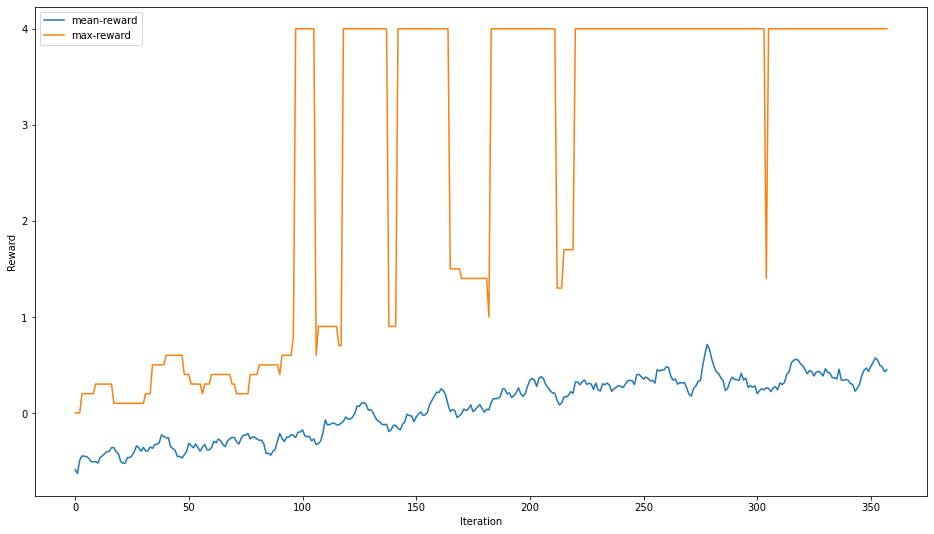

In [10]:
df = pd.read_csv("../../logs/PPO/PPO_3_vs_3_auto_GK_70b76_00000_0_2022-07-22_13-01-45/progress.csv")
plt.figure(figsize=(16, 9))
plt.plot(df.episode_reward_mean, label="mean-reward")
plt.plot(df.episode_reward_max, label="max-reward")
plt.xlabel("Iteration")
plt.ylabel("Reward")
plt.legend();

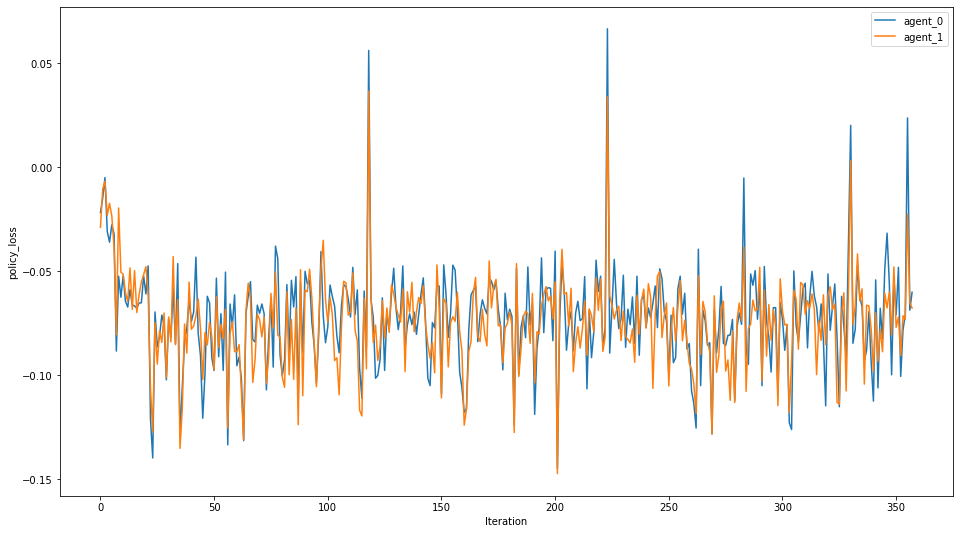

In [11]:
plt.figure(figsize=(16, 9))
plt.plot(df["info/learner/agent_0/learner_stats/policy_loss"], label="agent_0")
plt.plot(df["info/learner/agent_1/learner_stats/policy_loss"], label="agent_1")
plt.ylabel("policy_loss")
plt.xlabel("Iteration")
plt.legend();